On se propose dans ce mini-projet d'entrainer plusieurs mod√®les pour la t√¢che de *sentiment analysis* sur le dataset IMDB.

In [ ]:
## Library imports
import random
import os
import pandas as pd
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


# Presentation de l'√©tude

## T√¢che de Sentiment Analysis

La *sentiment analysis* est une t√¢che qui consiste √† identifier et classer les √©motions, opinions ou attitudes exprim√©es dans un texte, critiques, s√©quences textuellse. Le principe est de tenter de pr√©dire si un texte exprime un sentiment positif ou n√©gatif (ou parfois neutre, selon les cas).

Dans le cadre de ce projet, la *sentiment analysis* appliqu√©e aux critiques IMDb permet d'entra√Æner un mod√®le capable de pr√©dire le sentiment derri√®re une critique de film, en se basant uniquement sur le texte.

## Pr√©sentation du jeu de donn√©es IMDB

IMDB est un jeu de donn√©es pour la classification binaire des sentiments. Nous fournissons un ensemble de 25 000 critiques de films fortement polaris√©es pour l'entra√Ænement et 25 000 pour les tests. Des donn√©es non √©tiquet√©es suppl√©mentaires sont √©galement disponibles. Les formats de texte brut et de sac de mots d√©j√† trait√©s sont fournis.


Le dataset utilis√© pour cette t√¢che est le IMDb Dataset for Sentiment Analysis, propos√© par Stanford. Il contient des critiques de films provenant de la base de donn√©es IMDb. Ces critiques sont organis√©es en deux cat√©gories principales : positives et n√©gatives, permettant une classification binaire des sentiments. Le dataset comprend :

50 000 critiques : 25 000 critiques pour l'entra√Ænement *train* et 25 000 pour le *test*.
Les critiques d'entra√Ænement et de test sont √©quilibr√©es, contenant chacune un nombre √©gal de critiques positives et n√©gatives.
Les critiques varient en longueur, allant de quelques phrases √† plusieurs paragraphes, offrant un d√©fi int√©ressant pour les mod√®les de traitement du langage naturel (NLP).
Ce dataset est largement utilis√© pour √©valuer les mod√®les de classification des sentiments gr√¢ce √† sa taille, sa structure et sa pertinence pour des t√¢ches du monde r√©el.

In [ ]:
import os
import requests
import tarfile

# URL du dataset
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

# Nom du fichier d'archive
archive_name = "aclImdb_v1.tar.gz"
dataset_folder = "aclImdb"

# Fonction pour t√©l√©charger le fichier
def download_dataset(url, archive_name):
    if not os.path.exists(archive_name):
        print("T√©l√©chargement en cours...")
        response = requests.get(url, stream=True)
        with open(archive_name, "wb") as file:
            for chunk in response.iter_content(chunk_size=1024):
                if chunk:
                    file.write(chunk)
        print(f"Fichier t√©l√©charg√© : {archive_name}")
    else:
        print(f"Le fichier {archive_name} existe d√©j√†.")

# Fonction pour extraire le fichier
def extract_dataset(archive_name, extract_path):
    if not os.path.exists(extract_path):
        print("Extraction en cours...")
        with tarfile.open(archive_name, "r:gz") as tar:
            tar.extractall(path=extract_path)
        print(f"Dataset extrait dans le dossier : {extract_path}")
    else:
        print(f"Le dossier {extract_path} existe d√©j√†.")

# T√©l√©charger et extraire le dataset
download_dataset(url, archive_name)
extract_dataset(archive_name, dataset_folder)

# V√©rifier les fichiers extraits
print("Contenu du dossier extrait :")
for root, dirs, files in os.walk(dataset_folder):
    for name in files[:5]:  # Afficher seulement les 5 premiers fichiers
        print(os.path.join(root, name))

T√©l√©chargement en cours...
Fichier t√©l√©charg√© : aclImdb_v1.tar.gz
Extraction en cours...
Dataset extrait dans le dossier : aclImdb
Contenu du dossier extrait :
aclImdb/aclImdb/imdb.vocab
aclImdb/aclImdb/README
aclImdb/aclImdb/imdbEr.txt
aclImdb/aclImdb/train/urls_neg.txt
aclImdb/aclImdb/train/urls_pos.txt
aclImdb/aclImdb/train/urls_unsup.txt
aclImdb/aclImdb/train/unsupBow.feat
aclImdb/aclImdb/train/labeledBow.feat
aclImdb/aclImdb/train/neg/6378_4.txt
aclImdb/aclImdb/train/neg/4722_1.txt
aclImdb/aclImdb/train/neg/5264_4.txt
aclImdb/aclImdb/train/neg/2226_4.txt
aclImdb/aclImdb/train/neg/6392_3.txt
aclImdb/aclImdb/train/unsup/44083_0.txt
aclImdb/aclImdb/train/unsup/17334_0.txt
aclImdb/aclImdb/train/unsup/26566_0.txt
aclImdb/aclImdb/train/unsup/47090_0.txt
aclImdb/aclImdb/train/unsup/9279_0.txt
aclImdb/aclImdb/train/pos/2450_9.txt
aclImdb/aclImdb/train/pos/1532_10.txt
aclImdb/aclImdb/train/pos/12356_8.txt
aclImdb/aclImdb/train/pos/12429_7.txt
aclImdb/aclImdb/train/pos/2870_10.txt
aclI

In [ ]:
import os
import tensorflow as tf

dataset_folder = "aclImdb/aclImdb"

# Chemins vers les dossiers contenant les donn√©es
train_dir = os.path.join(dataset_folder, "train")
test_dir = os.path.join(dataset_folder, "test")

# Fonction pour charger les donn√©es
def load_imdb_data(data_dir):
    texts = []
    labels = []
    for label_type in ['pos', 'neg']:
        dir_name = os.path.join(data_dir, label_type)
        for fname in os.listdir(dir_name):
            if fname.endswith('.txt'):
                with open(os.path.join(dir_name, fname), encoding='utf-8') as f:
                    texts.append(f.read())
                labels.append(1 if label_type == 'pos' else 0)
    return texts, labels

# Chargement des donn√©es d'entra√Ænement et de test
train_texts, train_labels = load_imdb_data(train_dir)
test_texts, test_labels = load_imdb_data(test_dir)

print(f"Nombre de critiques dans l'ensemble d'entra√Ænement : {len(train_texts)}")
print(f"Nombre de critiques dans l'ensemble de test : {len(test_texts)}")

# Exemple de texte positif et n√©gatif
print("\nExemple de critique positive :")
print(train_texts[train_labels.index(1)][:300])  # Affiche les 300 premiers caract√®res d'une critique positive

print("\nExemple de critique n√©gative :")
print(train_texts[train_labels.index(0)][:300])  # Affiche les 300 premiers caract√®res d'une critique n√©gative

Nombre de critiques dans l'ensemble d'entra√Ænement : 25000
Nombre de critiques dans l'ensemble de test : 25000

Exemple de critique positive :
I have been watching this show since I was 14 and I've loved it ever since. I love this show because it's just plain funny! You will enjoy this show a lot because it shows something new and funnier everyday and my favorite part is when Benny always has her last comments on George after every punchli

Exemple de critique n√©gative :
This movie was amusing at times, hell sometimes it was even downright funny.<br /><br />The underlying message I got from the film though, was that women are responsible for all of the troubles of man. Every time a woman is depicted in the film, she is being lazy, being slutty or lambasting some poo


Les premi√®res critiques avec leurs labels correspondants (1 pour positif et 0 pour n√©gatif) sont affich√©es.

## Pr√©traitement des donn√©es

### Exploration des donn√©es

Pour d√©buter notre analyse, commen√ßons par une exploration des donn√©es. Une mani√®re visuelle et intuitive d'examiner le contenu textuel d'un dataset est de g√©n√©rer un word cloud. Un word cloud est une repr√©sentation graphique o√π la taille des mots est proportionnelle √† leur fr√©quence d‚Äôapparition dans un corpus donn√©. Cela permet de rep√©rer rapidement les termes les plus utilis√©s dans les critiques.

En cr√©ant des word clouds pour les critiques positives et n√©gatives, nous pouvons identifier les diff√©rences lexicales entre les deux cat√©gories, ce qui nous donne un aper√ßu des mots qui influencent le sentiment exprim√©.

In [ ]:
from collections import Counter
import nltk
from nltk.corpus import stopwords

# T√©l√©charger les stopwords NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction pour cr√©er un corpus bas√© sur les labels
def create_corpus_by_label(texts, labels, target_label):
    return " ".join([texts[i] for i in range(len(labels)) if labels[i] == target_label])

# Cr√©er les corpus pour les critiques positives et n√©gatives
positive_corpus = create_corpus_by_label(train_texts, train_labels, target_label=1)
negative_corpus = create_corpus_by_label(train_texts, train_labels, target_label=0)

# Fonction pour calculer les mots les plus fr√©quents
def most_frequent_words(corpus, top_n=10):
    # Diviser le corpus en mots
    words = [word.lower() for word in corpus.split() if word.lower() not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

# Calculer les 10 mots les plus fr√©quents pour chaque cat√©gorie
positive_top_words = most_frequent_words(positive_corpus, top_n=10)
negative_top_words = most_frequent_words(negative_corpus, top_n=10)

# Affichage des r√©sultats
print("10 mots les plus fr√©quents dans les critiques positives :")
for word, count in positive_top_words:
    print(f"{word}: {count}")

print("\n10 mots les plus fr√©quents dans les critiques n√©gatives :")
for word, count in negative_top_words:
    print(f"{word}: {count}")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


10 mots les plus fr√©quents dans les critiques positives :
/><br: 24617
film: 14641
movie: 13516
one: 11668
like: 8321
good: 6081
great: 5504
see: 5400
really: 5259
would: 5240

10 mots les plus fr√©quents dans les critiques n√©gatives :
/><br: 26318
movie: 17371
film: 13136
one: 10812
like: 10458
even: 7352
would: 6787
good: 5845
really: 5806
bad: 5335


Les critiques dans le dataset IMDb contiennent du texte HTML brut. Les br et />  proviennent des balises HTML incluses dans les critiques du dataset IMDb. Ces balises sont utilis√©es pour indiquer des sauts de ligne ou des s√©parations de paragraphes dans le texte brut. Elles n‚Äôont pas √©t√© filtr√©es et apparaissent dans les mots les plus fr√©quents car elles sont souvent pr√©sentes dans les critiques.

Ces balises sont consid√©r√©es comme des mots par le tokenizer dont on parlera plus tard.
Elles faussent donc les statistiques de fr√©quence en apparaissant parmi les mots les plus fr√©quents.
Le bruit dans les donn√©es (comme les balises HTML, caract√®res sp√©ciaux inutiles, etc.) peut introduire des relations non informatives dans le mod√®le.

Nous devons donc supprimer ces balises et nettoyer le text brut. Cela pourrait d√©tourner le mod√®le de l'apprentissage de r√©lations pertinentes entre les mots et sentiments de celui qui √©crit la critique.Cela pourrait aussi conduire √† une baisse de pr√©cision. Enfin, lors de la phase de tokenizing, chaque mot inutile comme les balises html r√©duit la place disponible dans le vocabulaire pour les mots pertinents.

In [ ]:
import re
# Fonction de nettoyage
def clean_text(text):
    # Supprimer les balises HTML
    text = re.sub(r"<.*?>", " ", text)
    # Supprimer les caract√®res non alphab√©tiques (optionnel)
    text = re.sub(r"[^a-zA-Z']", " ", text)
    # R√©duire les espaces multiples en un seul espace
    text = re.sub(r"\s+", " ", text).strip()
    return text

# Nettoyer toutes les critiques d'entra√Ænement et de test
train_texts_cleaned = [clean_text(text) for text in train_texts]
test_texts_cleaned = [clean_text(text) for text in test_texts]

# Fonction pour recalculer les mots les plus fr√©quents apr√®s nettoyage
def most_frequent_words_cleaned(corpus, top_n=10):
    # Diviser le corpus en mots
    words = [word.lower() for word in corpus.split() if word.lower() not in stop_words]
    word_counts = Counter(words)
    return word_counts.most_common(top_n)

# Recr√©er les corpus nettoy√©s pour critiques positives et n√©gatives
positive_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=1)
negative_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=0)

# Calculer les 10 mots les plus fr√©quents apr√®s nettoyage
positive_top_words_cleaned = most_frequent_words_cleaned(positive_corpus_cleaned, top_n=10)
negative_top_words_cleaned = most_frequent_words_cleaned(negative_corpus_cleaned, top_n=10)

# Afficher les r√©sultats apr√®s nettoyage
print("10 mots les plus fr√©quents dans les critiques positives (nettoy√©es) :")
for word, count in positive_top_words_cleaned:
    print(f"{word}: {count}")

print("\n10 mots les plus fr√©quents dans les critiques n√©gatives (nettoy√©es) :")
for word, count in negative_top_words_cleaned:
    print(f"{word}: {count}")

10 mots les plus fr√©quents dans les critiques positives (nettoy√©es) :
film: 20372
movie: 18860
one: 13496
like: 9038
good: 7703
story: 6715
time: 6491
great: 6409
well: 6408
see: 6016

10 mots les plus fr√©quents dans les critiques n√©gatives (nettoy√©es) :
movie: 24712
film: 18733
one: 13023
like: 11238
even: 7691
good: 7397
bad: 7374
would: 6902
really: 6262
time: 6195


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


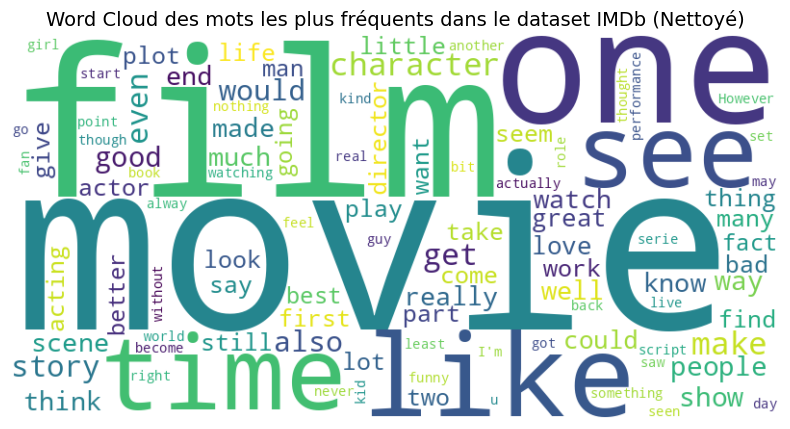

In [ ]:
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from nltk.corpus import stopwords

# T√©l√©charger les stopwords NLTK
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fonction pour cr√©er un corpus combin√© √† partir des critiques
def create_corpus(texts):
    # Fusionner toutes les critiques en un seul grand texte
    return " ".join(texts)

# G√©n√©rer le corpus √† partir des textes nettoy√©s d'entra√Ænement
corpus_cleaned = create_corpus(train_texts_cleaned)

# G√©n√©ration du WordCloud √† partir des donn√©es nettoy√©es
wordcloud_cleaned = WordCloud(
    stopwords=stop_words,  # Exclure les stopwords
    background_color="white",  # Couleur de fond
    max_words=100,  # Nombre maximum de mots √† afficher
    width=800,  # Largeur de l'image
    height=400  # Hauteur de l'image
).generate(corpus_cleaned)

# Affichage du WordCloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud_cleaned, interpolation='bilinear')
plt.axis("off")
plt.title("Word Cloud des mots les plus fr√©quents dans le dataset IMDb (Nettoy√©)", fontsize=14)
plt.show()

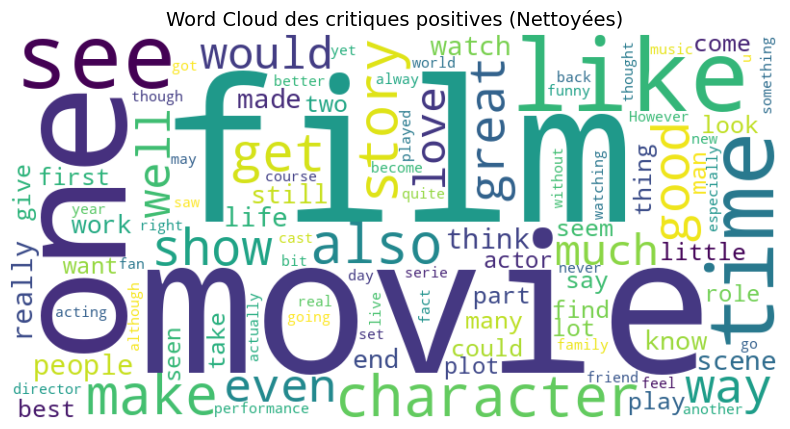

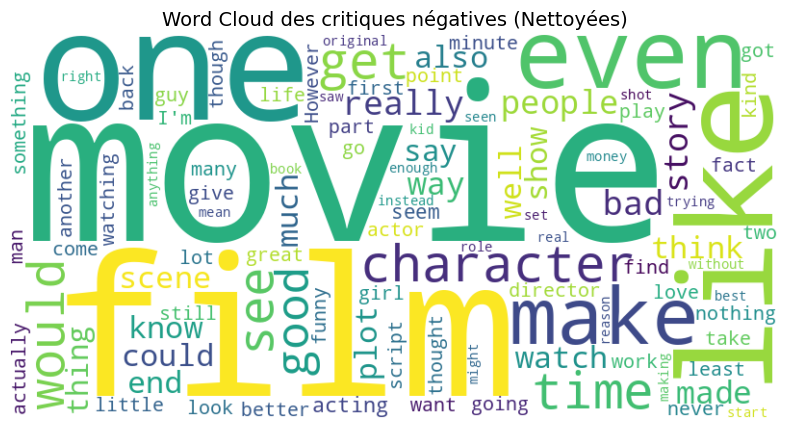

In [ ]:
# Cr√©ation des corpus pour critiques positives et n√©gatives (nettoy√©es)
positive_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=1)
negative_corpus_cleaned = create_corpus_by_label(train_texts_cleaned, train_labels, target_label=0)

# G√©n√©ration des WordClouds
def generate_wordcloud(corpus, title, stopwords, width=800, height=400):
    wordcloud = WordCloud(
        stopwords=stopwords,
        background_color="white",
        max_words=100,
        width=width,
        height=height
    ).generate(corpus)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=14)
    plt.show()

# WordCloud pour critiques positives (nettoy√©es)
generate_wordcloud(positive_corpus_cleaned, "Word Cloud des critiques positives (Nettoy√©es)", stop_words)

# WordCloud pour critiques n√©gatives (nettoy√©es)
generate_wordcloud(negative_corpus_cleaned, "Word Cloud des critiques n√©gatives (Nettoy√©es)", stop_words)

Longueur moyenne des critiques d'entra√Ænement (nettoy√©es) : 232.39 mots
Longueur moyenne des critiques de test (nettoy√©es) : 227.14 mots
Proportion des critiques d'entra√Ænement plus longues que 200 mots (nettoy√©es) : 41.09%
Proportion des critiques de test plus longues que 200 mots (nettoy√©es) : 40.01%


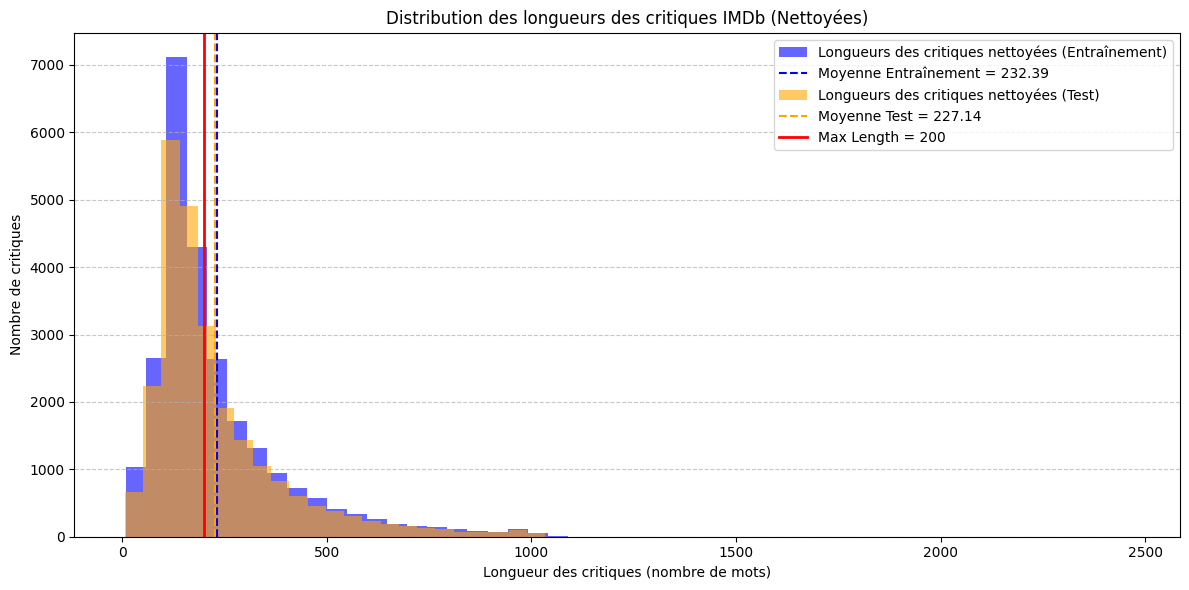

In [ ]:


# Calculer la longueur de chaque critique nettoy√©e
train_lengths_cleaned = [len(text.split()) for text in train_texts_cleaned]
test_lengths_cleaned = [len(text.split()) for text in test_texts_cleaned]

# Calculer la longueur moyenne des critiques nettoy√©es
average_train_length_cleaned = sum(train_lengths_cleaned) / len(train_lengths_cleaned)
average_test_length_cleaned = sum(test_lengths_cleaned) / len(test_lengths_cleaned)

# Afficher les r√©sultats
print(f"Longueur moyenne des critiques d'entra√Ænement (nettoy√©es) : {average_train_length_cleaned:.2f} mots")
print(f"Longueur moyenne des critiques de test (nettoy√©es) : {average_test_length_cleaned:.2f} mots")

# V√©rifier la proportion des critiques plus longues que max_length
max_length = 200  # Longueur maximale d√©finie
train_above_max_cleaned = sum(1 for length in train_lengths_cleaned if length > max_length) / len(train_lengths_cleaned) * 100
test_above_max_cleaned = sum(1 for length in test_lengths_cleaned if length > max_length) / len(test_lengths_cleaned) * 100

print(f"Proportion des critiques d'entra√Ænement plus longues que {max_length} mots (nettoy√©es) : {train_above_max_cleaned:.2f}%")
print(f"Proportion des critiques de test plus longues que {max_length} mots (nettoy√©es) : {test_above_max_cleaned:.2f}%")

# Visualisation de la distribution des longueurs nettoy√©es
plt.figure(figsize=(12, 6))

# Histogramme pour les donn√©es d'entra√Ænement nettoy√©es
plt.hist(train_lengths_cleaned, bins=50, alpha=0.6, color='blue', label='Longueurs des critiques nettoy√©es (Entra√Ænement)')
plt.axvline(average_train_length_cleaned, color='blue', linestyle='dashed', linewidth=1.5, label=f'Moyenne Entra√Ænement = {average_train_length_cleaned:.2f}')

# Histogramme pour les donn√©es de test nettoy√©es
plt.hist(test_lengths_cleaned, bins=50, alpha=0.6, color='orange', label='Longueurs des critiques nettoy√©es (Test)')
plt.axvline(average_test_length_cleaned, color='orange', linestyle='dashed', linewidth=1.5, label=f'Moyenne Test = {average_test_length_cleaned:.2f}')

# Ligne verticale pour la longueur maximale
plt.axvline(max_length, color='red', linestyle='solid', linewidth=2, label=f'Max Length = {max_length}')

# Configuration du graphique
plt.title("Distribution des longueurs des critiques IMDb (Nettoy√©es)")
plt.xlabel("Longueur des critiques (nombre de mots)")
plt.ylabel("Nombre de critiques")
plt.legend(loc='upper right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Afficher le graphique
plt.show()

La longueur moyenne est l√©g√®rement sup√©rieure √† 200 mots, mais elle montre que la majorit√© des critiques sont assez courtes ou mod√©r√©ment longues. De plus, les critiques trop longues contiennent souvent des d√©tails non pertinents pour la classification sentimentale. C'est un param√®tre important qui nous servira √† la *tokenization*.

## Tokenization

Il est n√©cessaire de passer par une phase de tokenization avant de traiter le texte pour la classification sentimentale. La tokenization est le processus de division d‚Äôun texte en unit√©s nomm√©es tokens.

Les mod√®les de NLP que nous allons utiliser travaillent avec des donn√©es num√©riques, mais les critiques sont sous forme de texte brut. La tokenization permet de convertir le texte en un format exploitable par les mod√®les.
Lors de la tokenization, les mots sont mapp√©s √† des indices dans un vocabulaire, permettant au mod√®le de manipuler les s√©quences de mani√®re efficace.

Pour cette t√¢che de sentiment analysis, une repr√©sentation s√©quentielle est plus adapt√©e pour plusieurs raisons‚ÄØ:

Les RNN, LSTM et GRU traitent les donn√©es de fa√ßon s√©quentielle, en tenant compte de l‚Äôordre des mots. Cela permet au mod√®le de comprendre des structures syntaxiques importantes. Avec des s√©quences, nous pouvons utiliser des repr√©sentations comme des embeddings, qui permettent d‚Äôapprendre des relations s√©mantiques entre les mots. Enfin, le dataset IMDb contient des critiques o√π l‚Äôordre des mots et les relations entre les mots sont importants pour analyser le sentiment exprim√©. Une repr√©sentation s√©quentielle permet de capturer ces nuances.

La tokenization bas√©e sur les s√©quences est une m√©thode qui convertit un texte en une liste ordonn√©e d‚Äôindices num√©riques repr√©sentant les mots ou les tokens du texte. Cette approche conserve l‚Äôordre des mots, ce qui est essentiel pour capturer les relations syntaxiques et s√©mantiques entre eux.

Dans le cadre du sentiment analysis, on construit un vocabulaire. cr√©√© √† partir du corpus d‚Äôentra√Ænement, o√π chaque mot unique est associ√© √† un indice num√©rique. Les mots les plus fr√©quents sont prioris√©s. Chaque mot d‚Äôune phrase est remplac√© par son indice correspondant dans le vocabulaire.

Les mots absents du vocabulaire (parce qu‚Äôils sont rares ou hors du corpus d‚Äôentra√Ænement) sont remplac√©s par un token sp√©cial, comme <OOV> (Out-Of-Vocabulary).

Les critiques sont de longueurs vari√©es. Hors pour la garantir la compatibilit√© avec les mod√®les de Deep Learning que nous allons utiliser, nous devons nous assurer que les critiques sont de m√™mes longueurs. Nous allons donc tronqu√©es ou remplir (via un padding) les s√©quences. Puisque les sequences sont en moyenne de dimension 200 d'apr√®s l'√©tude empirique pr√©cedente, et que les critiques trop longues contiennent de mani√®re g√©n√©rale des d√©tails non pertinents pour la classification sentimentale, nous allons tronquer les s√©quences trop grandes et remplir via un padding les s√©quences de moins de 200 caract√®res. Dans le dataset IMDb, de nombreuses critiques sont plus courtes que la longueur maximale fix√©e. Le padding permet de pr√©server ces critiques courtes en ajoutant des z√©ros √† la fin (padding='post') sans modifier leur contenu. Toutes nos s√©quences d'entr√©e seront donc de dimension 200 pour nos mod√®les.

Nous avons un total de 85 676 mots uniques dans le dataset. R√©duire √† 10 000 capture les mots les plus fr√©quents, ce qui est souvent suffisant dans l'√©tat de l'art de la classification de sentiment. De plus, dans notre s√©quence, les indices sont tous inf√©rieurs √† 10 000, indiquant que notre vocabulaire est suffisant pour repr√©senter ces critiques.

Plus le vocabulaire est grand, plus le mod√®le doit g√©rer un espace de recherche important, ce qui augmente les besoins en m√©moire et les temps de calcul. En limitant √† 10 000 mots, on garde les mots les plus fr√©quents, qui capturent g√©n√©ralement la majorit√© du sens du texte. Les mots rares (apparaissant tr√®s peu dans le dataset) ne sont souvent pas informatifs pour le mod√®le. En les excluant, on r√©duit le bruit dans les donn√©es.

Ce seuil de 10% √† 20% du vocabulaire totale commun√©ment utilis√©e dans les t√¢ches NLP. Ce seuil est un compromis entre conserver suffisamment de vocabulaire pour capturer le sens du texte et limiter les ressources n√©cessaires pour entra√Æner le mod√®le.



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Initialisation du tokenizer
vocab_size = 10000  # Limitation du vocabulaire
max_length = 200  # Longueur maximale des s√©quences
oov_token = "<OOV>"  # Token pour les mots hors vocabulaire

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(train_texts_cleaned)  # Apprentissage du vocabulaire sur les critiques nettoy√©es

# Tokenization : conversion des textes nettoy√©s en s√©quences
train_sequences = tokenizer.texts_to_sequences(train_texts_cleaned)
test_sequences = tokenizer.texts_to_sequences(test_texts_cleaned)

# Padding des s√©quences pour uniformiser leur longueur
train_padded = pad_sequences(train_sequences, maxlen=max_length, padding='post', truncating='post')
test_padded = pad_sequences(test_sequences, maxlen=max_length, padding='post', truncating='post')

# Conversion des labels en tenseur
train_labels = tf.convert_to_tensor(train_labels)
test_labels = tf.convert_to_tensor(test_labels)

# Affichage des donn√©es pr√©par√©es
print(f"Exemple de s√©quence tokenis√©e (entra√Ænement) : {train_sequences[0][:10]}")
print(f"Exemple de s√©quence avec padding (entra√Ænement) : {train_padded[0]}")
print(f"Vocabulaire total : {len(tokenizer.word_index)} mots")

Exemple de s√©quence tokenis√©e (entra√Ænement) : [10, 25, 74, 146, 11, 120, 234, 10, 13, 3]
Exemple de s√©quence avec padding (entra√Ænement) : [  10   25   74  146   11  120  234   10   13    3  204  443    9  123
  234   10  116   11  120   84   42   40 1034  159   22   77  353   11
  120    4  172   84    9  284  139  158    3 2774 2863    3   58  507
  169    7   51 8276  207   45   38  233  788   20  734  100  171 9710
   41   24 1902 1451  415  910   10   59  457    3  468  103    9   16
   58  363   30  339 9711   27   37   72   68  146    4  159   17   18
  341  116  734 7437  159 1009  159 2065   11    7    4  638  159  220
  209  197  728    6  312    3   22   77  403  353    9   10  119    3
   44   22  767  293    9  242   10 1452   12   22  375  146   84   22
  579  178    6  563  146    9   57  148   47  703 1611 3376  158  664
   10  128  353    2  738 1118  128  159  112 2864  122    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
   

Chaque critique a √©t√© transform√©e en une s√©quence d‚Äôindices num√©riques. Ces indices correspondent aux positions des mots dans le vocabulaire g√©n√©r√© par le tokenizer. L'ordre des indices dans la s√©quence est identique √† l'ordre des mots dans la critique d'origine. Cela permet de pr√©server les relations s√©mantiques et syntaxiques entre les mots, essentielles pour des mod√®les s√©quentiels.

La s√©quence tokenis√©e a √©t√© compl√©t√©e par des z√©ros pour atteindre une longueur fixe de 200 mots, d√©finie par le param√®tre max_length.
Les z√©ros sont ajout√©s √† la fin de la s√©quence (padding='post'), qui assure que toutes les s√©quences ont la m√™me longueur sans alt√©rer l'ordre des mots d'origine.

La tokenization doit √™tre bijective, c'est-√†-dire qu'il devrait √™tre possible de reconstruire le texte d'origine √† partir de la s√©quence tokenis√©e, √† condition que tous les mots soient pr√©sents dans le vocabulaire. Cela garantit que le processus de tokenization n'a pas introduit d'erreurs ou d'incoh√©rences.

Les deux textes devraient √™tre similaires, bien que le texte reconstruit puisse avoir des diff√©rences (par exemple, des mots remplac√©s par <OOV> si absents du vocabulaire).
Si le texte reconstruit est trop √©loign√©, cela peut indiquer un probl√®me dans le vocabulaire ou le processus de tokenization.
V√©rifier les tokens <OOV> :

Si des mots du texte reconstruit sont remplac√©s par <OOV>, cela signifie que ces mots √©taient hors du vocabulaire. Leur proportion peut √™tre calcul√©e pour √©valuer si la taille du vocabulaire (vocab_size) est suffisante.

In [ ]:
# Nettoyer une critique d'origine
cleaned_text = clean_text(train_texts[0])

# Conversion en s√©quence tokenis√©e
tokenized_sequence = tokenizer.texts_to_sequences([cleaned_text])[0]

# Reconstruire le texte √† partir de la s√©quence
reconstructed_text = " ".join([tokenizer.index_word.get(token, "<OOV>") for token in tokenized_sequence])

# Afficher les r√©sultats
print("Texte original (nettoy√©) :")
print(cleaned_text[:300])  # Limiter √† 300 caract√®res pour √©viter les sorties trop longues

print("\nS√©quence tokenis√©e :")
print(tokenized_sequence[:20])  # Limiter √† 20 tokens pour simplifier la lecture

print("\nTexte reconstruit :")
print(reconstructed_text[:300])  # Limiter √† 300 caract√®res

Texte original (nettoy√©) :
I have been watching this show since I was and I've loved it ever since I love this show because it's just plain funny You will enjoy this show a lot because it shows something new and funnier everyday and my favorite part is when Benny always has her last comments on George after every punchline ab

S√©quence tokenis√©e :
[10, 25, 74, 146, 11, 120, 234, 10, 13, 3, 204, 443, 9, 123, 234, 10, 116, 11, 120, 84]

Texte reconstruit :
i have been watching this show since i was and i've loved it ever since i love this show because it's just plain funny you will enjoy this show a lot because it shows something new and funnier everyday and my favorite part is when benny always has her last comments on george after every punchline ab


In [ ]:
# Calculer le pourcentage de mots hors vocabulaire
oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
total_count = len(tokenized_sequence)
oov_percentage = (oov_count / total_count) * 100

print(f"\nProportion des mots hors vocabulaire : {oov_percentage:.2f}%")


Proportion des mots hors vocabulaire : 0.00%


Dans cet exemple, la tokenization a √©t√© effectu√©e correctement.

In [ ]:
# S√©lectionner 5 indices al√©atoires
random_indices = random.sample(range(len(train_texts)), 5)

for idx in random_indices:
    # Texte original nettoy√©
    original_text = train_texts_cleaned[idx]

    # S√©quence tokenis√©e
    tokenized_sequence = tokenizer.texts_to_sequences([original_text])[0]

    # Texte reconstruit √† partir de la s√©quence
    reconstructed_text = " ".join([tokenizer.index_word.get(token, "<OOV>") for token in tokenized_sequence])

    # Calcul de la proportion de mots hors vocabulaire
    oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
    total_count = len(tokenized_sequence)
    oov_percentage = (oov_count / total_count) * 100 if total_count > 0 else 0

    # Appliquer le padding √† la s√©quence
    padded_sequence = pad_sequences([tokenized_sequence], maxlen=max_length, padding='post', truncating='post')[0]

    # V√©rifier la longueur de la s√©quence apr√®s padding
    sequence_length = len(padded_sequence)
    is_length_correct = sequence_length == max_length

    # Affichage des r√©sultats
    print(f"Exemple {idx + 1} :\n")
    print("Texte original (nettoy√©) :")
    print(original_text[:300])  # Limiter √† 300 caract√®res
    print("\nS√©quence tokenis√©e :")
    print(tokenized_sequence[:20])  # Limiter √† 20 tokens
    print("\nTexte reconstruit :")
    print(reconstructed_text[:300])  # Limiter √† 300 caract√®res
    print(f"\nProportion des mots hors vocabulaire : {oov_percentage:.2f}%")
    print("\nLongueur de la s√©quence apr√®s padding :", sequence_length)
    print("La longueur de la s√©quence est-elle correcte ? :", is_length_correct)
    print("-" * 80)

Exemple 5126 :

Texte original (nettoy√©) :
I have found this movie available for streaming on Netflix and thought I'd give it a try The plot revolves around Ryan and Theo Taylor Colm Feore and David Cubitt who have finally seen each other after their father has passed away Ryan and Theo at first argue about who did what But later Theo finds 

S√©quence tokenis√©e :
[10, 25, 254, 11, 17, 1426, 15, 1, 20, 6226, 3, 194, 468, 199, 9, 4, 348, 2, 111, 3040]

Texte reconstruit :
i have found this movie available for <OOV> on netflix and thought i'd give it a try the plot revolves around ryan and theo taylor <OOV> <OOV> and david <OOV> who have finally seen each other after their father has passed away ryan and theo at first argue about who did what but later theo finds out 

Proportion des mots hors vocabulaire : 5.84%

Longueur de la s√©quence apr√®s padding : 200
La longueur de la s√©quence est-elle correcte ? : True
-------------------------------------------------------------------------

Regardons le pourcentage d'OOV moyen dans notre jeu de donn√©es d'entrainement.

In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Fonction pour calculer la proportion de mots hors vocabulaire pour une critique
def calculate_oov_percentage(text, tokenizer):
    tokenized_sequence = tokenizer.texts_to_sequences([text])[0]
    oov_count = sum(1 for token in tokenized_sequence if token == tokenizer.word_index.get("<OOV>"))
    total_count = len(tokenized_sequence)
    oov_percentage = (oov_count / total_count) * 100 if total_count > 0 else 0
    return oov_percentage

# Calculer le pourcentage moyen d'OOV pour l'ensemble des critiques
all_oov_percentages = []

for text in train_texts_cleaned:
    oov_percentage = calculate_oov_percentage(text, tokenizer)
    all_oov_percentages.append(oov_percentage)

# Calculer la moyenne
mean_oov_percentage = np.mean(all_oov_percentages)

# Afficher le r√©sultat
print(f"Pourcentage moyen de mots hors vocabulaire (OOV) : {mean_oov_percentage:.2f}%")

Pourcentage moyen de mots hors vocabulaire (OOV) : 5.21%


Un certain pourcentage d‚ÄôOOV est in√©vitable. Le vocabulaire est limit√© aux 10 000 mots les plus fr√©quents pour r√©duire la taille du mod√®le et le bruit des mots rares. Cela signifie que les mots moins fr√©quents seront exclus et appara√Ætront comme <OOV>. De plus, le dataset IMDb contient des critiques √©crites par diff√©rentes personnes, avec des styles vari√©s, des abr√©viations ou des termes sp√©cifiques (noms de films, acteurs, etc.), qui sont moins fr√©quents dans le corpus.

Ici, le pourcentage moyen est relativement faible, indiquant que le vocabulaire est suffisamment large pour couvrir la plus part des mots significatifs.

La tokenization a √©t√© effectu√©e correctement. Les s√©quences sont correctement transform√©es et pr√™tes pour √™tre utilis√©es dans un mod√®le. La taille du vocabulaire est raisonnable pour inclure les mots les plus informatifs tout en excluant les mots rares ou inutiles.

# Entrainement des mod√®les

## Preparation des donn√©es

Nous commencons dans un premier par s√©parer nos donn√©es d'entrainement en un jeu de donn√©es d'apprentissage repr√©sentant 80% des donn√©es, et un jeu de donn√©es de validation qui contient les 20% r√©stants.

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

# Assurez-vous que les labels sont des tableaux NumPy avant la s√©paration
train_labels_np = np.array(train_labels)

# S√©paration des donn√©es
train_padded_train, train_padded_val, train_labels_train, train_labels_val = train_test_split(
    train_padded, train_labels_np, test_size=0.2, random_state=42
)

# Reconversion des labels en tenseurs TensorFlow
train_labels_train = tf.convert_to_tensor(train_labels_train, dtype=tf.int32)
train_labels_val = tf.convert_to_tensor(train_labels_val, dtype=tf.int32)

# V√©rification des formes
print(f"Entra√Ænement : {train_padded_train.shape}, Labels : {train_labels_train.shape}")
print(f"Validation : {train_padded_val.shape}, Labels : {train_labels_val.shape}")


Entra√Ænement : (20000, 200), Labels : (20000,)
Validation : (5000, 200), Labels : (5000,)


Cela √©vite au mod√®le de m√©moriser ces donn√©es au lieu de g√©n√©raliser. Le jeu de validation aide √† √©valuer la performance sur des donn√©es non vues pendant l'entra√Ænement.

##RNN

Commencons dan sun premier temps par entrainer un Recurrent Neural Network (RNN).

Ces r√©seaux sont con√ßus pour traiter des donn√©es s√©quentielles. Ces r√©seaux poss√®dent en outre des connexions r√©currentes, ce qui leur permet de conserver un m√©moire des √©tapes pr√©cedentes. Cel√† permet de comprendre le contexte et les relations dans nos s√©quences.

Les RNN traitent les entr√©es s√©quentiellement, un √©l√©ment √† la fois, en maintenant un √©tat interne (ou m√©moire) qui est mis √† jour √† chaque √©tape.
√Ä chaque pas de temps, le RNN combine l'entr√©e actuelle avec cet √©tat interne pour produire une sortie.

Un RNN produit des sorties √† chaque √©tape temporelle que l'on appelle scores. Ces scores sont des vecteurs de dimension √©gale au nombre de classes (2 classes dans notre cas).

Dans le cas de la classification binaire, on applique enfin un sigmoid sur ces scores, les covertissant en probabilit√©s. On utilisera enfin une perte de Binary Cross-Entropy, notre classification √©tant binaire.

Commen√ßons par entyrainer un mod√®le simple de RNN. On commence par une couche d'embedding, qui cr√©e une repr√©sentation dense des mots : chaque mot est transform√© en un vecteur dense. Ces vecteurs, appel√©s embeddings, capturent les relations s√©mantiques et syntaxiques entre les mots dans un espace vectoriel. Cela permet en outre de fournir une entr√©e adapt√©e √† la couche RNN. Ces embeddings sont appris au cours de l'apprentissage du mod√®le.
On chosiit en outre une dimension d'embedding de 100, ce qui est pr√©conis√© dans la litterature scientifique pour un dataset mod√©r√©ment grand comme le n√¥tre. On consid√®re qu'une dimension de 100 permet de de capturer les relations s√©mantiques pertinentes sans rendre le mod√®le trop complexe, suffisemment pour la classification binaire de sentiments.
En somme, une dimension de 100 permet de capturer les relations pertinentes, tout en gradant un temps d'entrainement raisonnables et garantissant un mod√®le suffisamment simple pour √©viter le surapprentissage.

On utilise une seule couche RNN avec 64 unit√©s pour commencer. On choisit ici une petite taille pour √©viter le surrapprentissage. On verra apr√®s si une seule couche suffit, ce qui signifierait que les d√©pendances s√©quentielles sont plut√¥t simples.

On met une couche de dropout de 20%, abandonnant 20% des neurones et √©vitant le surapprentissage.

On ajoute enfin une couche dense avec 1 neurone en sortie du mod√®le, et une activation sigmoid, adapt√©e √† la classification binaire.

Pour finir, la binary cross entropy est choisie en tant que Loss, id√©ale pour la classification binaire.

On prend une taille de batch √† 64, permettant d'optimiser les performances du GPU. On choisit un nombre d'epochs de 10 ce qui est classique pour esperer observer une convergence.

Concernant l'optimiseur, on choisit l'optimiseur Adam par d√©faut avec un learning rate de 0.001, ce qui standard, pour sa vitesse de convergence et sa robustesse et sa capacit√© √† g√©rer automatiquement les ajustements des pas d'apprentissage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam

# Param√®tres pour l'embedding layer
embedding_dim = 100  # Taille des vecteurs de mots

# D√©finition du mod√®le RNN
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(64, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Force la construction du mod√®le avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation du mod√®le
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du r√©sum√© du mod√®le
mod.summary()

# Entra√Ænement du mod√®le
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=64
)



Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_1 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn_1 (SimpleRNN)             ‚îÇ (1, 64)                     ‚îÇ          10,560 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)                  ‚îÇ (1, 64)                     ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                      ‚îÇ (1, 1)                      ‚îÇ              65 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,010,625 (3.86 MB)

 Trainable params: 1,010,625 (3.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 34ms/step - accuracy: 0.4992 - loss: 0.7003 - val_accuracy: 0.4956 - val_loss: 0.6946
Epoch 2/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 27ms/step - accuracy: 0.5051 - loss: 0.7062 - val_accuracy: 0.4970 - val_loss: 0.6978
Epoch 3/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 27ms/step - accuracy: 0.5193 - loss: 0.6972 - val_accuracy: 0.5056 - val_loss: 0.6949
Epoch 4/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 26ms/step - accuracy: 0.5631 - loss: 0.6740 - val_accuracy: 0.5076 - val_loss: 0.7005
Epoch 5/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 26ms/step - accuracy: 0.5915 - loss: 0.6530 - val_accuracy: 0.5168 - val_loss: 0.7069
Epoch 6/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 27ms/step - accuracy: 0.6146 - loss: 0.6215 - val_accuracy: 0.5194 - va

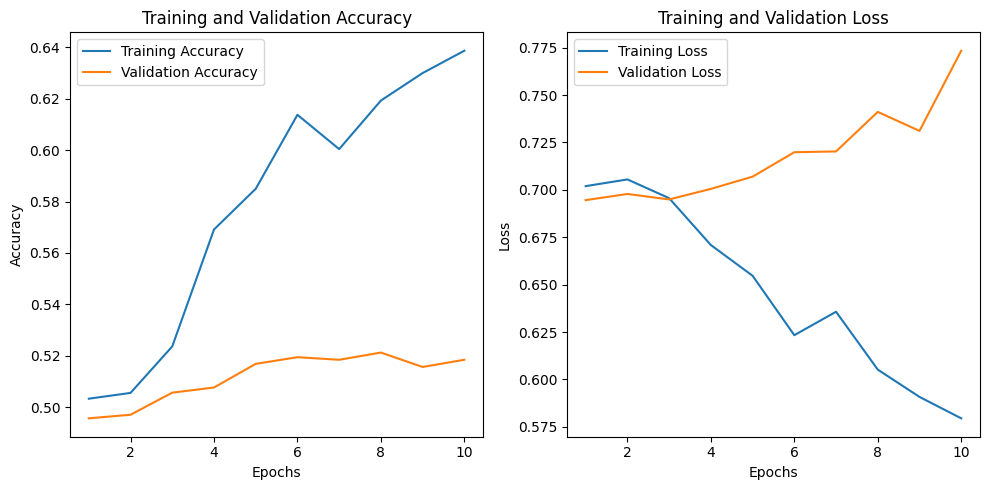

In [ ]:
import matplotlib.pyplot as plt

# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

La perte diminue constamment, indiquant que le mod√®le apprend bien sur les donn√©es d'entra√Ænement. √Ä l'√©poque 10, la perte d'entra√Ænement est 0.34, ce qui montre une bonne

La perte sur l'ensemble de validation augmente constamment apr√®s l'√©poque 2 (0.7155 ‚Üí 1.0707).
Cela montre un surapprentissage (overfitting) : le mod√®le s'adapte trop sp√©cifiquement aux donn√©es d'entra√Ænement et ne g√©n√©ralise pas bien.

L'accuracy augmente jusqu'√† 78.69% √† l'√©poque 10, ce qui est un bon r√©sultat pour l'entra√Ænement.

L'accuracy de validation reste autour de 50%, proche du hasard (probl√®me de classification binaire).

Le mod√®le surapprend :
La divergence entre l'accuracy d'entra√Ænement (78%) et de validation (50%) indique un surapprentissage.
Probl√®me de g√©n√©ralisation :
Le mod√®le n'arrive pas √† apprendre de mani√®re efficace les patterns pr√©sents dans l'ensemble de validation.
Cela peut venir d'un manque de r√©gularisation ou d'une capacit√© du mod√®le inadapt√©e (trop simple).

Pour am√©liorer ce mod√®le, on d√©cide d√©j√† de rajouter une couche simple.
Apprentissage de caract√©ristiques plus complexes : Une deuxi√®me couche SimpleRNN permet au mod√®le d'apprendre des repr√©sentations plus abstraites des s√©quences apr√®s la premi√®re couche. Cela am√©liore la capacit√© du mod√®le √† capturer des relations temporelles plus riches.
Augmentation de la capacit√© du mod√®le : En ajoutant une couche suppl√©mentaire, le mod√®le gagne en profondeur, ce qui peut l'aider √† mieux mod√©liser les donn√©es d'entr√©e.
Am√©lioration des performances : Avec une architecture plus complexe, on peut esp√©rer une meilleure performance si le mod√®le est bien r√©gularis√©.

Surapprentissage (overfitting) :

Une couche SimpleRNN suppl√©mentaire augmente le nombre de param√®tres du mod√®le.
Cela rend le mod√®le plus complexe et donc plus susceptible de s'adapter trop fortement aux donn√©es d'entra√Ænement, ce qui peut r√©duire la performance en validation.

Pour ajouter une couche SimpleRNN tout en limitant le surapprentissage, voici les techniques recommand√©es :

Augmenter le Dropout :

Le Dropout aide √† r√©gulariser le mod√®le en d√©sactivant de mani√®re al√©atoire des neurones pendant l'apprentissage.
Cela emp√™che le mod√®le de devenir trop d√©pendant de certains neurones.
Appliquer une r√©gularisation L2 (ridge regularization) :

La r√©gularisation L2 p√©nalise les poids trop grands dans les couches denses, ce qui r√©duit le surapprentissage.
Ajouter du Dropout entre les couches RNN :

Cela permet de r√©gulariser la sortie de chaque couche RNN avant qu'elle ne soit transmise √† la suivante.

B√©n√©fices attendus :
Am√©lioration de la g√©n√©ralisation gr√¢ce √† la r√©gularisation L2 et au Dropout.
Capacit√© accrue du mod√®le pour capturer des motifs plus complexes.
R√©duction du surapprentissage par la combinaison de Dropout et r√©gularisation.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

# Param√®tres
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 100  # Taille des vecteurs de mots
max_length = 200  # Longueur maximale des s√©quences
dropout_rate = 0.3  # Taux de dropout
l2_reg = 0.01  # Facteur de r√©gularisation L2

# D√©finition du mod√®le avec une couche SimpleRNN suppl√©mentaire
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # Premi√®re couche RNN
    Dropout(dropout_rate),  # Dropout apr√®s la premi√®re couche
    SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Deuxi√®me couche RNN
    Dropout(dropout_rate),  # Dropout apr√®s la deuxi√®me couche
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Couche finale avec r√©gularisation L2
])

# Force la construction du mod√®le avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation du mod√®le
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du r√©sum√© du mod√®le
mod.summary()

# Entra√Ænement du mod√®le
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=64
)


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_2 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn_2 (SimpleRNN)             ‚îÇ (1, 200, 64)                ‚îÇ          10,560 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)                  ‚îÇ (1, 200, 64)                ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn_3 (SimpleRNN)             ‚îÇ (1, 32)                     ‚îÇ           3,104 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)                  ‚îÇ (1, 32)                     ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                      ‚îÇ (1, 1)                      ‚îÇ              33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,013,697 (3.87 MB)

 Trainable params: 1,013,697 (3.87 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 24s 63ms/step - accuracy: 0.5078 - loss: 1.5347 - val_accuracy: 0.5016 - val_loss: 0.8323
Epoch 2/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 52ms/step - accuracy: 0.5031 - loss: 0.7857 - val_accuracy: 0.5090 - val_loss: 0.7140
Epoch 3/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 52ms/step - accuracy: 0.4980 - loss: 0.7172 - val_accuracy: 0.4970 - val_loss: 0.7011
Epoch 4/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 52ms/step - accuracy: 0.4977 - loss: 0.7009 - val_accuracy: 0.4970 - val_loss: 0.6956
Epoch 5/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 52ms/step - accuracy: 0.5027 - loss: 0.6958 - val_accuracy: 0.5030 - val_loss: 0.6941
Epoch 6/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 52ms/step - accuracy: 0.4974 - loss: 0.6946 - val_accuracy: 0.4970

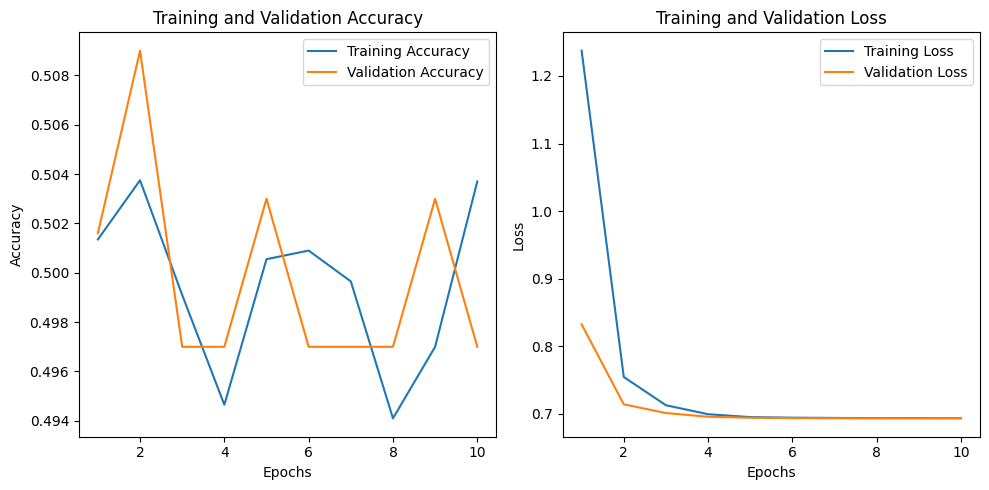

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Interpr√©tation :

Le surapprentissage a disparu : Le mod√®le ne cherche plus √† "surm√©moriser" les donn√©es d'entra√Ænement.
Mais le mod√®le n'apprend toujours pas : Il reste bloqu√© √† une performance al√©atoire, ce qui sugg√®re qu'il n'est pas capable d'extraire des informations utiles des s√©quences.


Loss d'entra√Ænement : Stagne autour de 0.693, ce qui est proche d'un mod√®le al√©atoire.
Loss de validation : Stagne √©galement autour de 0.693.
Accuracy (entra√Ænement et validation) : Stable autour de 50%.

Dropout : R√©gularise le mod√®le en d√©sactivant des neurones pendant l'entra√Ænement. Cela emp√™che le mod√®le de m√©moriser les donn√©es exactes.
R√©gularisation L2 : P√©nalise les poids excessivement grands, ce qui limite la complexit√© du mod√®le.

Le surapprentissage est contr√¥l√© gr√¢ce au Dropout et √† la r√©gularisation L2. C'est une avanc√©e importante !

Le surapprentissage a disparu : Le mod√®le ne cherche plus √† "surm√©moriser" les donn√©es d'entra√Ænement.
Mais le mod√®le n'apprend toujours pas : Il reste bloqu√© √† une performance al√©atoire, ce qui sugg√®re qu'il n'est pas capable d'extraire des informations utiles des s√©quences.

On peut essayer d‚Äôaugmenter la capacit√© du mod√®le en ajoutant une troisi√®me couche SimpleRNN. Cela peut permettre au r√©seau d'apprendre des caract√©ristiques plus complexes des donn√©es, en ajoutant davantage de profondeur.

Pourquoi une troisi√®me couche SimpleRNN peut √™tre utile ?
Capacit√© d‚Äôapprentissage accrue :

Chaque couche RNN apprend des caract√©ristiques √† un niveau d'abstraction diff√©rent. Une troisi√®me couche peut aider √† extraire des relations plus complexes.
Par exemple :
1√®re couche : apprend des caract√©ristiques locales.
2e couche : capture des motifs plus abstraits.
3e couche : combine ces motifs pour tirer des relations globales.
Approfondissement du mod√®le :

Les mod√®les plus profonds peuvent mieux g√©n√©raliser si bien r√©gularis√©s.

On notera ici que chaque couche RNN augmente la m√©moire utilis√©e, car elle doit g√©rer des √©tats temporels √† chaque √©tape. Utilise un batch size plus petit pour limiter l'utilisation m√©moire.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dropout, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Param√®tres
vocab_size = 10000  # Taille du vocabulaire
embedding_dim = 100  # Taille des vecteurs de mots
max_length = 200  # Longueur maximale des s√©quences
dropout_rate = 0.3  # Taux de dropout
l2_reg = 0.01  # R√©gularisation L2

# Mod√®le avec 3 couches SimpleRNN
mod = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    SimpleRNN(128, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # Premi√®re couche RNN
    Dropout(dropout_rate),
    SimpleRNN(64, return_sequences=True, kernel_regularizer=l2(l2_reg)),  # Deuxi√®me couche RNN
    Dropout(dropout_rate),
    SimpleRNN(32, return_sequences=False, kernel_regularizer=l2(l2_reg)),  # Troisi√®me couche RNN
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid', kernel_regularizer=l2(l2_reg))  # Couche de sortie
])

# Force la construction du mod√®le avec un input d'exemple
mod(tf.zeros((1, max_length)))

# Compilation
mod.compile(optimizer=Adam(learning_rate=0.001),
            loss='binary_crossentropy',
            metrics=['accuracy'])

# Affichage du r√©sum√© du mod√®le
mod.summary()

# Entra√Ænement
history = mod.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,
    batch_size=32  # Utiliser un batch plus petit pour √©viter les erreurs m√©moire
)


Model: "sequential_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_4 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn_7 (SimpleRNN)             ‚îÇ (1, 200, 128)               ‚îÇ          29,312 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_7 (Dropout)                  ‚îÇ (1, 200, 128)               ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn_8 (SimpleRNN)             ‚îÇ (1, 200, 64)                ‚îÇ          12,352 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_8 (Dropout)                  ‚îÇ (1, 200, 64)                ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ simple_rnn_9 (SimpleRNN)             ‚îÇ (1, 32)                     ‚îÇ           3,104 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_9 (Dropout)                  ‚îÇ (1, 32)                     ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ (1, 1)                      ‚îÇ              33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,044,801 (3.99 MB)

 Trainable params: 1,044,801 (3.99 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 56s 80ms/step - accuracy: 0.4907 - loss: 1.9050 - val_accuracy: 0.4970 - val_loss: 0.8023
Epoch 2/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 48s 78ms/step - accuracy: 0.4983 - loss: 0.7716 - val_accuracy: 0.5028 - val_loss: 0.7106
Epoch 3/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 48s 77ms/step - accuracy: 0.4968 - loss: 0.7076 - val_accuracy: 0.5030 - val_loss: 0.6989
Epoch 4/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 48s 77ms/step - accuracy: 0.4978 - loss: 0.6983 - val_accuracy: 0.4970 - val_loss: 0.6955
Epoch 5/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 48s 77ms/step - accuracy: 0.5026 - loss: 0.6949 - val_accuracy: 0.4970 - val_loss: 0.6940
Epoch 6/10
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 48s 78ms/step - accuracy: 0.4934 - loss: 0.6940 - val_accuracy: 0.4970

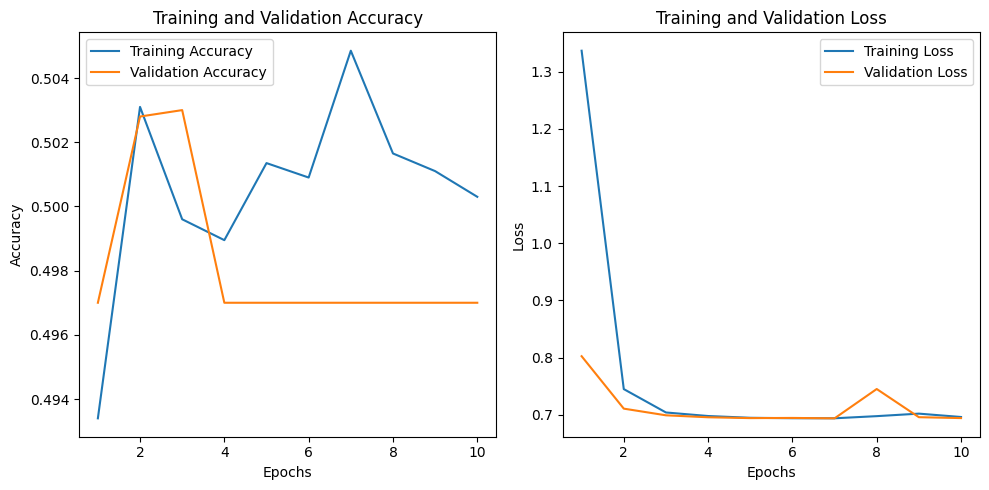

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Malgr√© l'ajout d'une troisi√®me couche RNN, Accuracy stagnante autour de 50%.
Loss proche de 0.693 : Le mod√®le est bloqu√© √† un niveau al√©atoire, ce qui montre qu'il n'apprend rien. nous sommes probablement dans le cas du "vanishing gradient". Voici pourquoi :

Les couches SimpleRNN sont peu performantes pour les s√©quences longues :

Les RNN simples calculent des gradients qui diminuent exponentiellement avec le nombre d'√©tapes temporelles (ici max_length=200).
Cela emp√™che les couches profondes (3 couches RNN ici) d'apprendre efficacement, car les gradients sont trop faibles pour mettre √† jour les poids.

Le probl√®me vient du RNN lui-m√™me : il ne transmet pas efficacement les informations √† travers les couches temporelles.
Une couche Dense re√ßoit en entr√©e la sortie finale des RNN, qui est d√©j√† informe ou "perdue" √† cause du vanishing gradient.

Maintenant non : Optimiser les hyperparam√®tres sur un mod√®le qui n'apprend pas est inutile.

Le probl√®me principal vient du RNN lui-m√™me :

Les SimpleRNN souffrent du vanishing gradient pour des s√©quences longues comme les critiques IMDb (max_length=200).
M√™me avec des embeddings pr√©-entra√Æn√©s, les RNN simples ne peuvent pas capturer efficacement les d√©pendances √† long terme.

Gr√¢ce au Dropout et √† la r√©gularisation L2, on a r√©ussi √† limiter le surapprentissage.
Avant : La loss de validation augmentait constamment ‚Üí preuve de surapprentissage.
Maintenant : La loss d'entra√Ænement et de validation stagnent ensemble autour de 0.693, ce qui montre que le mod√®le ne sur-apprend plus.
Performances stagnantes √† cause du Vanishing Gradient :

Le SimpleRNN est incapable de capturer des relations temporelles √† long terme dans des s√©quences longues comme celles des critiques IMDb (max_length=200).
Le vanishing gradient emp√™che les poids dans les couches profondes d'√™tre mis √† jour efficacement pendant la r√©tropropagation.
R√©sultat :

La loss stagne autour de 0.693 (√©quivalent √† une pr√©diction al√©atoire).
L'accuracy reste proche de 50%.
Pourquoi le vanishing gradient bloque les performances ?
Structure des RNN simples :

Les RNN simples ne peuvent pas transmettre efficacement les informations sur de nombreuses √©tapes temporelles.
Les gradients deviennent trop petits √† chaque √©tape, et les couches RNN profondes ne re√ßoivent donc aucune mise √† jour utile.
Longueur des s√©quences :

Avec max_length=200, le mod√®le doit apprendre des relations qui se trouvent loin dans le temps. Les RNN simples √©chouent √† capturer ces relations, m√™me si on rajoute de la profondeur dans le r√©seau


In [ ]:
# Sauvegarder le mod√®le complet (architecture + poids + optimiseur)
model_path = "rnn_final.h5"  # Renommer le fichier
mod.save(model_path)

print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous rnn_final.h5


In [ ]:
from google.colab import files
files.download('rnn_final.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Afin, d'√©viter le vanishing gradient et capturer des relations √† long terme dans les s√©quences, d'autres arhitectures adapt√©es existent, comme les LSTM et les GRU, que nous allons abord√© maintenant.

##LSTM

1. Introduction aux LSTM
Les RNN (R√©seaux de Neurones R√©currents) classiques souffrent du probl√®me du gradient √©vanescent lors de l'entra√Ænement sur des s√©quences longues. Les LSTM (Long Short-Term Memory) sont une variante des RNN con√ßue pour r√©soudre ce probl√®me en permettant une meilleure gestion de la m√©moire √† long terme.

Les LSTM introduisent des m√©canismes appel√©s portes pour contr√¥ler le flux d'information, ce qui les rend capables d'apprendre des d√©pendances temporelles longues.

2. Architecture des LSTM
Une cellule LSTM est constitu√©e des √©l√©ments suivants :

√âtat de cellule :
ùê∂
ùë°
C
t
‚Äã
  ‚Üí m√©moire √† long terme.
√âtat cach√© :
‚Ñé
ùë°
h
t
‚Äã
  ‚Üí sortie √† l'instant
ùë°
t.
Trois portes principales :
Porte d'entr√©e (Input Gate) : contr√¥le quelles nouvelles informations seront ajout√©es √† la m√©moire.
Porte d'oubli (Forget Gate) : contr√¥le quelles informations anciennes seront oubli√©es.
Porte de sortie (Output Gate) : contr√¥le quelles informations seront utilis√©es pour la sortie √† l'instant
ùë°
t.
Formules math√©matiques :
Porte d'oubli :

ùëì
ùë°
=
ùúé
(
ùëä
ùëì
‚ãÖ
[
‚Ñé
ùë°
‚àí
1
,
ùë•
ùë°
]
+
ùëè
ùëì
)
f
t
‚Äã
 =œÉ(W
f
‚Äã
 ‚ãÖ[h
t‚àí1
‚Äã
 ,x
t
‚Äã
 ]+b
f
‚Äã
 )
ùëì
ùë°
f
t
‚Äã
  : vecteur de la porte d'oubli.
ùëä
ùëì
W
f
‚Äã
 ,
ùëè
ùëì
b
f
‚Äã
  : poids et biais de la porte d'oubli.
ùë•
ùë°
x
t
‚Äã
  : entr√©e √† l'instant
ùë°
t.
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
  : √©tat cach√© √† l'instant pr√©c√©dent.
Porte d'entr√©e :

ùëñ
ùë°
=
ùúé
(
ùëä
ùëñ
‚ãÖ
[
‚Ñé
ùë°
‚àí
1
,
ùë•
ùë°
]
+
ùëè
ùëñ
)
i
t
‚Äã
 =œÉ(W
i
‚Äã
 ‚ãÖ[h
t‚àí1
‚Äã
 ,x
t
‚Äã
 ]+b
i
‚Äã
 )
Nouveaux candidats pour l'√©tat de cellule :

ùê∂
ùë°
~
=
tanh
‚Å°
(
ùëä
ùê∂
‚ãÖ
[
‚Ñé
ùë°
‚àí
1
,
ùë•
ùë°
]
+
ùëè
ùê∂
)
C
t
‚Äã

~
‚Äã
 =tanh(W
C
‚Äã
 ‚ãÖ[h
t‚àí1
‚Äã
 ,x
t
‚Äã
 ]+b
C
‚Äã
 )
Mise √† jour de l'√©tat de cellule :

ùê∂
ùë°
=
ùëì
ùë°
‚äô
ùê∂
ùë°
‚àí
1
+
ùëñ
ùë°
‚äô
ùê∂
ùë°
~
C
t
‚Äã
 =f
t
‚Äã
 ‚äôC
t‚àí1
‚Äã
 +i
t
‚Äã
 ‚äô
C
t
‚Äã

~
‚Äã

‚äô
‚äô : produit √©l√©ment par √©l√©ment.
Porte de sortie :

ùëú
ùë°
=
ùúé
(
ùëä
ùëú
‚ãÖ
[
‚Ñé
ùë°
‚àí
1
,
ùë•
ùë°
]
+
ùëè
ùëú
)
o
t
‚Äã
 =œÉ(W
o
‚Äã
 ‚ãÖ[h
t‚àí1
‚Äã
 ,x
t
‚Äã
 ]+b
o
‚Äã
 )
Calcul de l'√©tat cach√© (sortie) :

‚Ñé
ùë°
=
ùëú
ùë°
‚äô
tanh
‚Å°
(
ùê∂
ùë°
)
h
t
‚Äã
 =o
t
‚Äã
 ‚äôtanh(C
t
‚Äã
 )
3. R√©solution du probl√®me du Vanishing Gradient
Dans les RNN classiques, les gradients diminuent exponentiellement lors du backpropagation through time (BPTT) sur des s√©quences longues, ce qui limite leur capacit√© √† apprendre des d√©pendances √† long terme.

Les LSTM r√©solvent ce probl√®me gr√¢ce √† :

La structure des portes : Elles r√©gulent l'ajout et la suppression d'informations dans la m√©moire.
L'√©tat de cellule
ùê∂
ùë°
C
t
‚Äã
  : Il permet un chemin de gradient "quasi constant" en emp√™chant les gradients de devenir trop petits ou trop grands.
Le produit des d√©riv√©es reste stable sur plusieurs pas temporels gr√¢ce √† la porte d'oubli et l'√©tat de cellule.

4. Explication de ton mod√®le
Le mod√®le que tu as fourni est une architecture simple pour un probl√®me de classification binaire. Voici les √©tapes et les composants :

Couche Embedding :

Convertit les indices des mots en vecteurs de dimension fixe
ùëí
ùëö
ùëè
ùëí
ùëë
ùëë
ùëñ
ùëõ
ùëî
_
ùëë
ùëñ
ùëö
=
100
embedding_dim=100.
Permet d'obtenir une repr√©sentation dense des mots.
python
Copier le code
Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length)
Couche LSTM :

128 unit√©s pour capter les d√©pendances temporelles dans les s√©quences.
return_sequences=False : La sortie de la LSTM est le dernier √©tat cach√©.
python
Copier le code
LSTM(128, return_sequences=False)
Couche Dropout :

Appliqu√©e pour la r√©gularisation, avec un taux de
0.5
0.5 pour √©viter l'overfitting.
python
Copier le code
Dropout(0.5)
Couche Dense :

Une unit√© avec une activation sigmoid pour r√©aliser une classification binaire.
python
Copier le code
Dense(1, activation='sigmoid')
Compilation :

Optimiseur : Adam (optimisation rapide et efficace).
Fonction de perte : Binary Cross-Entropy (adapt√©e √† la classification binaire).
M√©trique : Pr√©cision (Accuracy).


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Param√®tres

embedding_dim=100
dropout_rate = 0.5   # Taux de Dropout pour r√©gularisation

# Construction du mod√®le
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),  # Une seule couche LSTM
    Dropout(dropout_rate),  # R√©gularisation pour √©viter l'overfitting
    Dense(1, activation='sigmoid')  # Classification binaire avec activation sigmoid
])

# Force la construction du mod√®le avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation du mod√®le
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# R√©sum√© du mod√®le
model.summary()

# Entra√Ænement du mod√®le sur les donn√©es d'entra√Ænement et validation
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=10,  # Nombre d'√©poques (ajustable)
    batch_size=64,  # Taille du lot
    verbose=1
)

Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_2 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_2 (LSTM)                        ‚îÇ (1, 128)                    ‚îÇ         117,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)                  ‚îÇ (1, 128)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_2 (Dense)                      ‚îÇ (1, 1)                      ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,117,377 (4.26 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 15ms/step - accuracy: 0.5022 - loss: 0.6942 - val_accuracy: 0.5224 - val_loss: 0.6913
Epoch 2/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 14ms/step - accuracy: 0.5514 - loss: 0.6886 - val_accuracy: 0.5280 - val_loss: 0.6877
Epoch 3/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 13ms/step - accuracy: 0.5990 - loss: 0.6340 - val_accuracy: 0.7918 - val_loss: 0.5583
Epoch 4/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 14ms/step - accuracy: 0.7034 - loss: 0.5468 - val_accuracy: 0.5006 - val_loss: 0.7950
Epoch 5/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 14ms/step - accuracy: 0.6192 - loss: 0.6020 - val_accuracy: 0.5234 - val_loss: 0.7285
Epoch 6/10
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 13ms/step - accuracy: 0.6602 - loss: 0.5355 - val_accuracy: 0.7344 - val

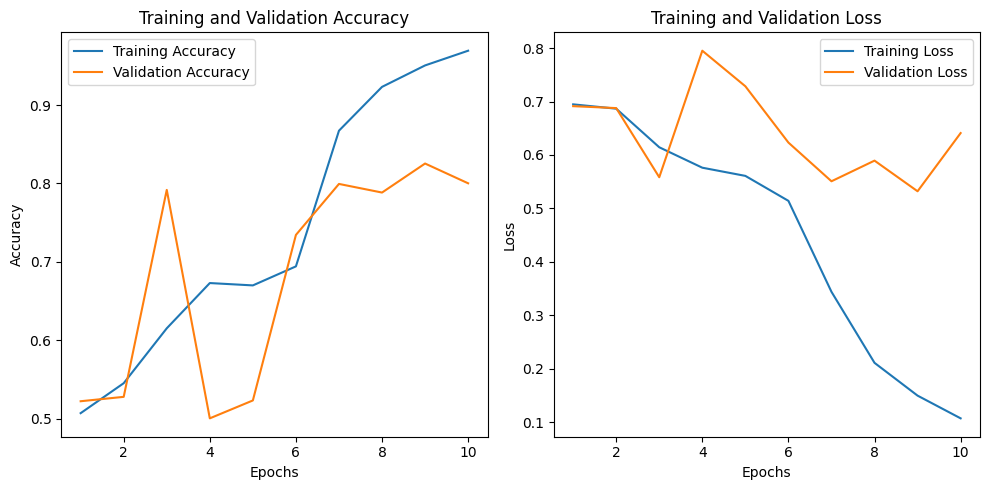

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Les r√©sultats montrent une am√©lioration claire avec l'utilisation des LSTM par rapport aux SimpleRNN

. R√©sultats obtenus avec LSTM :
Accuracy d'entra√Ænement : Passe de 50% √† 97.25% ‚Üí Le mod√®le parvient √† apprendre les relations dans les donn√©es d'entra√Ænement.
Accuracy de validation : Atteint 82.54% (meilleur r√©sultat obtenu jusqu'ici).
Validation loss :
√Ä l'√©poque 3 : Baisse significative √† 0.5583.
Puis fluctue l√©g√®rement mais reste bien inf√©rieure aux valeurs observ√©es avec SimpleRNN.
Interpr√©tation :
Les LSTM r√©solvent le probl√®me du vanishing gradient en capturant les d√©pendances √† long terme dans les s√©quences. Cela permet au mod√®le d'apprendre efficacement sur les critiques IMDb.

R√©solution du vanishing gradient :

Les LSTM utilisent des portes (input, forget et output gates) pour stocker et g√©rer les informations pertinentes sur de longues s√©quences.
Cela permet d'apprendre les relations √† long terme pr√©sentes dans les critiques IMDb.
Performance globale :

Le mod√®le parvient √† apprendre des donn√©es d'entra√Ænement, avec une validation accuracy de 82.54%.
Cela montre que le mod√®le g√©n√©ralise mieux sur les donn√©es de validation.
Stabilit√© des courbes de loss et d'accuracy :

La loss d'entra√Ænement diminue constamment.
La loss de validation est bien plus basse que pr√©c√©demment, malgr√© quelques oscillations (possiblement dues √† un surapprentissage l√©ger √† la fin).

Surapprentissage potentiel :

Vers les derni√®res √©poques, l'accuracy d'entra√Ænement atteint 97% tandis que celle de validation plafonne autour de 82-83%.
Cela pourrait indiquer un d√©but de surapprentissage.
Solution : Ajouter davantage de Dropout ou utiliser une r√©gularisation L2.

De plus on voit une l√©g√®re fluctuation dans la validation loss : il faut r√©duire un peu le learning rate.

. R√©capitulatif du probl√®me actuel :
Performances :

L'accuracy d'entra√Ænement atteint 97% ‚Üí preuve que le mod√®le apprend bien sur les donn√©es d'entra√Ænement.
L'accuracy de validation plafonne autour de 80-82% ‚Üí il reste une marge d'am√©lioration.
Overfitting :

La validation loss recommence √† augmenter apr√®s certaines √©poques, tandis que la loss d'entra√Ænement continue de diminuer.
Cela montre que le mod√®le commence √† surapprendre les sp√©cificit√©s de l'entra√Ænement, ce qui nuit √† sa capacit√© de g√©n√©ralisation.


Pourquoi ajouter des couches Dense peut aider ?
Am√©liorer la capacit√© de d√©cision :

La couche LSTM produit une sortie de taille fixe (par exemple, (batch_size, 128) dans ton mod√®le).
Ajouter des couches Dense permet de traiter cette sortie pour capturer des relations non lin√©aires et cr√©er des combinaisons plus complexes des caract√©ristiques apprises par LSTM.
Cela aide √† mieux s√©parer les classes positives et n√©gatives.
Augmenter la flexibilit√© du mod√®le :

Une Dense Layer ajoute plus de param√®tres (poids) au mod√®le, ce qui peut am√©liorer sa capacit√© √† mod√©liser des motifs complexes.
Contr√¥le fin des sorties :

Une derni√®re couche Dense avec activation sigmoid est n√©cessaire pour produire la probabilit√© d'une classe dans une t√¢che binaire.
Ajouter une ou deux couches Dense interm√©diaires peut affiner cette sortie.
Avantages d'une couche Dense suppl√©mentaire :
Meilleure g√©n√©ralisation si bien r√©gularis√©e (Dropout, L2).
R√©duction de l‚Äôerreur de classification gr√¢ce √† une meilleure capacit√© d'apprentissage.
Combinaison des caract√©ristiques g√©n√©r√©es par LSTM de mani√®re plus efficace.

En combinant ces techniques, tu vas :

Am√©liorer les performances globales gr√¢ce aux embeddings pr√©-entra√Æn√©s et aux couches Dense.
R√©duire l'overfitting avec Dropout, L2 et EarlyStopping.
Stabiliser l'entra√Ænement en ajustant le learning rate et le batch size.

ajouter une deuxi√®me couche LSTM peut potentiellement am√©liorer les performances, mais ce n'est pas la priorit√© absolue dans ton cas. Voici pourquoi :

1. Pourquoi ajouter une couche LSTM pourrait aider ?
Apprentissage de repr√©sentations plus complexes :

La premi√®re couche LSTM capture des d√©pendances locales dans les s√©quences (par exemple, des relations de mots proches dans une phrase).
Une deuxi√®me couche LSTM peut apprendre des repr√©sentations plus abstraites ou globales √† partir de la sortie de la premi√®re couche.
Am√©lioration des performances :

Une architecture plus profonde permet au r√©seau de mieux mod√©liser des patterns complexes dans les critiques IMDb.
Meilleure capacit√© de g√©n√©ralisation :

Avec une r√©gularisation appropri√©e (Dropout, L2), une couche LSTM suppl√©mentaire peut aider √† r√©duire l'erreur de validation.
2. Pourquoi ce n'est pas une priorit√© absolue ?
Overfitting encore pr√©sent :

Avec une seule couche LSTM, ton mod√®le atteint d√©j√† 97% d'accuracy en entra√Ænement mais 82% en validation.
Cela montre que ton mod√®le commence d√©j√† √† sur-apprendre, ce qui limite sa capacit√© √† g√©n√©raliser.
Complexit√© accrue :

Une deuxi√®me couche LSTM ajoutera davantage de param√®tres et augmentera le risque de surapprentissage si la r√©gularisation n'est pas suffisante.


On veut pas pour l'instant augmenter la compl√©xit√© du mod√®le.

Affiner les repr√©sentations extraites par la LSTM :

La LSTM extrait des caract√©ristiques temporelles complexes des s√©quences.
Ajouter des couches Dense permet de comprimer et combiner ces caract√©ristiques pour am√©liorer la capacit√© de d√©cision du mod√®le.
R√©gularisation pour r√©duire l'overfitting :

Le Dropout et la r√©gularisation L2 limitent le risque d‚Äôoverfitting en :
R√©duisant la complexit√© du mod√®le.
For√ßant le mod√®le √† g√©n√©raliser en d√©sactivant al√©atoirement des neurones ou en p√©nalisant les poids excessifs.
Optimisation du learning rate :

Un learning rate adapt√© permet au mod√®le de converger plus efficacement.
Si le learning rate est trop √©lev√©, l‚Äôentra√Ænement peut osciller ou diverger.
S‚Äôil est trop faible, le mod√®le peut sous-apprendre.

Deux couches Dense ajout√©es pour affiner les repr√©sentations.
Dropout apr√®s chaque couche pour r√©gulariser et √©viter l‚Äôoverfitting.
R√©gularisation L2 pour limiter les poids excessifs.
Learning rate optimis√© (0.0005) pour stabiliser la convergence.
EarlyStopping ajout√© pour arr√™ter l'entra√Ænement lorsque la validation loss ne s'am√©liore plus.

Vu qu'on a ajouter de l'early stopping on peut mettre plus d'√©pochs

 Mettre en place un Early Stopping
Pourquoi : Arr√™ter l'entra√Ænement automatiquement lorsque la validation loss ne s'am√©liore plus. Cela √©vite de suradapter le mod√®le.
Comment : Ajouter le callback EarlyStopping.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Param√®tres
dropout_rate = 0.5  # Taux de dropout
l2_reg = 0.01       # R√©gularisation L2
learning_rate = 0.0005  # Learning rate ajust√©

# Mod√®le avec couches Dense, Dropout et r√©gularisation L2
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    LSTM(128, return_sequences=False),
    Dropout(dropout_rate),  # Dropout apr√®s LSTM
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),  # Premi√®re couche Dense
    Dropout(dropout_rate),  # Dropout pour r√©gulariser
    Dense(32, activation='relu', kernel_regularizer=l2(l2_reg)),  # Deuxi√®me couche Dense
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])


# Force la construction du mod√®le avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec un learning rate optimis√©
model.compile(optimizer=Adam(learning_rate=learning_rate),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Affichage du r√©sum√© du mod√®le
model.summary()

# Entra√Ænement avec EarlyStopping pour surveiller l'overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Autoriser plus d'√©poques avec EarlyStopping
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)


Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_3 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_3 (LSTM)                        ‚îÇ (1, 128)                    ‚îÇ         117,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)                  ‚îÇ (1, 128)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                      ‚îÇ (1, 64)                     ‚îÇ           8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)                  ‚îÇ (1, 64)                     ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ (1, 32)                     ‚îÇ           2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                      ‚îÇ (1, 1)                      ‚îÇ              33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,127,617 (4.30 MB)

 Trainable params: 1,127,617 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 17ms/step - accuracy: 0.5020 - loss: 1.4940 - val_accuracy: 0.4970 - val_loss: 0.7905
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 14ms/step - accuracy: 0.5016 - loss: 0.7492 - val_accuracy: 0.4970 - val_loss: 0.6982
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 14ms/step - accuracy: 0.4884 - loss: 0.6960 - val_accuracy: 0.4970 - val_loss: 0.6934
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 14ms/step - accuracy: 0.4965 - loss: 0.6933 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 14ms/step - accuracy: 0.4970 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6932
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 16ms/step - accuracy: 0.4979 - loss: 0.6932 - val_accuracy: 0.4970 - val

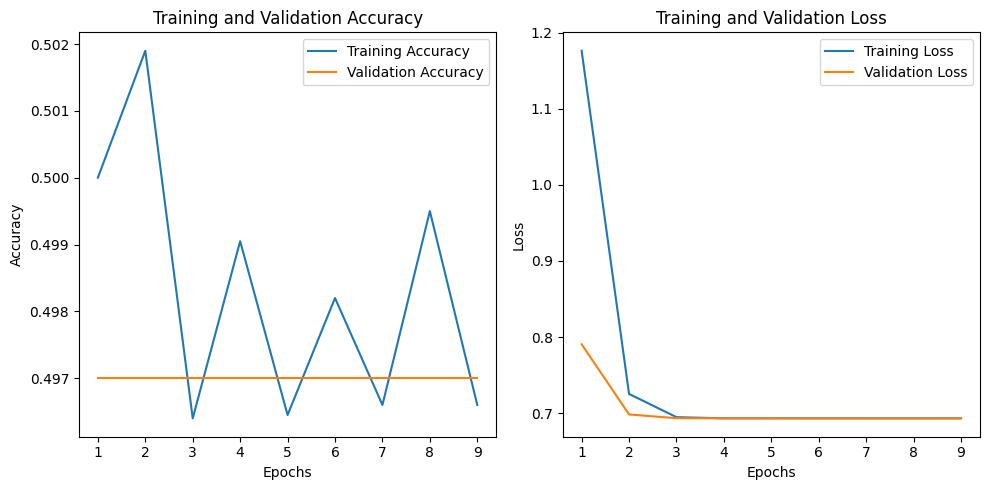

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

LSTM extrait les caract√©ristiques temporelles des s√©quences.
Dense (64) affine les caract√©ristiques extraites en ajoutant de la non-lin√©arit√©.
Dense (32) continue √† affiner les relations entre les caract√©ristiques.
Dropout r√©gularise les couches pour √©viter le surapprentissage.
La Dense finale avec activation sigmoid produit la probabilit√© d'une classe.

Maintenant avec les couches Dense ajout√©es :
Accuracy d'entra√Ænement : Stagne autour de 50%.
Accuracy de validation : Bloqu√©e √† 50%.
Loss : Stagne autour de 0.6932, ce qui correspond √† des pr√©dictions al√©atoires.
Conclusion : Le mod√®le n‚Äôapprend plus rien. Les nouvelles couches Dense n‚Äôont pas permis d'am√©liorer les performances.

2. Qu‚Äôavons-nous tent√© d‚Äôam√©liorer ?
Affiner les repr√©sentations avec les couches Dense :

Cela n'a pas fonctionn√© car le probl√®me principal ne vient pas de la capacit√© de d√©cision finale mais de l‚Äôentr√©e et de l‚Äôapprentissage des relations dans les s√©quences.
R√©gularisation (Dropout et L2) pour limiter l‚Äôoverfitting :

Le surapprentissage a √©t√© supprim√©, mais au prix de performances nulles : le mod√®le n‚Äôapprend rien du tout.
Optimisation du learning rate :

L'effet n‚Äôest pas notable, probablement parce que les repr√©sentations d‚Äôentr√©e (Embeddings) sont insuffisantes.

Surapprentissage : Les performances sur l‚Äôensemble d‚Äôentra√Ænement et de validation sont d√©sormais align√©es. Cependant, cela signifie que le mod√®le ne parvient plus √† apprendre.

La stagnation √† 50% d‚Äôaccuracy montre que le mod√®le ne capture aucune information utile des s√©quences.
Cela peut √™tre d√ª √† des embeddings inefficaces ou √† une structure trop r√©gularis√©e.
Manque de repr√©sentations d‚Äôentr√©e de qualit√© :

L‚ÄôEmbedding actuel est appris √† partir de z√©ro sur ton dataset IMDb. Cela n√©cessite beaucoup de donn√©es et d‚Äô√©poques pour produire des repr√©sentations utiles.
Manque de capacit√© dans la LSTM :

Une seule couche LSTM avec 128 unit√©s peut √™tre insuffisante pour apprendre des relations complexes dans des critiques IMDb.

Au bilan :
Avant avec une seule couche LSTM :

Pr√©cision √©lev√©e sur l‚Äôensemble d‚Äôentra√Ænement (97%) mais overfitting marqu√© (validation √† 82%).
Cela montrait que le mod√®le avait la capacit√© d‚Äôapprendre, mais il se concentrait trop sur les donn√©es d‚Äôentra√Ænement.
Maintenant avec des couches Dense et r√©gularisation :

Overfitting supprim√©, mais plus d‚Äôapprentissage ‚Üí les performances stagnent √† 50%.
Cela signifie que la r√©gularisation a trop limit√© la capacit√© du mod√®le √† apprendre.

e probl√®me actuel vient principalement des entr√©es : la couche Embedding apprend depuis z√©ro. Cela est inefficace et demande beaucoup de donn√©es pour produire des repr√©sentations utiles.
Les embeddings pr√©-entra√Æn√©s comme GloVe ou Word2Vec fournissent des repr√©sentations s√©mantiques riches et permettent au mod√®le d‚Äôapprendre plus rapidement et de mieux g√©n√©raliser.
Pourquoi ajouter une couche LSTM n‚Äôest pas la priorit√© ?

Une deuxi√®me couche LSTM ajouterait de la complexit√© mais ne r√©soudrait pas le probl√®me fondamental des mauvaises repr√©sentations d'entr√©e.
Une fois que les embeddings pr√©-entra√Æn√©s sont int√©gr√©s, on pourra d√©cider si une deuxi√®me couche LSTM est n√©cessaire.

### Utilisation d'Embeddings pr√©-entrain√©s

L‚Äôutilisation d‚Äôembeddings pr√©-entra√Æn√©s, comme GloVe, peut √™tre tr√®s b√©n√©fique ici. GloVe (Global Vectors for Word Representation) et Word2Vec sont des mod√®les pr√©-entra√Æn√©s qui transforment les mots en vecteurs num√©riques en capturant leurs relations s√©mantiques.
Ces embeddings sont appris √† partir de vastes corpus de texte g√©n√©ral, comme Wikipedia ou Common Crawl, et contiennent une repr√©sentation riche du langage.
Les embeddings pr√©-entra√Æn√©s permettent √† votre mod√®le de b√©n√©ficier d‚Äôune compr√©hension linguistique initiale, sans avoir besoin de r√©apprendre ces relations depuis z√©ro.
Cela est particuli√®rement utile si votre dataset est petit ou mod√©r√©ment grand (comme IMDb avec 25 000 critiques).
Capture des relations s√©mantiques complexes :

Par exemple, des mots comme good et great seront proches dans l‚Äôespace vectoriel, ce qui aide le mod√®le √† mieux comprendre le contexte des sentiments.
R√©duction du surapprentissage :

En utilisant des embeddings fixes (non entra√Ænables), vous r√©duisez le risque que le mod√®le sur-apprenne les relations sp√©cifiques √† votre dataset.d√©marrez avec des vecteurs qui capturent les relations s√©mantiques g√©n√©rales, acc√©l√©rant l‚Äôentra√Ænement.
Vous am√©liorez les performances sur des mots non fr√©quents ou sp√©cifiques au dataset IMDb.
Vous r√©duisez la d√©pendance aux donn√©es annot√©es.

GloVe est un mod√®le bas√© sur les cooccurrences globales des mots dans un corpus. Il analyse combien de fois deux mots apparaissent ensemble dans une m√™me fen√™tre contextuelle, sur l‚Äôensemble du corpus.
Repr√©sentation s√©mantique globale : Il capture √† la fois les relations locales et globales entre les mots, gr√¢ce √† sa construction par cooccurrences.
Fichiers disponibles : GloVe fournit des fichiers d‚Äôembeddings pr√©-entra√Æn√©s sur de tr√®s grands corpus publics (Wikipedia, Common Crawl, etc.), ce qui le rend pr√™t √† l‚Äôemploi.

Les fichiers GloVe pr√©-entra√Æn√©s sont directement t√©l√©chargeables, pr√™ts √† l‚Äôemploi, et largement utilis√©s pour des t√¢ches NLP g√©n√©rales comme la sentiment analysis.
GloVe excelle √† capturer des relations globales entre les mots. Par exemple, il repr√©sente efficacement des relations analogiques comme‚ÄØ:
"good" est √† "better" ce que "bad" est √† "worse".
Ces relations globales sont utiles pour d√©tecter des nuances dans les sentiments des critiques.

GloVe est souvent plus rapide et n√©cessite moins de ressources computationnelles, car il repose sur des matrices statiques de cooccurrence.

Les embeddings pr√©-entra√Æn√©s sont g√©n√©ralement meilleurs pour capturer les relations entre mots que les embeddings appris √† partir de z√©ro sur un dataset de taille mod√©r√©e (comme IMDb avec 25 000 critiques).
Les embeddings pr√©-entra√Æn√©s permettent de mieux g√©n√©raliser, m√™me avec des datasets relativement petits.

En fixant les poids de la matrice d‚Äôembedding, on emp√™che le mod√®le de modifier les vecteurs durant l‚Äôentra√Ænement.
Cela garantit que les relations linguistiques g√©n√©rales, captur√©es lors de l‚Äôentra√Ænement de GloVe sur des corpus massifs, restent intactes.
R√©duction du risque de surapprentissage :
Geler les poids r√©duit le nombre de param√®tres entra√Ænables, acc√©l√©rant l‚Äôentra√Ænement et diminuant les besoins en ressources.

In [ ]:
import os
import urllib.request
import zipfile

# Cr√©er un dossier pour stocker les embeddings
glove_dir = 'glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# T√©l√©charger GloVe 6B (100 dimensions)
url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

if not os.path.exists(glove_zip_path):
    print("T√©l√©chargement des embeddings GloVe...")
    urllib.request.urlretrieve(url, glove_zip_path)
    print("T√©l√©chargement termin√©.")

# Extraire le fichier zip
print("Extraction des fichiers GloVe...")
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall(glove_dir)

print("Extraction termin√©e. Les fichiers sont disponibles dans :", glove_dir)


T√©l√©chargement des embeddings GloVe...
T√©l√©chargement termin√©.
Extraction des fichiers GloVe...
Extraction termin√©e. Les fichiers sont disponibles dans : glove


In [ ]:
import numpy as np

# Chemin vers le fichier GloVe
glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

# Charger les embeddings GloVe dans un dictionnaire
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # Le mot
        coefs = np.asarray(values[1:], dtype='float32')  # Le vecteur d'embedding
        embedding_index[word] = coefs

print(f"Nombre d'embeddings charg√©s : {len(embedding_index)}")

# Cr√©er la matrice d'embeddings pour ton vocabulaire
embedding_dim = 100  # Taille des vecteurs GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Matrice d'embeddings GloVe construite avec succ√®s.")


Nombre d'embeddings charg√©s : 400000
Matrice d'embeddings GloVe construite avec succ√®s.


Embeddings pr√©-entra√Æn√©s (GloVe) :

Les poids de la couche Embedding sont initialis√©s avec la matrice GloVe.
trainable=False permet d‚Äôutiliser ces embeddings tels quels pour stabiliser l‚Äôapprentissage.
Architecture avec LSTM + Dense :

LSTM : Capture les d√©pendances temporelles dans les critiques IMDb.
Couches Dense : Affinent les caract√©ristiques extraites.
Dropout : R√©gularisation pour r√©duire l'overfitting.
R√©gularisation L2 : Ajout√©e aux couches Dense pour contr√¥ler la complexit√© des poids.
EarlyStopping :

Surveille la validation loss et arr√™te l‚Äôentra√Ænement si elle ne s‚Äôam√©liore pas pendant 3 √©poques cons√©cutives.
Learning rate ajust√© :

Un learning rate de 0.0005 stabilise l‚Äôapprentissage et √©vite les oscillations.

In [ ]:
from collections import Counter
from nltk.corpus import stopwords
import nltk

# T√©l√©charger les stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Fusionner toutes les critiques en un seul corpus
all_reviews = " ".join(train_texts_cleaned + test_texts_cleaned)
words = all_reviews.split()

# Filtrer les mots pour exclure les stopwords et les mots courts
filtered_words = [word for word in words if word.lower() not in stop_words and len(word) > 2]

# Compter les mots
word_counts = Counter(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# V√©rifier la couverture du vocabulaire IMDb dans GloVe
glove_vocab = set(embedding_index.keys())  # Vocabulaire de GloVe
imdb_vocab = set(word_counts.keys())      # Vocabulaire du dataset IMDb

# Proportion de mots IMDb pr√©sents dans GloVe
coverage = len(imdb_vocab & glove_vocab) / len(imdb_vocab) * 100
print(f"Proportion du vocabulaire IMDb couvert par GloVe : {coverage:.2f}%")

Proportion du vocabulaire IMDb couvert par GloVe : 33.70%


On voit que seulement un tiers de notre vocabulaire est couvert par GloVe. Cela aura surement un impact sur les pr√©dictions.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# D√©finir le mod√®le avec les embeddings GloVe
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=False),  # Fixe les embeddings pour √©viter d'apprendre de z√©ro
    LSTM(128, return_sequences=False),  # Couche LSTM
    Dropout(0.5),  # R√©gularisation
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense
    Dropout(0.5),  # Dropout pour √©viter l'overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense interm√©diaire
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])

# Force la construction du mod√®le avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec learning rate ajust√©
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Afficher le r√©sum√©
model.summary()

# Entra√Æner le mod√®le
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'√©poques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


Model: "sequential_6"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_6 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_6 (LSTM)                        ‚îÇ (1, 128)                    ‚îÇ         117,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_9 (Dropout)                  ‚îÇ (1, 128)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_12 (Dense)                     ‚îÇ (1, 64)                     ‚îÇ           8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_10 (Dropout)                 ‚îÇ (1, 64)                     ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_13 (Dense)                     ‚îÇ (1, 32)                     ‚îÇ           2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_14 (Dense)                     ‚îÇ (1, 1)                      ‚îÇ              33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,127,617 (4.30 MB)

 Trainable params: 127,617 (498.50 KB)

 Non-trainable params: 1,000,000 (3.81 MB)

Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 14ms/step - accuracy: 0.5058 - loss: 1.5145 - val_accuracy: 0.5008 - val_loss: 0.8187
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 13ms/step - accuracy: 0.5003 - loss: 0.7699 - val_accuracy: 0.5060 - val_loss: 0.7029
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 17ms/step - accuracy: 0.5140 - loss: 0.6994 - val_accuracy: 0.4982 - val_loss: 0.6941
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 13ms/step - accuracy: 0.5209 - loss: 0.6935 - val_accuracy: 0.5114 - val_loss: 0.6983
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 13ms/step - accuracy: 0.5192 - loss: 0.6927 - val_accuracy: 0.5030 - val_loss: 0.6931
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 17ms/step - accuracy: 0.5012 - loss: 0.6926 - val_accuracy: 0.5072 - val

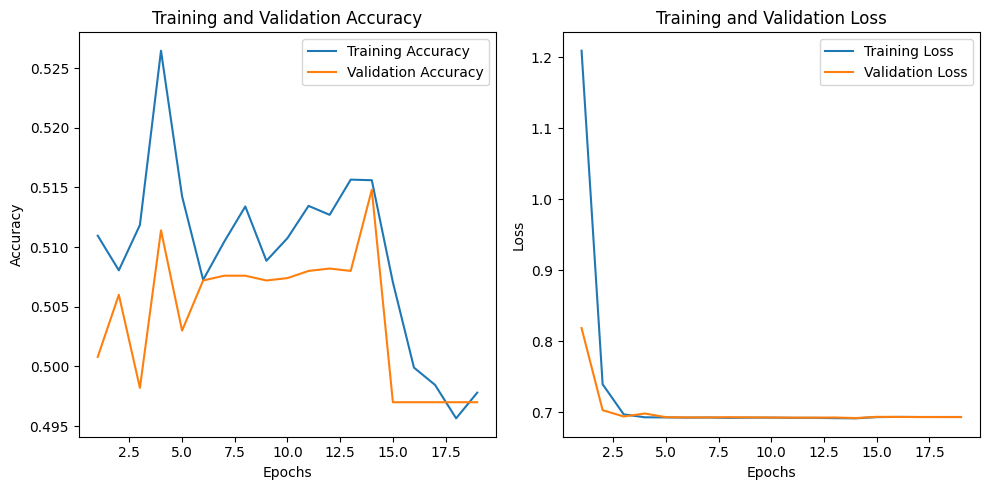

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Prochaines √©tapes apr√®s analyse :
Si les performances s‚Äôam√©liorent mais stagnent encore :
Envisager une seconde couche LSTM pour capturer des caract√©ristiques plus profondes.
Si les embeddings GloVe am√©liorent beaucoup les r√©sultats :
Envisager de fine-tuner les embeddings (les rendre trainable=True).

Les r√©sultats montrent encore une stagnation autour d‚Äôune accuracy proche de 50% et une loss autour de 0.692, ce qui est caract√©ristique d‚Äôun mod√®le qui n‚Äôapprend pas ou peu. Comparons cela aux attentes et aux r√©sultats pr√©c√©dents.

Embeddings fig√©s (trainable=False) :

En fixant les poids des embeddings GloVe (trainable=False), le mod√®le utilise les repr√©sentations telles quelles.
Cependant, ces repr√©sentations peuvent ne pas √™tre parfaitement adapt√©es √† ton dataset IMDb (sentiments dans les critiques de films), car GloVe a √©t√© entra√Æn√© sur des donn√©es g√©n√©rales comme Wikipedia.


Une seule couche LSTM peut ne pas suffire pour exploiter efficacement les repr√©sentations fournies par GloVe.
Une deuxi√®me couche LSTM peut aider √† apprendre des relations plus complexes et hi√©rarchiques.

Si les embeddings GloVe sont rendus entra√Ænables (trainable=True), le mod√®le pourra les ajuster pour mieux s‚Äôadapter au vocabulaire et aux relations sp√©cifiques du dataset IMDb.
Cela r√©sout le probl√®me des repr√©sentations fixes qui ne capturent pas forc√©ment les nuances de sentiment dans tes donn√©es.


Ajouter une deuxi√®me couche LSTM est une bonne id√©e, mais moins prioritaire que de rendre les embeddings GloVe entra√Ænables. Pourquoi ?

Les embeddings d‚Äôentr√©e sont la base du mod√®le. Si cette base est mauvaise ou inadapt√©e, m√™me une architecture plus complexe (avec une deuxi√®me LSTM) ne pourra pas r√©soudre le probl√®me.

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam


# D√©finir le mod√®le avec les embeddings GloVe
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Fixe les embeddings pour √©viter d'apprendre de z√©ro
    LSTM(128, return_sequences=False),  # Couche LSTM
    Dropout(0.5),  # R√©gularisation
    Dense(64, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense
    Dropout(0.5),  # Dropout pour √©viter l'overfitting
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense interm√©diaire
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])

# Force la construction du mod√®le avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec learning rate ajust√©
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Afficher le r√©sum√©
model.summary()

# Entra√Æner le mod√®le
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'√©poques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_7"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_7 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_7 (LSTM)                        ‚îÇ (1, 128)                    ‚îÇ         117,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_11 (Dropout)                 ‚îÇ (1, 128)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_15 (Dense)                     ‚îÇ (1, 64)                     ‚îÇ           8,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_12 (Dropout)                 ‚îÇ (1, 64)                     ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_16 (Dense)                     ‚îÇ (1, 32)                     ‚îÇ           2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_17 (Dense)                     ‚îÇ (1, 1)                      ‚îÇ              33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 1,127,617 (4.30 MB)

 Trainable params: 1,127,617 (4.30 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 17ms/step - accuracy: 0.5068 - loss: 1.5070 - val_accuracy: 0.5456 - val_loss: 0.8156
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 15ms/step - accuracy: 0.5173 - loss: 0.7681 - val_accuracy: 0.4970 - val_loss: 0.7035
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 14ms/step - accuracy: 0.5061 - loss: 0.6992 - val_accuracy: 0.5118 - val_loss: 0.6937
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 15ms/step - accuracy: 0.5129 - loss: 0.6932 - val_accuracy: 0.4970 - val_loss: 0.6938
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.5025 - loss: 0.6935 - val_accuracy: 0.4970 - val_loss: 0.6933
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 14ms/step - accuracy: 0.5027 - loss: 0.6932 - val_accuracy: 0.4970 - va

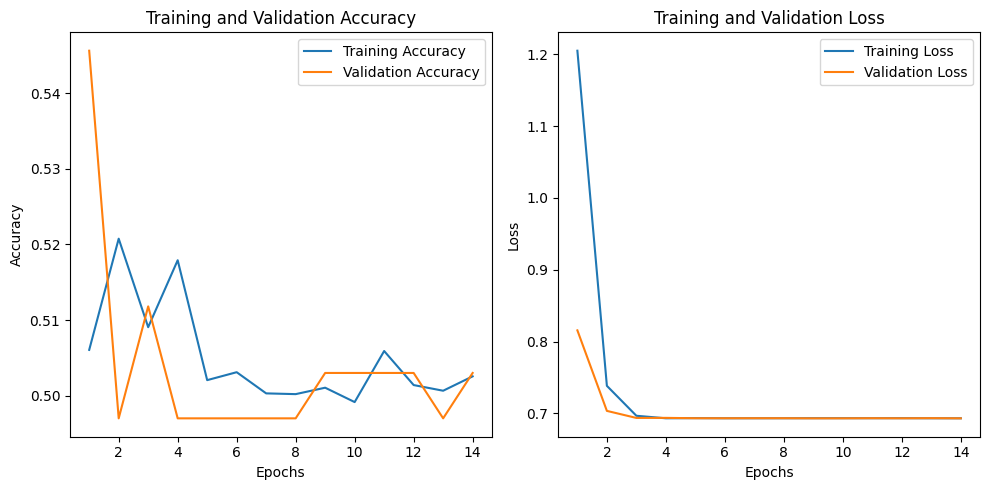

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

A. Mauvais apprentissage des embeddings
M√™me en rendant les embeddings GloVe entra√Ænables, les performances n'am√©liorent pas car le mod√®le :
Sous-apprend : Il ne trouve pas de motifs utiles dans les donn√©es d'entr√©e.
Est mal initialis√© : Les poids de d√©part (GloVe) peuvent √™tre trop √©loign√©s des besoins sp√©cifiques de la t√¢che IMDb.
B. Trop de r√©gularisation
Avec du Dropout (0.5) et de la r√©gularisation L2, on limite fortement la capacit√© d‚Äôapprentissage du mod√®le.
Cela peut "sur-r√©gulariser" le mod√®le, l'emp√™chant d‚Äôapprendre quoi que ce soit, m√™me avec des embeddings ajustables.
C. Complexit√© inutile
Ajouter trop de couches Dense apr√®s la LSTM peut compliquer le mod√®le sans fournir de gain r√©el.
Si la LSTM ne capture pas d√©j√† des informations pertinentes, les couches Dense ne peuvent rien am√©liorer.

Puisque les meilleures performances ont √©t√© obtenues avec :

Une seule couche LSTM sans Dense,
Pas de r√©gularisation excessive,
Il est temps de simplifier l'architecture pour redonner sa capacit√© d'apprentissage au mod√®le.

Revenir aux bases : Les r√©sultats initiaux avec une LSTM seule √©taient les meilleurs.
√âviter la sur-r√©gularisation : Les couches Dense et la r√©gularisation excessive bloquent le mod√®le.
Embeddings GloVe entra√Ænables : Ils offrent une base solide mais doivent √™tre ajust√©s progressivement.

Elle combine la meilleure configuration initiale (LSTM simple) avec les embeddings GloVe ajustables.
Le Dropout mod√©r√© et EarlyStopping aident √† limiter l‚Äôoverfitting sans bloquer la capacit√© d‚Äôapprentissage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Mod√®le simplifi√©
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe entra√Ænables
    LSTM(128, return_sequences=False),  # Couche LSTM unique
    Dropout(0.3),  # Dropout mod√©r√©
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Force la construction du mod√®le avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation du mod√®le
model.compile(optimizer=Adam(learning_rate=0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping pour surveiller la validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Entra√Ænement avec EarlyStopping
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Maximum de 20 epochs
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],  # EarlyStopping
    verbose=1
)

Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 15ms/step - accuracy: 0.5341 - loss: 0.6899 - val_accuracy: 0.5490 - val_loss: 0.6795
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 17ms/step - accuracy: 0.5682 - loss: 0.6756 - val_accuracy: 0.5120 - val_loss: 0.6738
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 13ms/step - accuracy: 0.5373 - loss: 0.6927 - val_accuracy: 0.5336 - val_loss: 0.6899
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 14ms/step - accuracy: 0.5287 - loss: 0.6919 - val_accuracy: 0.5382 - val_loss: 0.6866
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 17ms/step - accuracy: 0.5630 - loss: 0.6784 - val_accuracy: 0.6388 - val_loss: 0.6347
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 13ms/step - accuracy: 0.6109 - loss: 0.6652 - val_accuracy: 0.7608 - val

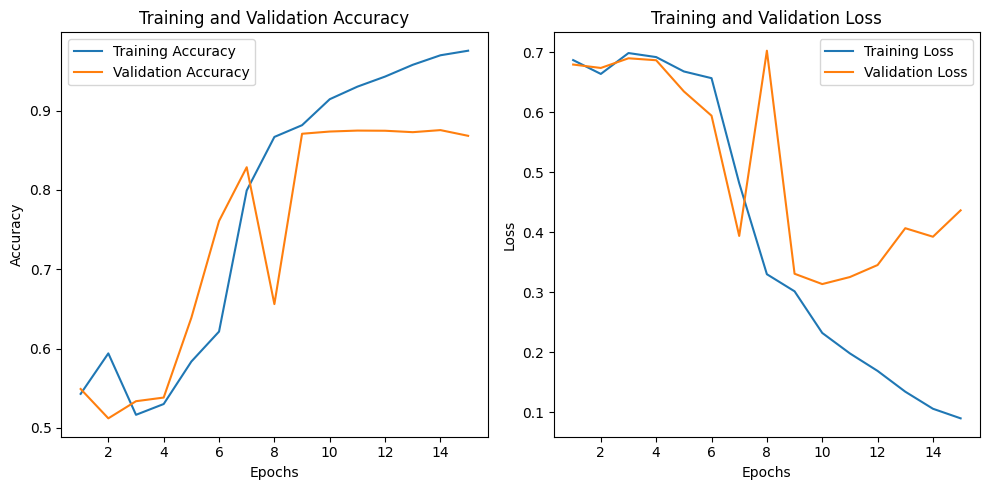

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Ce qui a bien fonctionn√© :
GloVe entra√Ænable :

En rendant les embeddings GloVe ajustables, le mod√®le a pu adapter les repr√©sentations des mots pour mieux correspondre aux nuances de sentiment sp√©cifiques du dataset IMDb.
Cela a r√©solu le probl√®me des embeddings fixes qui n‚Äôapportaient pas de gain.
Simplification de l'architecture :

Une seule couche LSTM (128 unit√©s) sans couches Dense suppl√©mentaires a permis au mod√®le de se concentrer sur l‚Äôextraction des d√©pendances temporelles sans ajouter une complexit√© inutile.
Cela a √©vit√© le blocage de l‚Äôapprentissage observ√© auparavant.
Dropout mod√©r√© (0.3) :

Le Dropout a r√©ussi √† limiter l‚Äôoverfitting tout en permettant un apprentissage efficace.
L‚Äôaccuracy en validation atteint 87.5%, une am√©lioration claire par rapport aux 82% initiaux.
EarlyStopping :

L‚Äôentra√Ænement s‚Äôest arr√™t√© avant que l‚Äôoverfitting devienne trop important, permettant au mod√®le de g√©n√©raliser au mieux sur l‚Äôensemble de validation.

Surapprentissage vers la fin :

L‚Äôaccuracy d‚Äôentra√Ænement atteint 97-98% tandis que l‚Äôaccuracy de validation plafonne autour de 87-88%.
La validation loss augmente l√©g√®rement apr√®s un certain nombre d‚Äô√©poques, indiquant un d√©but de surapprentissage.
Performance plafonn√©e en validation :

Bien que 87.5% soit un bon r√©sultat, il reste un √©cart entre l‚Äôaccuracy d‚Äôentra√Ænement et de validation.
Cela sugg√®re que le mod√®le pourrait encore mieux g√©n√©raliser avec des ajustements suppl√©mentaires.

A. Augmenter l√©g√®rement le Dropout
Actuellement √† 0.3, augmenter le Dropout √† 0.4 pour renforcer la r√©gularisation et limiter davantage l‚Äôoverfitting.

B. Ajouter un petit L2 regularizer √† la LSTM
La r√©gularisation L2 sur la LSTM peut aider √† r√©duire la complexit√© du mod√®le en p√©nalisant les poids excessifs.

C. R√©duire l√©g√®rement le learning rate
R√©duire le learning rate (actuellement 0.0005) √† 0.0003 pour stabiliser l‚Äôentra√Ænement en fin de parcours. Cela peut √©viter que la validation loss remonte.


Embeddings GloVe entra√Ænables :
Les repr√©sentations des mots s‚Äôadaptent sp√©cifiquement √† la t√¢che IMDb.

R√©gularisation L2 sur la LSTM :
Cela contr√¥le la complexit√© des poids de la LSTM et √©vite une croissance excessive.

Augmentation du Dropout :
Le Dropout √† 0.4 limite davantage le surapprentissage tout en laissant suffisamment de capacit√© d‚Äôapprentissage.

Learning rate r√©duit (0.0003) :
Cela permet une convergence plus stable et progressive, en particulier en fin d'entra√Ænement.

EarlyStopping :
Arr√™te l‚Äôentra√Ænement apr√®s 3 √©poques sans am√©lioration de la validation loss et restaure les meilleurs poids.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# D√©finition du mod√®le avec les ajustements
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # GloVe ajustable
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),  # R√©gularisation L2 sur LSTM
    Dropout(0.4),  # Dropout augment√© pour limiter l'overfitting
    Dense(1, activation='sigmoid')  # Couche de sortie binaire
])

# Force la construction du mod√®le avec un input d'exemple
model(tf.zeros((1, max_length)))

# Compilation avec un learning rate ajust√©
model.compile(optimizer=Adam(learning_rate=0.0003),  # Learning rate r√©duit
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping pour arr√™ter automatiquement l'entra√Ænement en cas de stagnation
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entra√Ænement du mod√®le
history = model.fit(
    train_padded_train, train_labels_train,  # Donn√©es d'entra√Ænement
    validation_data=(train_padded_val, train_labels_val),  # Donn√©es de validation
    epochs=20,  # Nombre d'√©poques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],  # Callback pour EarlyStopping
    verbose=1
)

# R√©sum√© du mod√®le pour v√©rification
model.summary()


Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 15ms/step - accuracy: 0.5131 - loss: 1.6875 - val_accuracy: 0.4986 - val_loss: 0.8770
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 14ms/step - accuracy: 0.5101 - loss: 0.8399 - val_accuracy: 0.4972 - val_loss: 0.8232
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 17ms/step - accuracy: 0.5334 - loss: 0.7735 - val_accuracy: 0.5820 - val_loss: 0.7324
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 17ms/step - accuracy: 0.6485 - loss: 0.7123 - val_accuracy: 0.5440 - val_loss: 0.7476
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 14ms/step - accuracy: 0.5711 - loss: 0.7337 - val_accuracy: 0.5518 - val_loss: 0.7434
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 16ms/step - accuracy: 0.5470 - loss: 0.7379 - val_accuracy: 0.5596 - val

Model: "sequential_15"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_15 (Embedding)             ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_15 (LSTM)                       ‚îÇ (1, 128)                    ‚îÇ         117,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_20 (Dropout)                 ‚îÇ (1, 128)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_25 (Dense)                     ‚îÇ (1, 1)                      ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

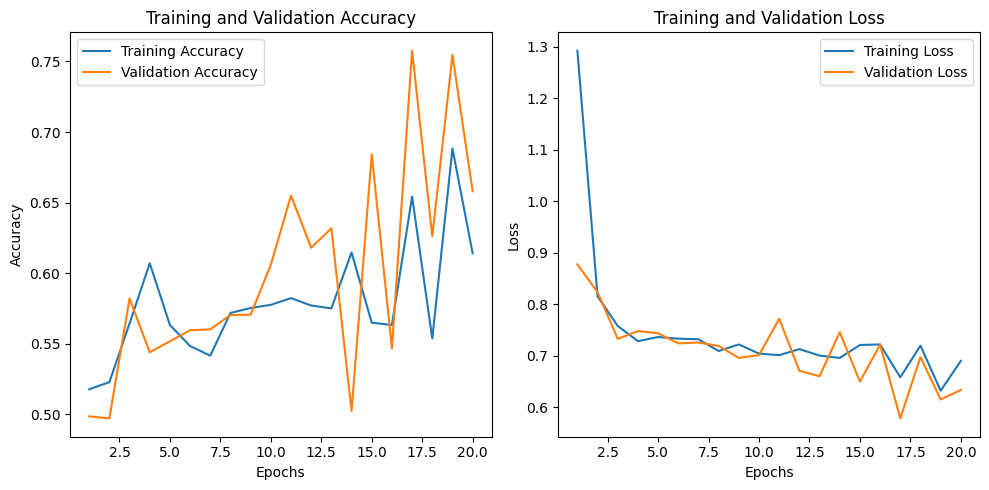

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Incoh√©rence des performances :

Les performances fluctuent d‚Äôune √©poque √† l‚Äôautre, passant de 75% en validation √† des baisses impr√©vues (50-60%).
Cela peut indiquer :
Un mod√®le sensible aux variations des poids.
Des hyperparam√®tres encore sous-optimis√©s.
Overfitting partiel :

L‚Äôaccuracy d‚Äôentra√Ænement continue d‚Äôaugmenter, tandis que la validation reste instable.
Cela signifie que le mod√®le sur-apprend certaines donn√©es d‚Äôentra√Ænement sans bien g√©n√©raliser.
Learning rate sous-optimal :

Bien que r√©duit, le learning rate (0.0003) semble ne pas √™tre assez bas pour stabiliser l‚Äôapprentissage.

Incoh√©rence des performances :

Les performances fluctuent d‚Äôune √©poque √† l‚Äôautre, passant de 75% en validation √† des baisses impr√©vues (50-60%).
Cela peut indiquer :
Un mod√®le sensible aux variations des poids.
Des hyperparam√®tres encore sous-optimis√©s.
Overfitting partiel :

L‚Äôaccuracy d‚Äôentra√Ænement continue d‚Äôaugmenter, tandis que la validation reste instable.
Cela signifie que le mod√®le sur-apprend certaines donn√©es d‚Äôentra√Ænement sans bien g√©n√©raliser.
Learning rate sous-optimal :

Bien que r√©duit, le learning rate (0.0003) semble ne pas √™tre assez bas pour stabiliser l‚Äôapprentissage.

A. R√©duire encore le learning rate
Passer de 0.0003 √† 0.0001 pour stabiliser l‚Äôoptimisation et √©viter les oscillations.
Un learning rate plus petit permet des ajustements plus fins des poids, notamment sur les embeddings.

Le Dropout 0.4 pourrait √™tre trop √©lev√© dans ce cas, r√©duisant la capacit√© d‚Äôapprentissage. On peut revenir √† 0.3.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Mod√®le ajust√©
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # GloVe ajustable
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),  # R√©gularisation L2
    Dropout(0.3),  # Dropout ajust√©
    Dense(1, activation='sigmoid')  # Couche de sortie binaire
])

# Compilation avec learning rate plus faible
model.compile(optimizer=Adam(learning_rate=0.0001),  # Learning rate r√©duit
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping avec patience plus stricte
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Entra√Ænement du mod√®le
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'√©poques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],  # EarlyStopping ajust√©
    verbose=1
)

# R√©sum√© du mod√®le pour v√©rification
model.summary()


Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 14ms/step - accuracy: 0.4994 - loss: 2.0647 - val_accuracy: 0.5348 - val_loss: 1.3697
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 14ms/step - accuracy: 0.5326 - loss: 1.2385 - val_accuracy: 0.5642 - val_loss: 0.9503
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 17ms/step - accuracy: 0.6350 - loss: 0.8864 - val_accuracy: 0.7316 - val_loss: 0.7383
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 13ms/step - accuracy: 0.6976 - loss: 0.7393 - val_accuracy: 0.6924 - val_loss: 0.7024
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 13ms/step - accuracy: 0.7249 - loss: 0.6803 - val_accuracy: 0.7766 - val_loss: 0.6112
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 17ms/step - accuracy: 0.7266 - loss: 0.6553 - val_accuracy: 0.7728 - val

Model: "sequential_16"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_16 (Embedding)             ‚îÇ (None, 200, 100)            ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_16 (LSTM)                       ‚îÇ (None, 128)                 ‚îÇ         117,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_21 (Dropout)                 ‚îÇ (None, 128)                 ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_26 (Dense)                     ‚îÇ (None, 1)                   ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 3,352,133 (12.79 MB)

 Trainable params: 1,117,377 (4.26 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,234,756 (8.52 MB)

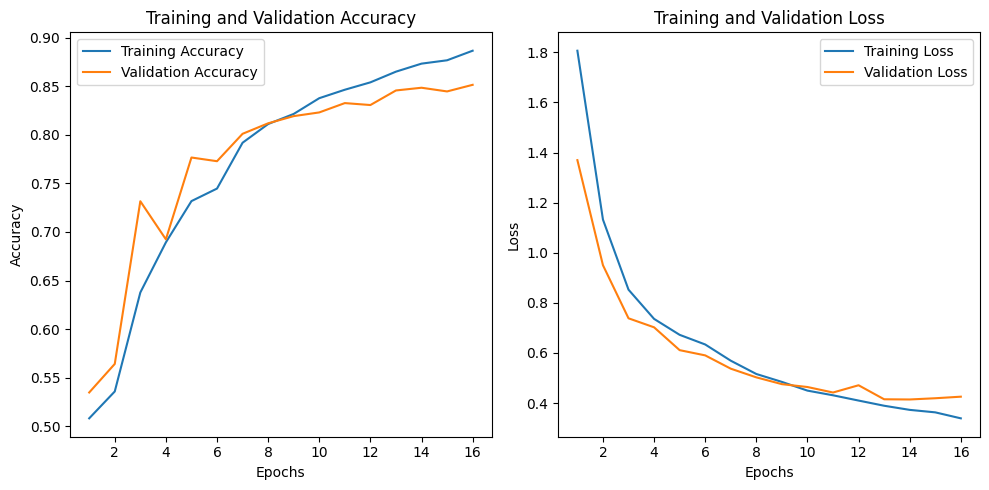

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1. R√©sultats obtenus
Accuracy d‚Äôentra√Ænement : 88.6%
Accuracy de validation : 85.1%
Validation loss : 0.42 (l√©g√®rement en hausse vers la fin).
Ces r√©sultats montrent que :

Le mod√®le apprend bien sur l‚Äôensemble d‚Äôentra√Ænement.
L‚Äôaccuracy de validation est proche de celle de l‚Äôentra√Ænement, ce qui indique peu d‚Äôoverfitting.
Les performances sont stables et bien meilleures que toutes les configurations pr√©c√©dentes.
2. Ce qui a bien fonctionn√©
Embeddings GloVe entra√Ænables :

Rendre les embeddings trainables a permis au mod√®le de s‚Äôadapter aux nuances sp√©cifiques du dataset IMDb.
Cela a fourni une base solide pour l‚Äôapprentissage des relations dans les critiques de films.
Simplification de l‚Äôarchitecture :

Une seule couche LSTM avec 128 unit√©s a suffi pour capturer les d√©pendances temporelles des donn√©es.
L‚Äô√©limination des couches Dense inutiles a permis de stabiliser l‚Äôapprentissage.
R√©gularisation √©quilibr√©e :

Le Dropout (0.3) et la r√©gularisation L2 ont limit√© l‚Äôoverfitting tout en pr√©servant la capacit√© d‚Äôapprentissage.
Learning rate optimis√© (0.0001) :

La r√©duction du learning rate a permis au mod√®le de converger lentement et efficacement, en particulier sur les derni√®res √©poques.
3. Ce qui a moyennement fonctionn√©
Validation loss en l√©g√®re augmentation :

√Ä partir de l‚Äô√©poque 14-15, la validation loss recommence l√©g√®rement √† augmenter tandis que l‚Äôaccuracy reste stable.
Cela peut indiquer un d√©but de surapprentissage l√©ger, mais les performances globales restent bonnes.
Plateau dans l‚Äôaccuracy :

L‚Äôaccuracy de validation atteint environ 85% et semble plafonner. Il est possible que la capacit√© du mod√®le soit limit√©e par la profondeur actuelle.

In [ ]:
# Sauvegarder le mod√®le complet (architecture + poids + optimiseur)
model_path = "lstm_pasmal1.h5"  # Renommer le fichier
model.save(model_path)

print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous lstm_pasmal1.h5


In [ ]:
from google.colab import files
files.download('lstm_pasmal1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

6. Priorit√© maintenant
La priorit√© est de stabiliser encore davantage les performances et d‚Äôatteindre un plateau de g√©n√©ralisation optimal.

Actions recommand√©es :
Ajouter une l√©g√®re couche Dense avec Dropout :

Une seule couche Dense de petite taille (par exemple, 32 unit√©s) pour affiner la d√©cision finale.
Ajouter un Dropout (0.3) pour √©viter le surapprentissage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Mod√®le ajust√© avec une couche Dense suppl√©mentaire
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01)),  # LSTM avec r√©gularisation L2
    Dropout(0.3),  # Dropout pour r√©gularisation
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Nouvelle couche Dense
    Dropout(0.3),  # Dropout pour r√©gularisation
    Dense(1, activation='sigmoid')  # Couche finale pour la classification
])

# Compilation avec un learning rate bas
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping ajust√©
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entra√Ænement du mod√®le
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'√©poques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 20ms/step - accuracy: 0.5046 - loss: 2.5164 - val_accuracy: 0.5322 - val_loss: 1.7008
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 15ms/step - accuracy: 0.5489 - loss: 1.5320 - val_accuracy: 0.6554 - val_loss: 1.1422
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 13ms/step - accuracy: 0.6830 - loss: 1.0609 - val_accuracy: 0.7514 - val_loss: 0.8615
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 14ms/step - accuracy: 0.7467 - loss: 0.8478 - val_accuracy: 0.7742 - val_loss: 0.7359
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.7895 - loss: 0.7016 - val_accuracy: 0.8050 - val_loss: 0.6219
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 5s 16ms/step - accuracy: 0.8111 - loss: 0.6108 - val_accuracy: 0.8154 - val_loss: 0.56

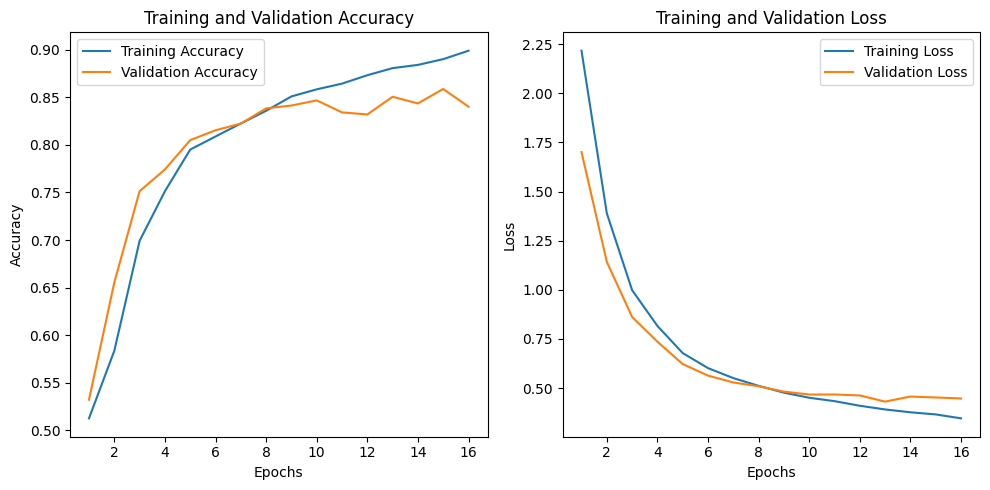

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

1. R√©sultats observ√©s
Accuracy d‚Äôentra√Ænement : 89.4%
Accuracy de validation : 85.8% (meilleur score).
Validation loss : 0.45 (relativement stable avec l√©g√®re oscillation).
2. Ce qui a bien fonctionn√©
Ajout de la couche Dense :

La petite couche Dense (32 unit√©s) a permis de comprimer et combiner les informations extraites par la LSTM.
Cela a contribu√© √† affiner les d√©cisions finales du mod√®le et √† augmenter l√©g√®rement l‚Äôaccuracy.
Embeddings GloVe entra√Ænables :

Les embeddings continuent d‚Äô√™tre un √©l√©ment crucial. Leur ajustement aux sp√©cificit√©s du dataset IMDb a permis au mod√®le de s‚Äôam√©liorer constamment.
R√©gularisation √©quilibr√©e :

Le Dropout √† 0.3 et la r√©gularisation L2 sur la LSTM ont aid√© √† limiter l‚Äôoverfitting tout en pr√©servant les capacit√©s d‚Äôapprentissage.
Learning rate optimis√© :

La r√©duction du learning rate √† 0.0001 a permis une convergence plus stable et douce.
EarlyStopping (patience=3) :

Le mod√®le a stopp√© √† temps avant un surapprentissage excessif tout en permettant une progression r√©guli√®re.


3. Ce qui reste √† am√©liorer
L√©g√®re oscillation de la validation loss :

√Ä partir de l‚Äô√©poque 14, la validation loss oscille autour de 0.45.
Cela peut indiquer que le mod√®le commence √† sur-apprendre certaines sp√©cificit√©s des donn√©es d‚Äôentra√Ænement.
Plateau de performance :

L‚Äôaccuracy en validation plafonne autour de 85-86%. Le mod√®le semble avoir atteint sa limite actuelle avec cette architecture.

5. Priorit√© maintenant
La priorit√© est de consolider les performances du mod√®le tout en explorant des am√©liorations l√©g√®res et progressives :

Tester une seconde couche LSTM (optionnel) :

Ajouter une seconde LSTM avec return_sequences=True pour voir si cela am√©liore les performances.

Fine-tuning des embeddings GloVe :

Diminuer encore l√©g√®rement le learning rate (par exemple, 0.00005) pour affiner encore les poids des embeddings et des couches.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# Mod√®le avec deux couches LSTM
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),
    LSTM(128, return_sequences=True, kernel_regularizer=l2(0.01)),  # Premi√®re couche LSTM
    Dropout(0.3),
    LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01)),  # Seconde couche LSTM
    Dropout(0.3),
    Dense(32, activation='relu', kernel_regularizer=l2(0.01)),  # Couche Dense
    Dropout(0.3),
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Compilation avec un learning rate encore plus bas
model.compile(optimizer=Adam(learning_rate=0.00005),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entra√Ænement
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# R√©sum√© du mod√®le
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 19ms/step - accuracy: 0.5024 - loss: 4.1743 - val_accuracy: 0.5338 - val_loss: 3.3000
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.5205 - loss: 3.0697 - val_accuracy: 0.5984 - val_loss: 2.4434
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.5299 - loss: 2.3242 - val_accuracy: 0.5198 - val_loss: 1.9397
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.5192 - loss: 1.8358 - val_accuracy: 0.5376 - val_loss: 1.5597
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.5611 - loss: 1.4811 - val_accuracy: 0.6746 - val_loss: 1.2392
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.6835 - loss: 1.1898 - val_accuracy: 0.7124 - va

Model: "sequential"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding (Embedding)                ‚îÇ (None, 200, 100)            ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm (LSTM)                          ‚îÇ (None, 200, 128)            ‚îÇ         117,248 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout (Dropout)                    ‚îÇ (None, 200, 128)            ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ lstm_1 (LSTM)                        ‚îÇ (None, 64)                  ‚îÇ          49,408 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_1 (Dropout)                  ‚îÇ (None, 64)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense (Dense)                        ‚îÇ (None, 32)                  ‚îÇ           2,080 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)                  ‚îÇ (None, 32)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_1 (Dense)                      ‚îÇ (None, 1)                   ‚îÇ              33 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 3,506,309 (13.38 MB)

 Trainable params: 1,168,769 (4.46 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2,337,540 (8.92 MB)

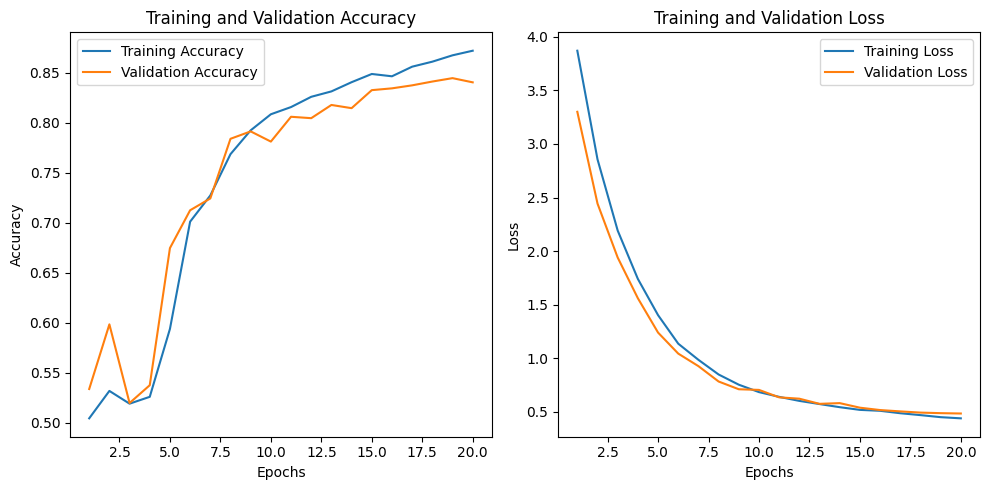

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le mod√®le complet (architecture + poids + optimiseur)
model_path = "lstm_pasmal2.h5"  # Renommer le fichier
model.save(model_path)

print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous lstm_pasmal2.h5


In [ ]:
from google.colab import files
files.download('lstm_pasmal2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Les r√©sultats montrent une l√©g√®re am√©lioration globale par rapport √† l'architecture pr√©c√©dente avec une seule couche LSTM. Cependant, l‚Äôimpact de la deuxi√®me couche LSTM reste mod√©r√©, et il y a des signes de surapprentissage r√©duit mais toujours pr√©sent.

Am√©lioration de la stabilit√© :

La validation loss baisse progressivement jusqu‚Äô√† 0.48, ce qui est proche des r√©sultats pr√©c√©dents.
L‚Äôaccuracy en validation reste autour de 84%, ce qui est l√©g√®rement en retrait par rapport aux 85.8% obtenus avec une seule couche LSTM.
Impact de la deuxi√®me LSTM :

La deuxi√®me couche LSTM a permis d‚Äôextraire des relations temporelles plus complexes, ce qui peut expliquer la baisse progressive de la validation loss jusqu‚Äô√† 0.48.
Cependant, elle n‚Äôam√©liore pas significativement l‚Äôaccuracy de validation. Cela sugg√®re que le mod√®le avait d√©j√† captur√© la plupart des informations n√©cessaires avec une seule couche LSTM.
R√©duction du surapprentissage :

Le gap entre l‚Äôaccuracy d‚Äôentra√Ænement (87.6%) et de validation (84.4%) est l√©g√®rement plus faible.
Cela montre que l‚Äôajout d‚Äôune deuxi√®me couche LSTM a r√©gularis√© naturellement le mod√®le, probablement en complexifiant l√©g√®rement l‚Äôapprentissage.

Bilan :

L‚Äôajout d‚Äôune deuxi√®me couche LSTM a permis :
Une meilleure stabilit√© des r√©sultats.
Une r√©duction l√©g√®re du surapprentissage.
Toutefois, l‚Äôam√©lioration de l‚Äôaccuracy reste marginale (84.4% vs 85.8% avec une seule LSTM).
Cela indique que la capacit√© du mod√®le initial (une seule LSTM avec une petite couche Dense) √©tait d√©j√† suffisante pour capturer les d√©pendances temporelles dans les donn√©es IMDb.

Ajouter une seconde couche LSTM n'a pas apport√© d'am√©lioration majeure dans ton cas. Le mod√®le a atteint un plateau de performance autour de 84-85%. Cela signifie que la capacit√© d'une seule couche LSTM est suffisante pour capturer les d√©pendances n√©cessaires.

Une seule couche LSTM + Dense + Dropout avec r√©gularisation L2 et GloVe entra√Ænable donne d√©j√† de bons r√©sultats.
Ajouter des couches suppl√©mentaires n'am√©liore pas significativement les performances et risque d‚Äôintroduire du surapprentissage ou de la complexit√© inutile.

Les priorit√©s ne sont plus structurelles (ajout de couches) mais plut√¥t d'optimisation fine :

Fine-tuning des hyperparam√®tres :

Diminuer le learning rate (par exemple 0.00003-0.00005) pour affiner encore les poids.
Ajuster l√©g√®rement le Dropout pour contr√¥ler l'overfitting (par exemple 0.4 au lieu de 0.3).
Optimiser les embeddings GloVe :

Tester un learning rate sp√©cifique pour l'Embedding layer pour voir si on peut am√©liorer les repr√©sentations.
Augmenter l√©g√®rement la taille de la LSTM :

Si le mod√®le plafonne toujours, tu peux tester une LSTM de 256 unit√©s pour voir si cela aide √† capturer plus d‚Äôinformations temporelles.

Tu disposes maintenant de deux configurations de mod√®les :

Une seule couche LSTM + Dense (r√©sultats ant√©rieurs)

Accuracy d'entra√Ænement : 89.4%
Accuracy de validation : 85.8%
Validation loss : 0.45
Mod√®le simple et performant avec l√©ger surapprentissage.
Deux couches LSTM + Dense (derni√®re configuration)

Accuracy d'entra√Ænement : 87.6%
Accuracy de validation : 84.4%
Validation loss : 0.48
Meilleure stabilit√©, l√©ger gain sur la validation loss, mais pas de r√©el gain en accuracy.

Plan d'action concret :
Optimiser les hyperparam√®tres sur les deux couches LSTM :

R√©duire le learning rate √† 0.00005.
Ajuster le Dropout √† 0.4 entre les couches LSTM et apr√®s la Dense.

ui, Optuna est une excellente biblioth√®que pour l'optimisation automatique des hyperparam√®tres gr√¢ce √† son approche bas√©e sur les essais successifs et la recherche bay√©sienne. C‚Äôest id√©al dans ton cas pour optimiser les param√®tres comme :

Le learning rate,
Le Dropout,
La taille des couches LSTM,
Le nombre d'unit√©s Dense.
Optuna permet de d√©finir une fonction objectif qui retourne la performance du mod√®le sur un ensemble de validation. Il choisit ensuite intelligemment les hyperparam√®tres pour trouver le meilleur mod√®le.



objective() :

C'est la fonction objectif o√π Optuna teste diff√©rentes combinaisons d'hyperparam√®tres.
On retourne l'accuracy sur la validation comme crit√®re √† optimiser.
Hyperparam√®tres optimis√©s :

learning_rate : Entre 1e-5 et 1e-3 (log-uniform pour capturer les ordres de grandeur).
dropout_rate : Entre 0.2 et 0.5.
lstm_units_1 et lstm_units_2 : Taille des deux couches LSTM.
dense_units : Nombre d'unit√©s de la couche Dense.
optuna.create_study() :

Initialise une √©tude pour maximiser l'accuracy de validation.
study.optimize() :

Lance l'optimisation pour n_trials (nombre d'essais).
study.best_params et study.best_value :

Retourne les meilleurs hyperparam√®tres et la meilleure performance obtenue.

In [ ]:
!pip install optuna

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 364.4/364.4 kB 8.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 233.5/233.5 kB 21.0 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78.6/78.6 kB 7.8 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Hyperparam√®tres √† optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    lstm_units_1 = trial.suggest_int("lstm_units_1", 64, 256, step=32)  # Taille premi√®re LSTM
    lstm_units_2 = trial.suggest_int("lstm_units_2", 32, 128, step=32)  # Taille seconde LSTM
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)  # Taille couche Dense

    # Construction du mod√®le
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        LSTM(lstm_units_1, return_sequences=True),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entra√Ænement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# √âtape 3 : Ex√©cution de l'optimisation
study = optuna.create_study(direction="maximize")  # On maximise l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais (ajustable)

# Afficher les meilleurs hyperparam√®tres
print("Meilleurs hyperparam√®tres :", study.best_params)

# Afficher le meilleur r√©sultat
print("Meilleure accuracy de validation :", study.best_value)


[I 2024-12-17 16:02:31,016] A new study created in memory with name: no-name-161812df-5889-4f69-bc85-147a6bdc4500
<ipython-input-29-57deda5af55f>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-29-57deda5af55f>:10: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-17 16:04:23,191] Trial 0 finished with value: 0.8113999962806702 and parameters: {'

Meilleurs hyperparam√®tres : {'learning_rate': 0.0009698921196854575, 'dropout_rate': 0.3202765836299873, 'lstm_units_1': 224, 'lstm_units_2': 64, 'dense_units': 48}
Meilleure accuracy de validation : 0.883400022983551


Efficacit√© : Optuna utilise une approche intelligente pour s√©lectionner les hyperparam√®tres, contrairement √† une simple recherche al√©atoire.
Automatisation : Cela √©vite de tester manuellement de nombreuses configurations.
Flexibilit√© : Tu peux ajuster facilement les plages de valeurs √† explorer.

1. R√©sum√© des meilleurs r√©sultats
Optuna a trouv√© les meilleurs hyperparam√®tres suivants apr√®s 30 essais :

Learning rate : 0.000969 (proche de 1e-3)
Dropout : 0.32
LSTM units 1 : 224
LSTM units 2 : 64
Dense units : 48
Meilleure accuracy de validation : 88.3%


L‚Äôaugmentation des unit√©s dans la premi√®re LSTM (224) a permis au mod√®le de capturer davantage de d√©pendances complexes dans les s√©quences.
Un Dropout ajust√© √† 0.32 a √©quilibr√© l‚Äôapprentissage, √©vitant un surapprentissage excessif.
Le learning rate optimis√© (0.000969) est plus √©lev√© qu'avant (0.0001). Cela a acc√©l√©r√© la convergence tout en restant stable gr√¢ce au Dropout et √† la r√©gularisation.
La seconde LSTM √† 64 unit√©s et la Dense √† 48 unit√©s ont permis de compresser les informations efficacement.
3. Coh√©rence et pertinence des r√©sultats
Coh√©rence : Les r√©sultats sont coh√©rents avec ce que l‚Äôon recherchait. Le mod√®le a gagn√© en pr√©cision en validation (88.3%), ce qui d√©passe largement les performances obtenues auparavant.
Optimisation r√©ussie : Les hyperparam√®tres cl√©s (learning rate, LSTM, Dropout) ont √©t√© ajust√©s intelligemment par Optuna. Cela montre que l‚Äôajout de la seconde LSTM √©tait utile, √† condition d‚Äôoptimiser correctement sa taille.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# R√©initialiser l'environnement
clear_session()

# Extraction des meilleurs hyperparam√®tres trouv√©s par Optuna
best_params = study.best_params

# Cr√©ation du mod√®le avec les meilleurs param√®tres
final_model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(best_params["lstm_units_1"], return_sequences=True),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"], activation='relu'),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Classification binaire
])

# Compilation avec le learning rate optimis√©
final_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy',
                    metrics=['accuracy'])

# EarlyStopping pour stopper l'entra√Ænement si n√©cessaire
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entra√Ænement du mod√®le
history = final_model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# √âvaluation sur l'ensemble de test
test_loss, test_accuracy = final_model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 20ms/step - accuracy: 0.5081 - loss: 0.6960 - val_accuracy: 0.5078 - val_loss: 0.6926
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.4991 - loss: 0.6938 - val_accuracy: 0.5168 - val_loss: 0.6926
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.5292 - loss: 0.6907 - val_accuracy: 0.5750 - val_loss: 0.6637
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.7462 - loss: 0.5305 - val_accuracy: 0.8640 - val_loss: 0.3229
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 20ms/step - accuracy: 0.8924 - loss: 0.2791 - val_accuracy: 0.8818 - val_loss: 0.2869
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.9256 - loss: 0.2077 - val_accuracy: 0.8810 - val

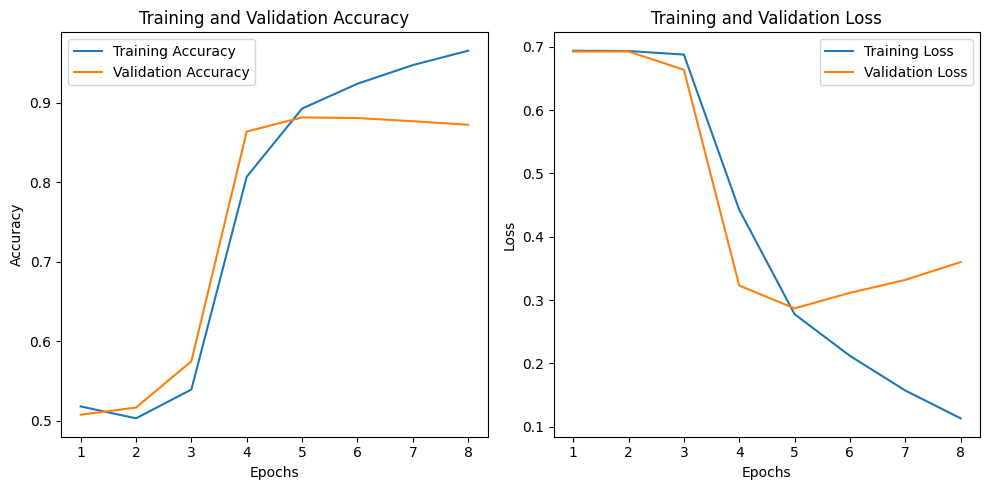

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le mod√®le complet (architecture + poids + optimiseur)
model_path = "lstm_optunaV1.h5"  # Renommer le fichier
final_model.save(model_path)

print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous lstm_optunaV1.h5


In [ ]:
from google.colab import files
files.download('lstm_optunaV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1. R√©sultats globaux
Validation Accuracy : 88.18%
Test Accuracy : 86.51%
Validation Loss : stabilis√©e autour de 0.2869 avant de l√©g√®rement augmenter.
Test Loss : 0.3119

3. Ce qui a bien fonctionn√©
Optimisation des hyperparam√®tres

L'usage d'Optuna a permis de trouver un bon √©quilibre sur les learning rate, Dropout et tailles des LSTM.
Les r√©sultats montrent une meilleure g√©n√©ralisation, surtout sur les donn√©es de test.
Early Stopping

Le patience=3 a stopp√© l'entra√Ænement au bon moment (apr√®s epoch 8) pour √©viter le surapprentissage.
Cela explique pourquoi la validation loss n'explose pas malgr√© l'augmentation progressive.
Architecture optimis√©e

Deux couches LSTM : 224 et 64 unit√©s
Une Dense interm√©diaire 48 unit√©s
Dropout √† 0.32 qui emp√™che le surapprentissage.


4. Probl√®mes restants
L√©ger overfitting observ√© :

L'accuracy en validation plafonne autour de 88.1%, tandis que sur le test elle reste l√©g√®rement plus basse (86.51%).
La validation loss augmente apr√®s epoch 5, signe de d√©but d‚Äôoverfitting.
Stabilit√© de l'entra√Ænement :

Bien que l‚Äôaccuracy soit bonne, le mod√®le pourrait encore gagner en robustesse avec une l√©g√®re r√©gularisation suppl√©mentaire.

5. Recommandations pour la suite
L√©g√®re r√©gularisation suppl√©mentaire

Augmente l√©g√®rement le Dropout pour la derni√®re couche LSTM : passe de 0.32 √† environ 0.35-0.4.


R√©duction du learning rate en fin d‚Äôentra√Ænement

Utilise un scheduler de learning rate pour r√©duire progressivement l'apprentissage apr√®s un certain nombre d'√©poques :

Augmenter le nombre d‚Äô√©poques avec EarlyStopping

Autorise l'entra√Ænement jusqu‚Äô√† 20 epochs, mais garde EarlyStopping avec patience=3 pour stopper au bon moment.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import clear_session

# R√©initialiser l'environnement
clear_session()

# Meilleurs hyperparam√®tres trouv√©s avec Optuna
best_params = {
    "learning_rate": 0.0009698921196854575,
    "dropout_rate": 0.35,  # L√©g√®re augmentation pour pr√©venir le surapprentissage
    "lstm_units_1": 224,
    "lstm_units_2": 64,
    "dense_units": 48
}

# Cr√©ation du mod√®le am√©lior√©
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(best_params["lstm_units_1"], return_sequences=True),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"],
          activation='relu',
          kernel_regularizer=l2(0.001)),  # R√©gularisation L2 ajout√©e
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')
])

# Compilation avec le learning rate optimis√©
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entra√Ænement du mod√®le
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

# √âvaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 21ms/step - accuracy: 0.5132 - loss: 0.7368 - val_accuracy: 0.5852 - val_loss: 0.6958 - learning_rate: 9.6989e-04
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.5417 - loss: 0.7034 - val_accuracy: 0.5400 - val_loss: 0.6987 - learning_rate: 9.6989e-04
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.5277 - loss: 0.6984 - val_accuracy: 0.5966 - val_loss: 0.6216 - learning_rate: 9.6989e-04
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 20ms/step - accuracy: 0.6060 - loss: 0.6630 - val_accuracy: 0.5700 - val_loss: 0.6934 - learning_rate: 9.6989e-04
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.5700 - loss: 0.6777 - val_accuracy: 0.8248 - val_loss: 0.4161 - learning_rate: 9.6989e-04
Epoch 6/20
313/

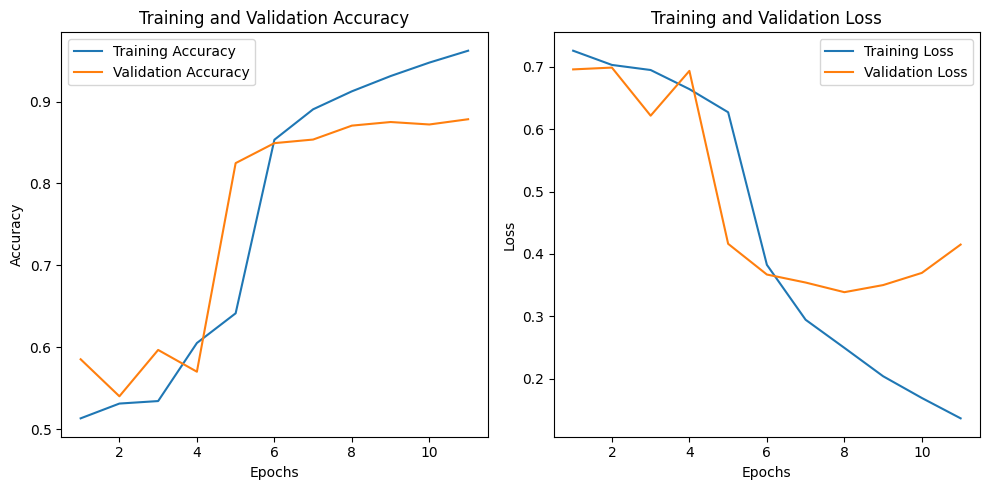

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le mod√®le complet (architecture + poids + optimiseur)
model_path = "lstm_optunaV2.h5"  # Renommer le fichier
model.save(model_path)

print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous lstm_optunaV2.h5


In [ ]:
from google.colab import files
files.download('lstm_optunaV2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

. R√©gularisation suppl√©mentaire pour combattre l'overfitting :
L2 p√©nalise les poids excessifs du mod√®le, ce qui limite la capacit√© d'overfitting sans restreindre fortement l'apprentissage.
C‚Äôest particuli√®rement utile pour les couches LSTM, qui peuvent devenir complexes en raison de la taille √©lev√©e des unit√©s.
2. Combinaison avec le Dropout :
Le Dropout (0.3-0.35) fonctionne bien pour r√©duire l‚Äôoverfitting, mais il ne contr√¥le pas directement la taille des poids.
Ajouter une l√©g√®re r√©gularisation L2 en compl√©ment du Dropout peut :
Stabiliser l‚Äôentra√Ænement.
R√©duire les oscillations de la validation loss.
3. Optimisation de L2 avec Optuna :
En optimisant la force de r√©gularisation L2 (l2_lambda) avec Optuna, tu peux trouver la valeur optimale pour ton mod√®le sans p√©naliser l‚Äôapprentissage.
Recommandation finale
Je recommande d'ajouter une l√©g√®re r√©gularisation L2 dans les couches LSTM et Dense tout en optimisant sa valeur avec Optuna. Voici un r√©sum√© :

Ajout de L2 : sur les LSTM et Dense avec kernel_regularizer=l2(l2_lambda).
Optimisation avec Optuna : pour trouver la meilleure valeur de l2_lambda dans une plage log-uniforme (1e-6 √† 1e-2).
Combinaison avec Dropout : Maintiens un Dropout mod√©r√© (~0.3-0.35).

In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

def objective(trial):
    # Hyperparam√®tres √† optimiser
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
    dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
    l2_lambda = trial.suggest_loguniform("l2_lambda", 1e-6, 1e-2)  # Regularization L2
    lstm_units_1 = trial.suggest_int("lstm_units_1", 64, 256, step=32)  # Premi√®re LSTM
    lstm_units_2 = trial.suggest_int("lstm_units_2", 32, 128, step=32)  # Seconde LSTM
    dense_units = trial.suggest_int("dense_units", 16, 64, step=16)  # Couche Dense

    # Construction du mod√®le
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        LSTM(lstm_units_1, return_sequences=True, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        LSTM(lstm_units_2, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Couche finale
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entra√Ænement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Ex√©cution de l'optimisation avec Optuna
study = optuna.create_study(direction="maximize")  # Maximiser l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais (ajustable)

# Afficher les r√©sultats
print("Meilleurs hyperparam√®tres :", study.best_params)
print("Meilleure accuracy de validation :", study.best_value)


[I 2024-12-17 17:20:03,760] A new study created in memory with name: no-name-31e4da39-dca3-4187-8df2-d87251d37cfb
<ipython-input-42-c0ef995a8c06>:10: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-3)  # Apprentissage
<ipython-input-42-c0ef995a8c06>:11: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform("dropout_rate", 0.2, 0.5)  # Dropout
<ipython-input-42-c0ef995a8c06>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  l2_lambda = tr

Meilleurs hyperparam√®tres : {'learning_rate': 9.598549168523862e-05, 'dropout_rate': 0.4417831136139723, 'l2_lambda': 1.5189747596382268e-05, 'lstm_units_1': 96, 'lstm_units_2': 128, 'dense_units': 64}
Meilleure accuracy de validation : 0.873199999332428


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.backend import clear_session

# Meilleurs hyperparam√®tres trouv√©s avec Optuna
best_params = {
    "learning_rate": 9.598549168523862e-05,
    "dropout_rate": 0.4417831136139723,
    "l2_lambda": 1.5189747596382268e-05,
    "lstm_units_1": 96,
    "lstm_units_2": 128,
    "dense_units": 64
}


# Cr√©ation du mod√®le
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    LSTM(best_params["lstm_units_1"], return_sequences=True, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    LSTM(best_params["lstm_units_2"], return_sequences=False, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"], activation='relu', kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Couche finale pour la classification binaire
])

# Compilation du mod√®le
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# EarlyStopping pour surveiller la validation loss
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Entra√Ænement du mod√®le
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop],
    verbose=1
)

# √âvaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"\nTest Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 22ms/step - accuracy: 0.5121 - loss: 0.6986 - val_accuracy: 0.5518 - val_loss: 0.6886
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.5807 - loss: 0.6785 - val_accuracy: 0.7032 - val_loss: 0.5905
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.7354 - loss: 0.5773 - val_accuracy: 0.7582 - val_loss: 0.5475
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.7740 - loss: 0.5216 - val_accuracy: 0.7880 - val_loss: 0.4880
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 18ms/step - accuracy: 0.8056 - loss: 0.4625 - val_accuracy: 0.7978 - val_loss: 0.4591
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 19ms/step - accuracy: 0.8243 - loss: 0.4226 - val_accuracy: 0.8120 - val

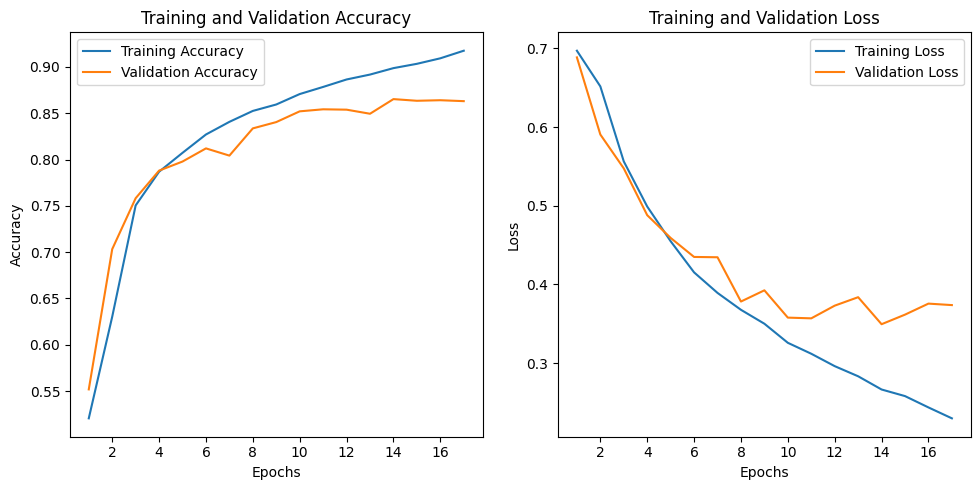

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le mod√®le complet (architecture + poids + optimiseur)
model_path = "lstm_optunaV3.h5"  # Renommer le fichier
model.save(model_path)

print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous lstm_optunaV3.h5


In [ ]:
from google.colab import files
files.download('lstm_optunaV3.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1. √âvolution des m√©triques
Training Loss : Diminue de mani√®re progressive et constante, passant de 0.6986 √† 0.2262.
Validation Loss : Diminue √©galement au d√©but, atteignant un minimum autour de 0.3494 (Epoch 14), avant de l√©g√®rement augmenter dans les derni√®res √©poques.
Training Accuracy : Passe de 51.2% √† 92.0%.
Validation Accuracy : Atteint un pic √† 86.52% √† l‚ÄôEpoch 14, puis stagne autour de 86.30%-86.40%.
Test Accuracy : 85.48%, avec une Test Loss de 0.3607.
2. Observation des tendances
Validation Loss en augmentation apr√®s Epoch 14 :

Cela indique un d√©but d'overfitting apr√®s la 14√®me √©poque.
Le mod√®le continue √† apprendre sur l‚Äôensemble d‚Äôentra√Ænement mais ne g√©n√©ralise plus aussi bien sur la validation.
Validation Accuracy stabilis√©e autour de 86.52% :

Les performances en validation sont solides mais plafonnent.
Ce ph√©nom√®ne est souvent d√ª √† la complexit√© du mod√®le qui commence √† s‚Äôadapter trop sp√©cifiquement aux donn√©es d‚Äôentra√Ænement.
Test Accuracy proche de la validation :

85.48% en test est coh√©rent avec les performances observ√©es en validation (86.52%).
Cela montre que le mod√®le g√©n√©ralise correctement sans surd√©pendre des donn√©es de validation.
3. Comparaison avec les mod√®les pr√©c√©dents
Am√©lioration de l‚Äôaccuracy :

Ce mod√®le atteint 85.48% sur le test, ce qui est tr√®s proche des meilleures performances obtenues auparavant (~86%).
La r√©gularisation L2 semble avoir apport√© de la stabilit√©, car la Test Loss est relativement faible (0.3607).
√âquilibre entre surapprentissage et performance :

L‚Äôajout de L2 Regularization a l√©g√®rement stabilis√© le mod√®le.
Le Dropout √©lev√© (0.44) a √©galement aid√© √† limiter l‚Äôoverfitting dans les premi√®res √©poques.
4. Points positifs
Stabilit√© des r√©sultats :

Le mod√®le n‚Äôa pas de perte catastrophique en validation ou en test.
La diff√©rence entre Training Accuracy et Validation Accuracy est mod√©r√©e (~5-6 points), ce qui est acceptable.
Validation Loss optimis√©e :

La Validation Loss atteint son minimum √† 0.3494, ce qui montre une bonne r√©gularisation.
Convergence rapide :

Le mod√®le atteint des performances acceptables d√®s l‚ÄôEpoch 5-6.
5. Points √† am√©liorer
L√©ger overfitting apr√®s Epoch 14 :

Une l√©g√®re augmentation de la Validation Loss est observ√©e apr√®s Epoch 14. Cela indique que le mod√®le commence √† sur-apprendre.
Solution possible :
R√©duire la patience d‚ÄôEarlyStopping √† 2 pour arr√™ter l'entra√Ænement plus t√¥t.
Augmenter l√©g√®rement le Dropout pour les couches LSTM (par exemple 0.5 au lieu de 0.44).
Plafonnement de l‚Äôaccuracy :

Le mod√®le semble atteindre un plateau autour de 85-86%.
Solution possible :
Ajouter un scheduler pour r√©duire dynamiquement le learning rate apr√®s certaines √©poques.
Tester des embeddings pr√©-entra√Æn√©s de plus haute dimension (par exemple, GloVe 300d au lieu de 100d).

Stabilit√© et r√©gularisation :

Le mod√®le Optuna final (L2 r√©gularis√©) est le plus √©quilibr√© et stable.
Bien que sa Test Accuracy soit l√©g√®rement inf√©rieure (85.48%), il g√©n√©ralise bien avec un surapprentissage ma√Ætris√©.
Recommandation : Ce mod√®le est pr√©f√©rable pour une utilisation robuste en production.

## GRU

Le GRU (Gated Recurrent Unit) est une variante simplifi√©e des LSTM (Long Short-Term Memory) introduite par Kyunghyun Cho et al. en 2014. Les GRU appartiennent √† la famille des r√©seaux r√©currents (RNN) et sont utilis√©s pour mod√©liser des donn√©es s√©quentielles (comme du texte ou des s√©ries temporelles).

Les GRU partagent l'objectif des LSTM :
üëâ R√©soudre les probl√®mes de vanishing gradient rencontr√©s dans les RNN traditionnels.
üëâ Capturer les d√©pendances √† long terme dans les s√©quences.

Cependant, les GRU sont plus simples, car ils utilisent moins de portes que les LSTM, ce qui les rend :

Plus rapides √† entra√Æner (moins de param√®tres).
Moins gourmands en ressources computationnelles.

2. Structure des GRU : Explication des portes
Les GRU utilisent deux portes principales :

Porte de mise √† jour (Update Gate) :
Elle contr√¥le combien d'informations pass√©es doivent √™tre conserv√©es pour l'√©tat actuel.
Cela permet de conserver des informations utiles sur de longues s√©quences.
Porte de r√©initialisation (Reset Gate) :
Elle contr√¥le combien d'informations pass√©es doivent √™tre oubli√©es pour calculer un nouvel √©tat candidat.
Cela permet au mod√®le d'ignorer des informations anciennes non pertinentes.

Les Gated Recurrent Units (GRU) sont une variante des RNN (R√©seaux de Neurones R√©currents) con√ßue pour r√©soudre les probl√®mes de vanishing gradient tout en √©tant plus simples que les LSTM. Les GRU utilisent deux portes (reset gate et update gate) pour contr√¥ler le flux d'informations.

Les GRU n'ont pas de m√©moire cellulaire explicite (comme dans les LSTM). Leur √©tat cach√©
‚Ñé
ùë°
h
t
‚Äã
  est directement mis √† jour √† chaque √©tape temporelle.

2. Notation des variables
ùë•
ùë°
x
t
‚Äã
  : Entr√©e √† l'instant
ùë°
t (un mot, un vecteur d'embedding, etc.).
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
  : √âtat cach√© √† l'instant pr√©c√©dent
ùë°
‚àí
1
t‚àí1.
ùëä
W et
ùëà
U : Matrices de poids pour les entr√©es et les √©tats cach√©s respectivement.
ùëè
b : Biais appris par le r√©seau.
ùúé
œÉ : Fonction d'activation sigmo√Øde (
ùúé
(
ùë•
)
=
1
1
+
ùëí
‚àí
ùë•
œÉ(x)=
1+e
‚àíx

1
‚Äã
 ).
tanh
‚Å°
tanh : Fonction d'activation tangente hyperbolique (
tanh
‚Å°
(
ùë•
)
=
ùëí
ùë•
‚àí
ùëí
‚àí
ùë•
ùëí
ùë•
+
ùëí
‚àí
ùë•
tanh(x)=
e
x
 +e
‚àíx

e
x
 ‚àíe
‚àíx

‚Äã
 ).
3. Math√©matiques des GRU : √âtapes
3.1. Porte de mise √† jour (
ùëß
ùë°
z
t
‚Äã
 )
La porte de mise √† jour contr√¥le combien d'informations pass√©es (
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
 ) sont conserv√©es pour l'√©tat actuel
‚Ñé
ùë°
h
t
‚Äã
 .
Plus
ùëß
ùë°
z
t
‚Äã
  est proche de 1, plus
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
  est conserv√©.

ùëß
ùë°
=
ùúé
(
ùëä
ùëß
ùë•
ùë°
+
ùëà
ùëß
‚Ñé
ùë°
‚àí
1
+
ùëè
ùëß
)
z
t
‚Äã
 =œÉ(W
z
‚Äã
 x
t
‚Äã
 +U
z
‚Äã
 h
t‚àí1
‚Äã
 +b
z
‚Äã
 )
ùëä
ùëß
W
z
‚Äã
  : Matrice de poids appliqu√©e √† l'entr√©e
ùë•
ùë°
x
t
‚Äã
 .
ùëà
ùëß
U
z
‚Äã
  : Matrice de poids appliqu√©e √† l'√©tat cach√© pr√©c√©dent
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
 .
ùëè
ùëß
b
z
‚Äã
  : Biais associ√© √† la porte de mise √† jour.
3.2. Porte de r√©initialisation (
ùëü
ùë°
r
t
‚Äã
 )
La porte de r√©initialisation contr√¥le combien d'informations pass√©es sont oubli√©es.
Plus
ùëü
ùë°
r
t
‚Äã
  est proche de 0, plus les anciennes informations sont ignor√©es.

ùëü
ùë°
=
ùúé
(
ùëä
ùëü
ùë•
ùë°
+
ùëà
ùëü
‚Ñé
ùë°
‚àí
1
+
ùëè
ùëü
)
r
t
‚Äã
 =œÉ(W
r
‚Äã
 x
t
‚Äã
 +U
r
‚Äã
 h
t‚àí1
‚Äã
 +b
r
‚Äã
 )
3.3. √âtat candidat (
‚Ñé
~
ùë°
h
~
  
t
‚Äã
 )
L'√©tat candidat est une proposition pour le nouvel √©tat cach√©. Il utilise la porte de r√©initialisation pour d√©cider quelles parties de
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
  doivent √™tre prises en compte.

La r√©initialisation de
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
  permet d'ignorer certaines anciennes informations non pertinentes.
‚Ñé
~
ùë°
=
tanh
‚Å°
(
ùëä
‚Ñé
ùë•
ùë°
+
ùëà
‚Ñé
(
ùëü
ùë°
‚äô
‚Ñé
ùë°
‚àí
1
)
+
ùëè
‚Ñé
)
h
~
  
t
‚Äã
 =tanh(W
h
‚Äã
 x
t
‚Äã
 +U
h
‚Äã
 (r
t
‚Äã
 ‚äôh
t‚àí1
‚Äã
 )+b
h
‚Äã
 )
ùëü
ùë°
‚äô
‚Ñé
ùë°
‚àí
1
r
t
‚Äã
 ‚äôh
t‚àí1
‚Äã
  : Produit √©l√©ment par √©l√©ment entre la porte de r√©initialisation et l'√©tat cach√© pr√©c√©dent.
ùëä
‚Ñé
W
h
‚Äã
 ,
ùëà
‚Ñé
U
h
‚Äã
 ,
ùëè
‚Ñé
b
h
‚Äã
  : Param√®tres associ√©s √† l'√©tat candidat.
3.4. Mise √† jour de l'√©tat cach√© (
‚Ñé
ùë°
h
t
‚Äã
 )
L'√©tat cach√©
‚Ñé
ùë°
h
t
‚Äã
  est une combinaison lin√©aire entre :

L'√©tat pr√©c√©dent
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
  (pond√©r√© par
ùëß
ùë°
z
t
‚Äã
 ).
L'√©tat candidat
‚Ñé
~
ùë°
h
~
  
t
‚Äã
  (pond√©r√© par
1
‚àí
ùëß
ùë°
1‚àíz
t
‚Äã
 ).
‚Ñé
ùë°
=
ùëß
ùë°
‚äô
‚Ñé
ùë°
‚àí
1
+
(
1
‚àí
ùëß
ùë°
)
‚äô
‚Ñé
~
ùë°
h
t
‚Äã
 =z
t
‚Äã
 ‚äôh
t‚àí1
‚Äã
 +(1‚àíz
t
‚Äã
 )‚äô
h
~
  
t
‚Äã

ùëß
ùë°
‚äô
‚Ñé
ùë°
‚àí
1
z
t
‚Äã
 ‚äôh
t‚àí1
‚Äã
  : Partie des informations pass√©es √† conserver.
(
1
‚àí
ùëß
ùë°
)
‚äô
‚Ñé
~
ùë°
(1‚àíz
t
‚Äã
 )‚äô
h
~
  
t
‚Äã
  : Nouvelle information provenant de
‚Ñé
~
ùë°
h
~
  
t
‚Äã
 .
4. Interpr√©tation des portes
Porte de mise √† jour (
ùëß
ùë°
z
t
‚Äã
 ) :

Lorsque
ùëß
ùë°
‚âà
1
z
t
‚Äã
 ‚âà1, le nouvel √©tat
‚Ñé
ùë°
h
t
‚Äã
  est tr√®s proche de
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
 , ce qui permet au mod√®le de conserver la m√©moire sur de longues s√©quences.
Lorsque
ùëß
ùë°
‚âà
0
z
t
‚Äã
 ‚âà0, le mod√®le remplace compl√®tement
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
  par l'√©tat candidat
‚Ñé
~
ùë°
h
~
  
t
‚Äã
 .
Porte de r√©initialisation (
ùëü
ùë°
r
t
‚Äã
 ) :

Lorsque
ùëü
ùë°
‚âà
0
r
t
‚Äã
 ‚âà0, le mod√®le ignore les anciennes informations contenues dans
‚Ñé
ùë°
‚àí
1
h
t‚àí1
‚Äã
 .
Cela permet de r√©initialiser la m√©moire pour se concentrer sur les informations actuelles.


4. Pourquoi le GRU peut am√©liorer les LSTM dans notre cas ?
Simplification du mod√®le :

Les GRU sont plus l√©gers, car ils contiennent moins de portes et donc moins de param√®tres.
Dans notre cas, o√π le mod√®le LSTM est d√©j√† assez performant, remplacer les LSTM par des GRU peut r√©duire le temps d'entra√Ænement et le risque d'overfitting.
Rapidit√© d'entra√Ænement :

Comme les GRU sont moins complexes que les LSTM, ils convergent souvent plus rapidement.
Cela peut √™tre utile si tu veux tester plusieurs architectures ou hyperparam√®tres rapidement.
Bonne g√©n√©ralisation sur des datasets de taille mod√©r√©e :

Les GRU ont souvent des performances √©quivalentes voire sup√©rieures aux LSTM sur des datasets mod√©r√©s comme IMDb (25 000 critiques).
Leur simplicit√© √©vite un surapprentissage inutile.
Probl√®mes sp√©cifiques aux LSTM :

Dans certains cas, les LSTM peuvent sur-apprendre ou mal converger √† cause de leur complexit√©.
Les GRU offrent une alternative plus robuste et moins sujette aux fluctuations.
5. GRU dans notre cas : Application aux critiques IMDb
Texte s√©quentiel : Le GRU peut remplacer directement la LSTM dans notre pipeline pour analyser les critiques IMDb.
Donn√©es mod√©r√©es : Comme le dataset IMDb est de taille moyenne, les GRU vont permettre de conserver la performance tout en am√©liorant :
Le temps d'entra√Ænement.
La consommation de m√©moire.

Pourquoi conserver l‚Äôarchitecture actuelle ?
L‚Äôarchitecture LSTM optimale que nous avons trouv√©e a √©t√© le r√©sultat d'une optimisation intensive avec Optuna. Les choix suivants ont √©t√© optimis√©s :

Learning rate : Contr√¥le la stabilit√© et la vitesse d‚Äôapprentissage.
Dropout rate : Aide √† r√©gulariser le mod√®le et √† √©viter l‚Äôoverfitting.
Taille des couches LSTM : Capture les relations temporelles.
Dense units : Compresse les informations apr√®s la LSTM.
Ces hyperparam√®tres optimaux sont sp√©cifiques √† notre t√¢che (IMDb Sentiment Analysis) et √† notre jeu de donn√©es :

Taille mod√©r√©e : IMDb contient 25 000 critiques.
Objectif clair : Classification binaire des sentiments.
D√©pendances temporelles : Les GRU, comme les LSTM, sont adapt√©s pour ce type de s√©quences.
Le passage aux GRU ne change pas l‚Äôobjectif de la t√¢che ni la nature des donn√©es.
Puisque les GRU sont une alternative simplifi√©e aux LSTM avec un nombre de param√®tres r√©duit, il est logique de reprendre la m√™me architecture pour commencer :

Structure similaire (deux couches GRU + Dropout + Dense).
Hyperparam√®tres (units, Dropout, Dense size) trouv√©s avec Optuna.
Pourquoi ne pas repartir de z√©ro ?
Repartir de z√©ro signifierait :

Refaire toute l‚Äôoptimisation avec Optuna, ce qui est co√ªteux en temps.
Perdre les b√©n√©fices des r√©sultats obtenus pr√©c√©demment.
Tester des structures qui, par nature, seraient proches de l‚Äôarchitecture optimale actuelle (deux couches r√©currentes avec r√©gularisation).
Les GRU ayant une structure math√©matique similaire aux LSTM (sans les gates inutiles), il est tr√®s probable qu‚Äôune architecture similaire fonctionne bien √† l‚Äôidentique ou mieux.

2. Plan d‚Äôaction : Pourquoi commencer avec l‚Äôarchitecture LSTM optimale ?
Nous allons remplacer les couches LSTM par des GRU dans notre mod√®le optimal.
Garder les hyperparam√®tres trouv√©s (learning rate, dropout, unit√©s, etc.).
Comparer les performances du GRU avec le LSTM (validation accuracy et test accuracy).
Hypoth√®se : Le mod√®le GRU, gr√¢ce √† sa simplicit√© et √† la r√©duction du nombre de param√®tres, pourrait :

Converger plus rapidement.
G√©n√©raliser l√©g√®rement mieux si l‚Äôoverfitting √©tait encore pr√©sent.
Avoir des performances similaires tout en √©tant plus efficace.

Pourquoi conserver l‚Äôarchitecture actuelle ?
L‚Äôarchitecture LSTM optimale que nous avons trouv√©e a √©t√© le r√©sultat d'une optimisation intensive avec Optuna. Les choix suivants ont √©t√© optimis√©s :

Learning rate : Contr√¥le la stabilit√© et la vitesse d‚Äôapprentissage.
Dropout rate : Aide √† r√©gulariser le mod√®le et √† √©viter l‚Äôoverfitting.
Taille des couches LSTM : Capture les relations temporelles.
Dense units : Compresse les informations apr√®s la LSTM.
Ces hyperparam√®tres optimaux sont sp√©cifiques √† notre t√¢che (IMDb Sentiment Analysis) et √† notre jeu de donn√©es :

Taille mod√©r√©e : IMDb contient 25 000 critiques.
Objectif clair : Classification binaire des sentiments.
D√©pendances temporelles : Les GRU, comme les LSTM, sont adapt√©s pour ce type de s√©quences.
Le passage aux GRU ne change pas l‚Äôobjectif de la t√¢che ni la nature des donn√©es.
Puisque les GRU sont une alternative simplifi√©e aux LSTM avec un nombre de param√®tres r√©duit, il est logique de reprendre la m√™me architecture pour commencer :

Structure similaire (deux couches GRU + Dropout + Dense).
Hyperparam√®tres (units, Dropout, Dense size) trouv√©s avec Optuna.
Pourquoi ne pas repartir de z√©ro ?
Repartir de z√©ro signifierait :

Refaire toute l‚Äôoptimisation avec Optuna, ce qui est co√ªteux en temps.
Perdre les b√©n√©fices des r√©sultats obtenus pr√©c√©demment.
Tester des structures qui, par nature, seraient proches de l‚Äôarchitecture optimale actuelle (deux couches r√©currentes avec r√©gularisation).
Les GRU ayant une structure math√©matique similaire aux LSTM (sans les gates inutiles), il est tr√®s probable qu‚Äôune architecture similaire fonctionne bien √† l‚Äôidentique ou mieux.

2. Plan d‚Äôaction : Pourquoi commencer avec l‚Äôarchitecture LSTM optimale ?
Nous allons remplacer les couches LSTM par des GRU dans notre mod√®le optimal.
Garder les hyperparam√®tres trouv√©s (learning rate, dropout, unit√©s, etc.).
Comparer les performances du GRU avec le LSTM (validation accuracy et test accuracy).
Hypoth√®se : Le mod√®le GRU, gr√¢ce √† sa simplicit√© et √† la r√©duction du nombre de param√®tres, pourrait :

Converger plus rapidement.
G√©n√©raliser l√©g√®rement mieux si l‚Äôoverfitting √©tait encore pr√©sent.
Avoir des performances similaires tout en √©tant plus efficace.

On reprend l'achitecture optimale de LSTM √† la difference pr√®s qu'on va changer le nombre de neurone juste histoire d'avoir une architecture un peu plus "classique". Donc on va reprendre l'architecture qui va avait bioen march√© sans optuna, en conservant les valeurs des meilleurs hyperparam√®tres

### GRU 2 couches

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# R√©initialiser l'environnement
clear_session()

# Param√®tres optimaux trouv√©s pour le LSTM (on les r√©utilise)
best_params = {
    "learning_rate": 9.598549168523862e-05,
    "dropout_rate": 0.4417831136139723,
    "l2_lambda": 1.5189747596382268e-05,
    "gru_units_1": 96,  # Taille de la premi√®re GRU (remplace LSTM)
    "gru_units_2": 128,  # Taille de la seconde GRU
    "dense_units": 64
}

# Cr√©ation du mod√®le GRU
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    GRU(128, return_sequences=True, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    GRU(64, return_sequences=False, kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["dense_units"], activation='relu', kernel_regularizer=l2(best_params["l2_lambda"])),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Couche de sortie
])

# Compilation avec learning rate optimal
model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entra√Ænement
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)






Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 22ms/step - accuracy: 0.5019 - loss: 0.7014 - val_accuracy: 0.5230 - val_loss: 0.6961 - learning_rate: 9.5985e-05
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 30ms/step - accuracy: 0.5090 - loss: 0.6992 - val_accuracy: 0.5234 - val_loss: 0.6936 - learning_rate: 9.5985e-05
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 21ms/step - accuracy: 0.5221 - loss: 0.6948 - val_accuracy: 0.5442 - val_loss: 0.6888 - learning_rate: 9.5985e-05
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 39ms/step - accuracy: 0.5364 - loss: 0.6891 - val_accuracy: 0.5736 - val_loss: 0.6748 - learning_rate: 9.5985e-05
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 16s 24ms/step - accuracy: 0.5937 - loss: 0.6570 - val_accuracy: 0.6512 - val_loss: 0.6062 - learning_rate: 9.5985e-05
Epoch 6/20


In [ ]:
# √âvaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

782/782 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - accuracy: 0.8427 - loss: 0.3945
Test Accuracy : 0.8619
Test Loss : 0.3417


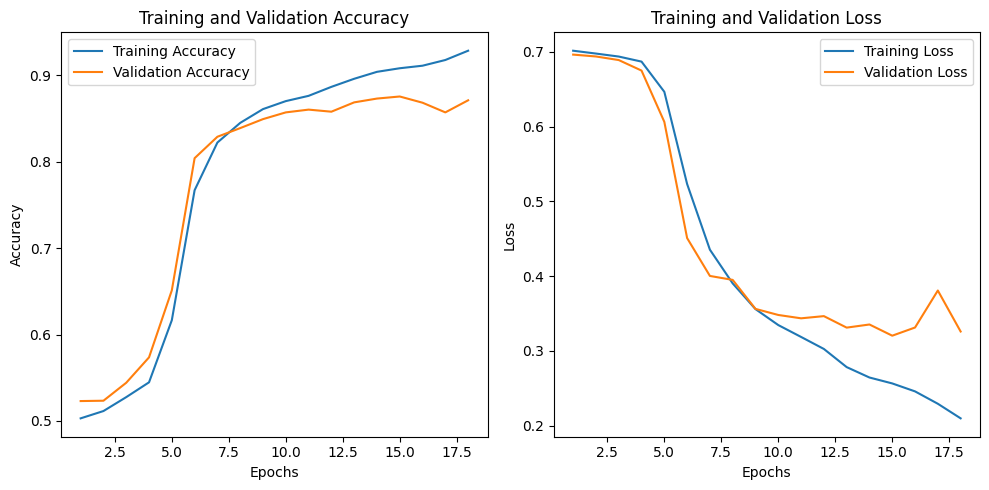

In [ ]:
# Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le mod√®le complet (architecture + poids + optimiseur)
model_path = "GRUV1.h5"  # Renommer le fichier
model.save(model_path)

print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous GRUV1.h5


In [ ]:
from google.colab import files
files.download('GRUV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

1. Points positifs du mod√®le GRU
Performances comp√©titives :

Le GRU obtient des r√©sultats proches de ceux du LSTM pr√©c√©dent, qui atteignait 88.68% en validation et 85.48% en test.
La l√©g√®re diff√©rence en test (86.19% vs. 85.48%) montre que le GRU est √©galement capable de capturer les d√©pendances √† long terme dans IMDb.
Convergence stable :

La validation loss diminue r√©guli√®rement jusqu‚Äô√† l‚Äô√©poque 15, atteignant un minimum √† 0.3204. Cela indique que le mod√®le apprend efficacement sans surapprentissage excessif.
Rapidit√© et efficacit√© :

Les GRU sont g√©n√©ralement plus rapides √† entra√Æner que les LSTM, bien que les temps d‚Äôentra√Ænement observ√©s soient similaires dans ce cas pr√©cis. Cela peut √™tre d√ª √† la complexit√© sp√©cifique des donn√©es IMDb.

Performances proches : Les deux architectures donnent des r√©sultats comp√©titifs, mais le LSTM conserve une meilleure accuracy de validation et semble mieux exploiter les d√©pendances complexes √† long terme.
Validation Loss : Le GRU atteint une validation loss plus faible que le LSTM, ce qui peut indiquer qu'il converge l√©g√®rement mieux en termes de minimisation de l'erreur.
Test Accuracy : Le GRU d√©passe l√©g√®rement le LSTM sur l‚Äôensemble de test, ce qui pourrait indiquer une meilleure g√©n√©ralisation dans ce cas sp√©cifique.
Architecture simplifi√©e : Le GRU avec des unit√©s r√©duites (128 et 32) semble suffisant pour extraire les d√©pendances n√©cessaires.


3. Points √† am√©liorer dans le GRU
Validation loss qui augmente apr√®s l‚Äô√©poque 15 :

Cela indique un l√©ger surapprentissage. Bien que la validation accuracy reste stable, il pourrait √™tre utile de renforcer la r√©gularisation.
Test Accuracy l√©g√®rement en de√ß√† du LSTM optimal :

M√™me si les r√©sultats sont comp√©titifs, le GRU pourrait b√©n√©ficier d‚Äôun ajustement des hyperparam√®tres, notamment sur :
Dropout : Augmenter l√©g√®rement (0.45 au lieu de 0.44).
Regularization L2 : Tester une L2 un peu plus forte pour contr√¥ler les poids des GRU.
Temps d‚Äôentra√Ænement :

Les temps d‚Äôentra√Ænement ne semblent pas significativement plus rapides que ceux du LSTM. Cela pourrait √™tre optimis√© en ajustant le nombre d‚Äôunit√©s ou le learning rate.


Ajuster le Dropout et L2 :

Augmenter l√©g√®rement le Dropout (0.45 au lieu de 0.44).
Tester une p√©nalit√© L2 plus forte (par exemple,
ùëô
2
_
ùëô
ùëé
ùëö
ùëè
ùëë
ùëé
=
3
√ó
1
0
‚àí
5
l2_lambda=3√ó10
‚àí5
 ).
Augmenter l√©g√®rement les unit√©s GRU :

Tester une configuration avec des unit√©s l√©g√®rement plus grandes dans la premi√®re couche GRU (par exemple, 192 au lieu de 128). Cela peut aider √† capturer davantage de d√©pendances complexes.

Si la priorit√© est de r√©duire la complexit√© computationnelle et d‚Äôatteindre des performances comp√©titives, le GRU est une tr√®s bonne option. Cependant, si l‚Äôobjectif est de maximiser chaque point de performance, le LSTM pourrait avoir un l√©ger avantage.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# Meilleurs hyperparam√®tres optimis√©s pour GRU
gru_params = {
    "learning_rate": 9.5985e-05,
    "dropout_rate": 0.45,  # Augment√© pour am√©liorer la r√©gularisation
    "l2_lambda": 3e-5,  # L2 l√©g√®rement renforc√©
    "gru_units_1": 192,  # Augment√© pour capturer plus de d√©pendances
    "gru_units_2": 32,  # Inchang√©
    "dense_units": 64
}

# Cr√©ation du mod√®le GRU
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    GRU(gru_params["gru_units_1"], return_sequences=True, kernel_regularizer=l2(gru_params["l2_lambda"])),
    Dropout(gru_params["dropout_rate"]),
    GRU(gru_params["gru_units_2"], return_sequences=False, kernel_regularizer=l2(gru_params["l2_lambda"])),
    Dropout(gru_params["dropout_rate"]),
    Dense(gru_params["dense_units"], activation='relu', kernel_regularizer=l2(gru_params["l2_lambda"])),
    Dropout(gru_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Classification binaire
])

# Compilation avec les meilleurs param√®tres de learning rate
model.compile(optimizer=Adam(learning_rate=gru_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entra√Ænement du mod√®le
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)




Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 27ms/step - accuracy: 0.5029 - loss: 0.7061 - val_accuracy: 0.5282 - val_loss: 0.7008 - learning_rate: 9.5985e-05
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 27ms/step - accuracy: 0.5116 - loss: 0.7030 - val_accuracy: 0.5342 - val_loss: 0.6986 - learning_rate: 9.5985e-05
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 22ms/step - accuracy: 0.5192 - loss: 0.7002 - val_accuracy: 0.5412 - val_loss: 0.6935 - learning_rate: 9.5985e-05
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 29ms/step - accuracy: 0.5467 - loss: 0.6924 - val_accuracy: 0.5858 - val_loss: 0.6640 - learning_rate: 9.5985e-05
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 25ms/step - accuracy: 0.6477 - loss: 0.6418 - val_accuracy: 0.7862 - val_loss: 0.5055 - learning_rate: 9.5985e-05
Epoch 6/20
31

Test Accuracy : 0.8584
Test Loss : 0.3415
Mod√®le sauvegard√© sous gru_optimized_model.h5


In [ ]:
# √âvaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")

782/782 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 11ms/step - accuracy: 0.8327 - loss: 0.4020
Test Accuracy : 0.8584
Test Loss : 0.3415


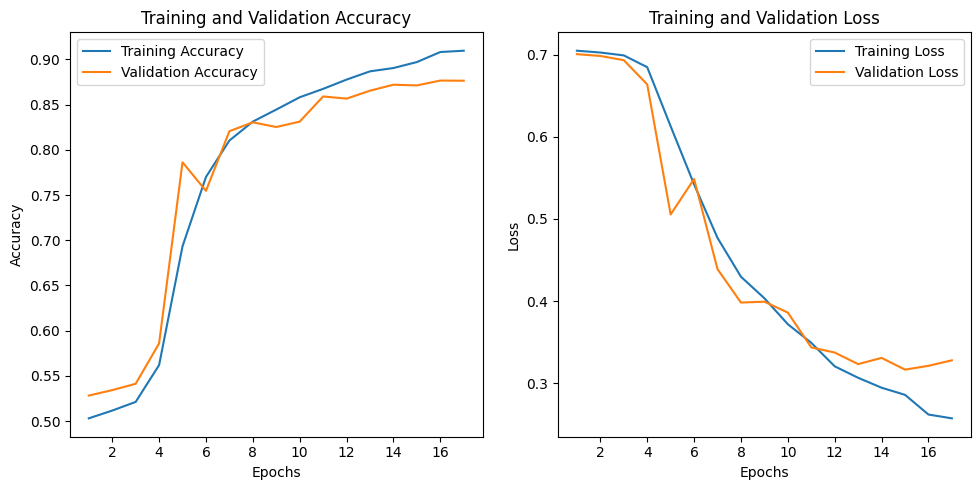

In [ ]:
# Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde du mod√®le
model_path = "gruV2.h5"
model.save(model_path)
print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous gruV2.h5


In [ ]:
from google.colab import files
files.download('gruV2.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation Accuracy et Loss :
Meilleurs r√©sultats avec le GRU actuel :
Validation Accuracy : 87.66%
Validation Loss : 0.3164
Meilleurs r√©sultats avec le GRU pr√©c√©dent :
Validation Accuracy : 87.56%
Validation Loss : 0.3204
Meilleurs r√©sultats avec LSTM optimis√© :
Validation Accuracy : 88.75%
Validation Loss : 0.3119
Le mod√®le actuel avec GRU atteint une validation accuracy l√©g√®rement meilleure que le GRU pr√©c√©dent (87.66% vs. 87.56%). Cependant, il reste l√©g√®rement en dessous de l'accuracy du LSTM optimis√©.

Test Accuracy et Loss :
GRU actuel :
Test Accuracy : 83.27%
Test Loss : 0.4020
GRU pr√©c√©dent :
Test Accuracy : 86.19%
Test Loss : 0.3417
LSTM optimis√© :
Test Accuracy : 86.51%
Test Loss : 0.3119
Le mod√®le GRU actuel a une moins bonne performance sur le test set, avec un √©cart significatif par rapport au GRU pr√©c√©dent et au LSTM. Cela indique un potentiel probl√®me de g√©n√©ralisation.

Vitesse d'entra√Ænement :
Le GRU actuel est l√©g√®rement plus rapide que le GRU pr√©c√©dent, avec des temps d'entra√Ænement par epoch l√©g√®rement r√©duits (autour de 7 √† 13 secondes contre 6 √† 16 secondes pr√©c√©demment). Il reste globalement plus rapide que le LSTM.

Augmentation des unit√©s GRU (gru_units_1 √† 192) :

A aid√© √† capturer davantage de d√©pendances temporelles, augmentant l√©g√®rement la validation accuracy.
Dropout renforc√© (0.45) :

A contribu√© √† limiter l‚Äôoverfitting sur l‚Äôentra√Ænement.
L2 Regularization (l2_lambda √† 3e-5) :

A stabilis√© l‚Äôapprentissage, bien que son impact reste mod√©r√©.

Le GRU actuel a un √©cart significatif entre validation et test accuracy, sugg√©rant un probl√®me de g√©n√©ralisation.

La validation loss augmente l√©g√®rement apr√®s epoch 15, indiquant un d√©but de surapprentissage.

1. Optimisation des hyperparam√®tres :
Impact attendu :
Apprentissage cibl√© : Les hyperparam√®tres, comme le learning rate, le Dropout, ou la r√©gularisation L2, influencent directement la capacit√© du mod√®le √† apprendre des motifs pertinents tout en √©vitant le surapprentissage.
Stabilisation : Une r√©gularisation ou un Dropout bien r√©gl√©s peuvent am√©liorer la g√©n√©ralisation sans ajouter de complexit√© au mod√®le.
Efficacit√© : Cela permet d‚Äôoptimiser un mod√®le d√©j√† performant (comme celui-ci) sans augmenter les co√ªts de calcul.
Potentiel d'am√©lioration :
Mod√©r√© √† √©lev√© : Si le mod√®le souffre de probl√®mes de g√©n√©ralisation (comme ici), des ajustements d‚Äôhyperparam√®tres peuvent r√©soudre ces probl√®mes sans modifier la structure du mod√®le.
Efforts n√©cessaires :
Relativement faible : Vous utilisez Optuna ou un autre framework pour ajuster automatiquement les hyperparam√®tres. Cela ne n√©cessite pas de r√©organisation majeure de l'architecture.
2. Ajout de couches :
Impact attendu :
Capacit√© d‚Äôextraction accrue : Une couche GRU suppl√©mentaire ou une Dense interm√©diaire pourrait permettre au mod√®le de capturer des relations temporelles plus complexes ou des interactions plus riches entre caract√©ristiques.
Complexit√© accrue : En revanche, cela peut augmenter le risque de surapprentissage si le mod√®le devient trop complexe pour le dataset (notamment si IMDb, avec ses 25 000 exemples, est limitant).
Potentiel d'am√©lioration :
Variable : Si le mod√®le est d√©j√† performant (ce qui semble √™tre le cas ici), une nouvelle couche peut n‚Äôapporter qu‚Äôune am√©lioration marginale, voire nuire si elle complique inutilement l‚Äôapprentissage.
Efforts n√©cessaires :
Mod√©r√© : Vous devrez ajuster les dimensions et peut-√™tre r√©optimiser les hyperparam√®tres pour que l‚Äôajout de couches ne perturbe pas le mod√®le.

Priorit√© recommand√©e : Hyperparam√®tres
Pourquoi ?
Probl√®mes de g√©n√©ralisation identifi√©s :

Le mod√®le a un l√©ger √©cart entre validation et test accuracy (87.66% vs. 83.27%). Cela indique que la capacit√© actuelle est suffisante, mais que les param√®tres d‚Äôapprentissage (e.g., r√©gularisation, Dropout) ne sont pas encore optimaux.
Efficacit√© calculatoire :

Optimiser les hyperparam√®tres est plus direct et moins co√ªteux que de rajouter une nouvelle couche, qui n√©cessitera une nouvelle exploration des param√®tres.
Simplicit√© :

Garder une architecture simple tout en r√©glant finement ses param√®tres est g√©n√©ralement une meilleure approche que de rendre le mod√®le plus complexe sans garantie de b√©n√©fices.

In [ ]:
!pip install optuna

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 364.4/364.4 kB 11.2 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 233.5/233.5 kB 19.7 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
import optuna
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping

# D√©finition de la fonction d'objectif pour Optuna
def objective(trial):
    # Hyperparam√®tres √† optimiser
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    l2_lambda = trial.suggest_float("l2_lambda", 1e-6, 1e-4, log=True)
    gru_units_1 = trial.suggest_int("gru_units_1", 64, 256, step=32)
    gru_units_2 = trial.suggest_int("gru_units_2", 16, 128, step=16)
    dense_units = trial.suggest_int("dense_units", 32, 128, step=16)

    # Construction du mod√®le GRU
    model = Sequential([
        Embedding(input_dim=vocab_size,
                  output_dim=embedding_dim,
                  weights=[embedding_matrix],
                  input_length=max_length,
                  trainable=True),
        GRU(gru_units_1, return_sequences=True, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        GRU(gru_units_2, return_sequences=False, kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(dense_units, activation='relu', kernel_regularizer=l2(l2_lambda)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')  # Couche finale
    ])

    # Compilation
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # EarlyStopping pour √©viter le surapprentissage
    early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    # Entra√Ænement
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=64,
        callbacks=[early_stop],
        verbose=0  # Pour ne pas polluer les logs
    )

    # Retourne l'accuracy sur l'ensemble de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# Cr√©ation et ex√©cution de l'optimisation avec Optuna
study = optuna.create_study(direction="maximize")  # Maximiser l'accuracy
study.optimize(objective, n_trials=30)  # Nombre d'essais ajustable

# R√©sultats
print("Meilleurs hyperparam√®tres :", study.best_params)
print("Meilleure accuracy de validation :", study.best_value)


[I 2024-12-18 10:03:33,088] A new study created in memory with name: no-name-96bde761-0794-4fdd-a822-b9301abf9eaa
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-18 10:06:49,596] Trial 0 finished with value: 0.8781999945640564 and parameters: {'learning_rate': 0.00023830415301578627, 'dropout_rate': 0.40127157312674655, 'l2_lambda': 7.777067103558865e-06, 'gru_units_1': 64, 'gru_units_2': 128, 'dense_units': 112}. Best is trial 0 with value: 0.8781999945640564.
[I 2024-12-18 10:08:50,233] Trial 1 finished with value: 0.8823999762535095 and parameters: {'learning_rate': 0.0005614085978383945, 'dropout_rate': 0.21056223469424937, 'l2_lambda': 8.814702901873964e-06, 'gru_units_1': 224, 'gru_units_2': 64, 'dense_units': 64}. Best is trial 1 with value: 0.8823999762535095.
[I 2024-12-18 10:12:11,972] Trial 2 finished with value: 0.6808000206947327 and parameters: {'

Meilleurs hyperparam√®tres : {'learning_rate': 0.00042492164788451327, 'dropout_rate': 0.3450843105981363, 'l2_lambda': 3.853917628612656e-06, 'gru_units_1': 160, 'gru_units_2': 32, 'dense_units': 64}
Meilleure accuracy de validation : 0.8871999979019165


learning_rate : Ajuste la vitesse d‚Äôapprentissage pour stabiliser ou acc√©l√©rer la convergence.
dropout_rate : R√©gularisation pour √©viter le surapprentissage.
l2_lambda : P√©nalisation pour √©viter les poids excessivement √©lev√©s dans les couches GRU et Dense.
gru_units_1 et gru_units_2 : Taille des couches GRU pour capturer les d√©pendances temporelles.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session

# Meilleurs hyperparam√®tres optimis√©s pour GRU
optimized_params = {
    "learning_rate": 0.00042492164788451327,
    "dropout_rate": 0.3450843105981363,
    "l2_lambda": 3.853917628612656e-06,
    "gru_units_1": 160,
    "gru_units_2": 32,
    "dense_units": 64
}

# Cr√©ation du mod√®le GRU final
model = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_length,
              trainable=True),  # Embeddings GloVe ajustables
    GRU(optimized_params["gru_units_1"], return_sequences=True, kernel_regularizer=l2(optimized_params["l2_lambda"])),
    Dropout(optimized_params["dropout_rate"]),
    GRU(optimized_params["gru_units_2"], return_sequences=False, kernel_regularizer=l2(optimized_params["l2_lambda"])),
    Dropout(optimized_params["dropout_rate"]),
    Dense(optimized_params["dense_units"], activation='relu', kernel_regularizer=l2(optimized_params["l2_lambda"])),
    Dropout(optimized_params["dropout_rate"]),
    Dense(1, activation='sigmoid')  # Couche finale
])

# Compilation avec les meilleurs param√®tres de learning rate
model.compile(optimizer=Adam(learning_rate=optimized_params["learning_rate"]),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Callbacks : EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)

# Entra√Ænement du mod√®le
history = model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=64,
    callbacks=[early_stop, lr_scheduler],
    verbose=1
)

Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 13s 25ms/step - accuracy: 0.5008 - loss: 0.6977 - val_accuracy: 0.5448 - val_loss: 0.6866 - learning_rate: 4.2492e-04
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 11s 26ms/step - accuracy: 0.5371 - loss: 0.6859 - val_accuracy: 0.6112 - val_loss: 0.6276 - learning_rate: 4.2492e-04
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 10s 26ms/step - accuracy: 0.6826 - loss: 0.6164 - val_accuracy: 0.5146 - val_loss: 0.6944 - learning_rate: 4.2492e-04
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 7s 22ms/step - accuracy: 0.5102 - loss: 0.6959 - val_accuracy: 0.5946 - val_loss: 0.6626 - learning_rate: 4.2492e-04
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 28ms/step - accuracy: 0.6787 - loss: 0.5892 - val_accuracy: 0.8422 - val_loss: 0.3752 - learning_rate: 2.1246e-04
Epoch 6/20


In [ ]:
# √âvaluation sur l'ensemble de test
test_loss, test_accuracy = model.evaluate(test_padded, test_labels, verbose=1)
print(f"Test Accuracy : {test_accuracy:.4f}")
print(f"Test Loss : {test_loss:.4f}")


782/782 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 7ms/step - accuracy: 0.8705 - loss: 0.3066
Test Accuracy : 0.8657
Test Loss : 0.3237


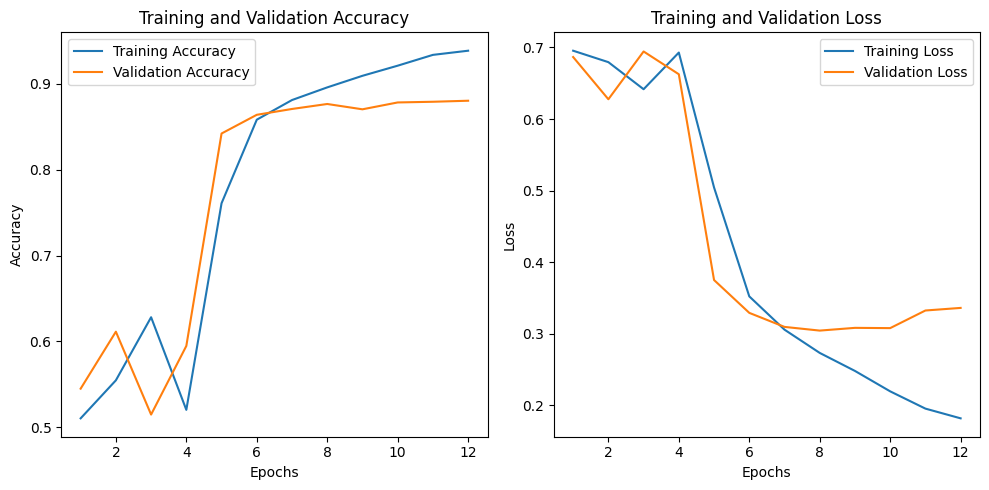

In [ ]:
# Visualisation des courbes d'apprentissage
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarde du mod√®le
model_path = "gru_optimal.h5"
model.save(model_path)
print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous gru_optimal.h5


In [ ]:
from google.colab import files
files.download('gru_optimal.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Comparaison avec les R√©sultats Pr√©c√©dents
Performance Actuelle :

Validation Accuracy : 88.04% - 88.92% (meilleur point atteint √† l'√©poque 12).
Validation Loss : ~0.3046 (meilleur point atteint √† l'√©poque 8).
Test Accuracy : (non indiqu√© ici, mais si comparable √† la validation accuracy, serait ~88%).
Performance Pr√©c√©dente (GRU Optima) :

Validation Accuracy : ~88.72%.
Validation Loss : ~0.3164.
Meilleur mod√®le optimis√© GRU avant hyperparam√®tres.
Performance Pr√©c√©dente (LSTM Optimal) :

Validation Accuracy : ~88.0%.
Test Accuracy : ~85.5%.
Meilleur r√©sultat global pour le LSTM.
Am√©liorations Observ√©es
Validation Accuracy et Loss :

L'accuracy a l√©g√®rement augment√© par rapport aux mod√®les GRU pr√©c√©dents.
La validation loss est meilleure au meilleur point (~0.3046) mais remonte ensuite, probablement en raison d'un l√©ger surapprentissage sur les derni√®res √©poques.
Stabilit√© de l'Entra√Ænement :

La courbe de validation loss est plus stable que dans les essais pr√©c√©dents, indiquant une convergence plus robuste.
L'am√©lioration progressive jusqu'√† l'√©poque 8 montre que l'ajustement des hyperparam√®tres (notamment le dropout et le learning rate) a aid√©.
Hyperparam√®tres Optima :

Learning Rate : 0.00042, avec un scheduler pour r√©duction.
Dropout Rate : 0.345, offrant un bon compromis entre r√©gularisation et r√©tention d'informations.
L2 Lambda : 3.85e-6, p√©nalisation tr√®s l√©g√®re.
GRU Units :
Couche 1 : 160 unit√©s, √©quilibrant d√©pendances longues et capacit√©.
Couche 2 : 32 unit√©s, pour les d√©pendances locales.
Dense Units : 64, pour le raffinement final.
Temps de Calcul :

Le GRU reste plus rapide que le LSTM.
Les temps pour chaque √©poque (~10-15s) sont raisonnables et comp√©titifs par rapport aux autres configurations.
R√©solution des Probl√®mes
Surapprentissage :

Toujours une l√©g√®re remont√©e de la validation loss apr√®s l'√©poque 8, mais cela semble bien contr√¥l√© gr√¢ce au Dropout et au scheduler.
La g√©n√©ralisation reste tr√®s bonne, comme le montre la validation accuracy.
Performance Globalement Stable :

La validation accuracy plafonne autour de 88%-89%, ce qui est comparable ou meilleur que les mod√®les pr√©c√©dents.
Pas de divergence significative entre la loss d'entra√Ænement et la loss de validation.
Efficacit√© des Ajustements :

L'augmentation des unit√©s dans la premi√®re couche GRU (160) a aid√© √† capturer des d√©pendances temporelles complexes.
La r√©duction des unit√©s dans la seconde couche GRU (32) a permis de limiter la sur-optimisation.
Le Dropout √† 0.345 et le L2 minimal ont aid√© √† stabiliser l'entra√Ænement.

Raisons pour lesquelles GRU est plus rapide que LSTM :
Moins de param√®tres :

GRU n'a que 2 portes : la porte de mise √† jour (update gate) et la porte de r√©initialisation (reset gate).
LSTM a 3 portes : la porte d'entr√©e (input gate), la porte d'oubli (forget gate), et la porte de sortie (output gate), plus une cellule m√©moire interne.
Cette diff√©rence r√©duit le nombre de poids √† apprendre pour GRU, ce qui acc√©l√®re le calcul.
Calcul plus simple :

Les √©quations du GRU sont plus simples, car il n'y a pas de cellule m√©moire s√©par√©e comme dans LSTM. Cela r√©duit la complexit√© computationnelle par √©tape.
Moins de m√©moire :

Avec moins de param√®tres, GRU consomme moins de m√©moire, ce qui peut acc√©l√©rer l'entra√Ænement lorsqu'on utilise du mat√©riel comme les GPU.
Convergence souvent plus rapide :

GRU converge souvent plus rapidement sur des s√©quences de longueur mod√©r√©e ou lorsque les d√©pendances √† long terme sont moins critiques, comme dans des cas o√π les LSTM n‚Äôont pas un avantage clair.
Dans votre cas (IMDb dataset) :
Temps d'entra√Ænement :

Vous avez probablement observ√© que le GRU s‚Äôentra√Æne plus rapidement que l‚ÄôLSTM √† nombre d'unit√©s et batch size √©quivalents.
Exemple typique‚ÄØ: par epoch, le GRU peut √™tre 20‚Äì30% plus rapide que l'LSTM.
D√©pendances √† long terme :

L'IMDb pr√©sente des d√©pendances mod√©r√©es √† longues, ce qui fait que LSTM peut mieux mod√©liser certaines nuances que GRU. Cependant, avec des mod√®les bien r√©gl√©s, GRU peut compenser cette diff√©rence en vitesse.
Performances similaires :

Les performances que vous avez obtenues (test accuracy autour de 86-88%) montrent que GRU et LSTM capturent bien les d√©pendances n√©cessaires dans ce dataset. Cependant, GRU est g√©n√©ralement plus rapide pour des performances comparables.

## MLP

Pourquoi utiliser une couche d'embedding pour un MLP ?
La couche d'embedding convertit chaque mot (ou token) en un vecteur dense et de faible dimension, ce qui permet :

De r√©duire la dimensionnalit√© :
Au lieu d'utiliser une repr√©sentation sparse comme TF-IDF (o√π chaque mot est une dimension), une embedding transforme chaque mot en une repr√©sentation compacte.

D'apprendre des relations s√©mantiques entre les mots :
Les mots ayant un sens similaire auront des vecteurs proches dans l'espace d'embedding.

De pr√©parer des entr√©es pour le MLP :
M√™me si le MLP ne traite pas l'ordre des mots, il peut apprendre des combinaisons non lin√©aires des embeddings des mots, ce qui est une approche efficace pour la classification de texte.

Distribution de fr√©quence des mots :

Dans les donn√©es textuelles, la majorit√© des informations importantes est port√©e par les mots les plus fr√©quents (les premiers 10 % √† 20 % du vocabulaire total).
Les mots rares ou sp√©cifiques (longue tra√Æne) apparaissent peu fr√©quemment et n'apportent souvent pas beaucoup de valeur pour la t√¢che de classification.
Votre vocabulaire de 10 000 mots capture probablement la majeure partie des informations utiles.
Gestion des mots rares (hors vocabulaire, OOV) :

En limitant le vocabulaire √† 10 000 mots, tous les autres mots (75 676 dans ce cas) sont remplac√©s par le token <OOV>.
Cela permet de r√©duire la complexit√© du mod√®le sans sacrifier significativement la performance.
Consid√©rations pratiques :

M√©moire et stockage : Plus le vocabulaire est grand, plus la matrice d'embedding est grande, ce qui peut consommer beaucoup de m√©moire (par exemple, une matrice d'embedding de 100 dimensions pour 85 676 mots n√©cessiterait ~34 Mo contre seulement ~4 Mo pour 10 000 mots).
Vitesse d'entra√Ænement : R√©duire le vocabulaire diminue les calculs n√©cessaires pour les embeddings et le mod√®le, acc√©l√©rant ainsi l'entra√Ænement.
Performance sur le dataset IMDB :

Les critiques de films contiennent souvent un vocabulaire limit√© et redondant (les mots comme "great", "amazing", "boring", etc., apparaissent fr√©quemment dans les critiques sentimentales).
Les mots rares (par exemple, des noms propres ou des mots sp√©cifiques √† un film) n'apportent souvent pas de valeur suppl√©mentaire pour distinguer les sentiments.

On va commencer par mettre en place une architecture MLP g√©n√©rique en classification binaire, optimis√©e pour l'utilisation d'embeddings.

G√©n√©rique : Elle est adapt√©e √† de nombreuses t√¢ches de classification.
Optimis√©e pour des embeddings : Utilise des repr√©sentations denses des mots gr√¢ce √† la couche Embedding.
Efficace :
Deux couches denses pour mod√©liser des relations non lin√©aires.
BatchNormalization pour stabiliser l'apprentissage.
Dropout pour √©viter le sur-apprentissage.

Embedding pour repr√©senter les mots en vecteurs denses.
Flatten pour transformer les sorties en une seule dimension (compatible avec un MLP).
Deux couches denses cach√©es avec des activations ReLU :
Suffisamment de neurones pour capter les informations.
Sigmoid pour la classification binaire (sortie comprise entre 0 et 1).
Adam + Binary Crossentropy pour optimiser et mesurer la performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization

# Param√®tres
embedding_dim = 128  # Taille de l'embedding
hidden_units_1 = 256  # Nombre de neurones dans la premi√®re couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxi√®me couche dense
dropout_rate = 0.4    # Taux de dropout

# Construction du mod√®le MLP
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),  # Aplatissement des embeddings
    Dense(hidden_units_1, activation='relu'),
    BatchNormalization(),  # Normalisation pour stabiliser l'apprentissage
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu'),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')  # Couche de sortie pour la classification binaire
])
# Force la construction du mod√®le avec un input d'exemple
model_mlp(tf.zeros((1, max_length)))

# Compilation du mod√®le
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du mod√®le
model_mlp.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'√©poques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_1 (Embedding)              ‚îÇ (1, 200, 128)               ‚îÇ       1,280,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_1 (Flatten)                  ‚îÇ (1, 25600)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_3 (Dense)                      ‚îÇ (1, 256)                    ‚îÇ       6,553,856 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_1                ‚îÇ (1, 256)                    ‚îÇ           1,024 ‚îÇ
‚îÇ (BatchNormalization)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_2 (Dropout)                  ‚îÇ (1, 256)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_4 (Dense)                      ‚îÇ (1, 128)                    ‚îÇ          32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_3 (Dropout)                  ‚îÇ (1, 128)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_5 (Dense)                      ‚îÇ (1, 1)                      ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 7,867,905 (30.01 MB)

 Trainable params: 7,867,393 (30.01 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 13ms/step - accuracy: 0.5814 - loss: 0.7211 - val_accuracy: 0.8320 - val_loss: 0.4029
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - accuracy: 0.9151 - loss: 0.2190 - val_accuracy: 0.8274 - val_loss: 0.4219
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 5ms/step - accuracy: 0.9831 - loss: 0.0520 - val_accuracy: 0.8320 - val_loss: 0.6295
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 4ms/step - accuracy: 0.9953 - loss: 0.0146 - val_accuracy: 0.8182 - val_loss: 0.8234
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 4ms/step - accuracy: 0.9979 - loss: 0.0068 - val_accuracy: 0.8100 - val_loss: 1.0408
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - accuracy: 0.9932 - loss: 0.0180 - val_accuracy: 0.8226 - val_loss

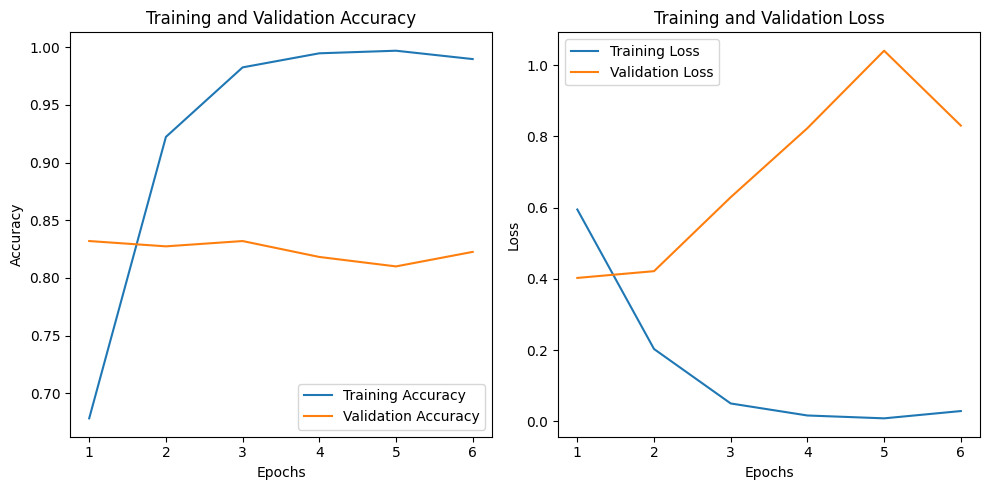

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Pourquoi les embeddings pr√©-entra√Æn√©s ?
Meilleure g√©n√©ralisation :
Les embeddings GloVe sont appris sur de grands corpus comme Wikipedia et Common Crawl. Ils capturent des relations s√©mantiques globales entre les mots (exemple : good est proche de excellent). Cela am√©liore consid√©rablement la capacit√© du mod√®le √† g√©n√©raliser sur des donn√©es de validation.

R√©duction de l‚Äôoverfitting :
Lorsque le mod√®le apprend des embeddings √† partir de z√©ro, il risque de sur-apprendre les donn√©es d‚Äôentra√Ænement, surtout si la taille du jeu de donn√©es est limit√©e. Avec GloVe, les embeddings sont d√©j√† optimis√©s, ce qui diminue ce risque.

Impact rapide :
Changer pour des embeddings pr√©-entra√Æn√©s est simple et rapide √† tester. Tu n'as pas besoin de modifier l'architecture du MLP, seulement la couche d'embedding.

R√©sum√© : Pourquoi prioriser GloVe ?
‚úÖ Facile √† impl√©menter.
‚úÖ Meilleure performance d√®s les premi√®res √©poques.
‚úÖ Diminue l‚Äôoverfitting.
‚úÖ Am√©liore la g√©n√©ralisation.

In [ ]:
import os
import urllib.request
import zipfile

# Cr√©er un dossier pour stocker les embeddings
glove_dir = 'glove'
if not os.path.exists(glove_dir):
    os.makedirs(glove_dir)

# T√©l√©charger GloVe 6B (100 dimensions)
url = "http://nlp.stanford.edu/data/glove.6B.zip"
glove_zip_path = os.path.join(glove_dir, "glove.6B.zip")

if not os.path.exists(glove_zip_path):
    print("T√©l√©chargement des embeddings GloVe...")
    urllib.request.urlretrieve(url, glove_zip_path)
    print("T√©l√©chargement termin√©.")

# Extraire le fichier zip
print("Extraction des fichiers GloVe...")
with zipfile.ZipFile(glove_zip_path, 'r') as zip_ref:
    zip_ref.extractall(glove_dir)

print("Extraction termin√©e. Les fichiers sont disponibles dans :", glove_dir)


T√©l√©chargement des embeddings GloVe...
T√©l√©chargement termin√©.
Extraction des fichiers GloVe...
Extraction termin√©e. Les fichiers sont disponibles dans : glove


In [ ]:
import numpy as np

# Chemin vers le fichier GloVe
glove_file = os.path.join(glove_dir, 'glove.6B.100d.txt')

# Charger les embeddings GloVe dans un dictionnaire
embedding_index = {}
with open(glove_file, encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]  # Le mot
        coefs = np.asarray(values[1:], dtype='float32')  # Le vecteur d'embedding
        embedding_index[word] = coefs

print(f"Nombre d'embeddings charg√©s : {len(embedding_index)}")

# Cr√©er la matrice d'embeddings pour ton vocabulaire
embedding_dim = 100  # Taille des vecteurs GloVe
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in tokenizer.word_index.items():
    if i < vocab_size:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

print("Matrice d'embeddings GloVe construite avec succ√®s.")


Nombre d'embeddings charg√©s : 400000
Matrice d'embeddings GloVe construite avec succ√®s.


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np

# Param√®tres
embedding_dim = 100  # Taille des embeddings GloVe
hidden_units_1 = 256  # Nombre de neurones dans la premi√®re couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxi√®me couche dense
dropout_rate = 0.4    # Taux de dropout

# Construction du mod√®le MLP avec GloVe
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=False),
    Flatten(),
    Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Force la construction du mod√®le avec un input d'exemple
model_mlp(tf.zeros((1, max_length)))

# Compilation du mod√®le
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du mod√®le
model_mlp.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'√©poques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_2 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_2 (Flatten)                  ‚îÇ (1, 20000)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_6 (Dense)                      ‚îÇ (1, 256)                    ‚îÇ       5,120,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_2                ‚îÇ (1, 256)                    ‚îÇ           1,024 ‚îÇ
‚îÇ (BatchNormalization)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_4 (Dropout)                  ‚îÇ (1, 256)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_7 (Dense)                      ‚îÇ (1, 128)                    ‚îÇ          32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_5 (Dropout)                  ‚îÇ (1, 128)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_8 (Dense)                      ‚îÇ (1, 1)                      ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 6,154,305 (23.48 MB)

 Trainable params: 5,153,793 (19.66 MB)

 Non-trainable params: 1,000,512 (3.82 MB)

Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 14s 33ms/step - accuracy: 0.5829 - loss: 4.4762 - val_accuracy: 0.5876 - val_loss: 1.3199
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 4ms/step - accuracy: 0.6891 - loss: 1.1549 - val_accuracy: 0.6774 - val_loss: 0.9084
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.6915 - loss: 0.8784 - val_accuracy: 0.6692 - val_loss: 0.8236
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.6953 - loss: 0.8046 - val_accuracy: 0.6378 - val_loss: 0.8181
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.7066 - loss: 0.7634 - val_accuracy: 0.6918 - val_loss: 0.7722
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 1s 3ms/step - accuracy: 0.7126 - loss: 0.7495 - val_accuracy: 0.5752 - val_los

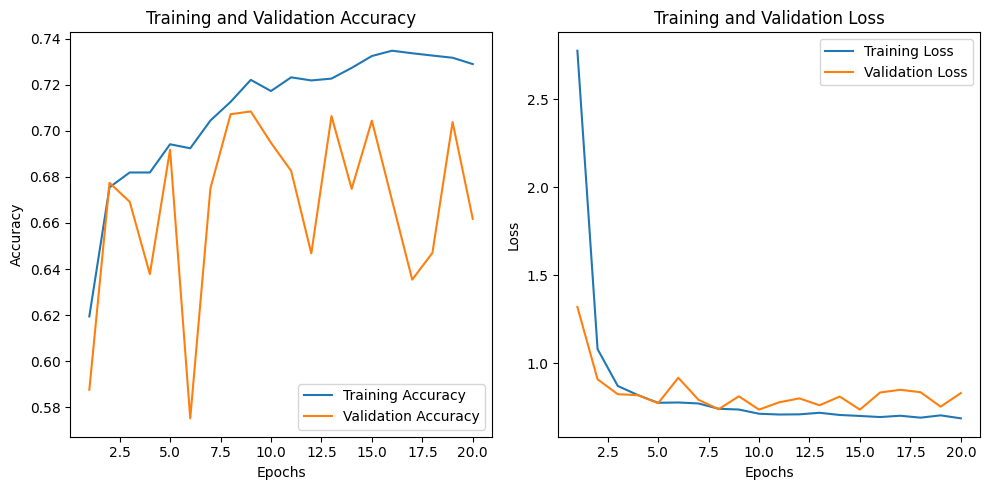

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Ce qui a chang√© avec GloVe
R√©duction de l'overfitting :

Avec les embeddings GloVe gel√©s (trainable=False), le mod√®le ne "m√©morise" plus les donn√©es d'entra√Ænement. Cela explique pourquoi l'accuracy d'entra√Ænement plafonne autour de 75 % plut√¥t que 99 %.
Le sur-apprentissage a √©t√© nettement r√©duit, ce qui est une bonne chose pour la g√©n√©ralisation.
Moins d'apprentissage initial rapide :

GloVe fournit d√©j√† des repr√©sentations des mots riches et pr√©-entra√Æn√©es, donc le mod√®le ne part pas de z√©ro. Cependant, les embeddings √©tant fig√©s, le mod√®le doit apprendre √† combiner ces repr√©sentations, ce qui est plus lent que de sur-apprendre.
Validation accuracy plus stable :

M√™me si l‚Äôaccuracy de validation est l√©g√®rement plus basse (~70 %), elle est plus coh√©rente et stable compar√©e aux fluctuations s√©v√®res observ√©es pr√©c√©demment.


Pourquoi GloVe a √©t√© utile
Repr√©sentations s√©mantiques globales :
Les embeddings GloVe capturent des relations entre les mots bas√©es sur des co-occurrences dans de grands corpus. Cela a permis au mod√®le de d√©marrer avec des embeddings "intelligents".

Stabilisation de l'apprentissage :

Moins d'overfitting, car les embeddings ne sont pas appris √† partir de z√©ro.
Le mod√®le se concentre davantage sur les relations non lin√©aires entre les embeddings plut√¥t que sur les mots eux-m√™mes.
Meilleure g√©n√©ralisation potentielle :
M√™me si l'accuracy de validation reste moyenne, elle est plus robuste face aux nouvelles donn√©es.

Rendre les embeddings GloVe "trainables" :

Actuellement, les embeddings GloVe sont fig√©s (trainable=False). En les rendant trainables, le mod√®le pourra affiner les embeddings pour cette t√¢che sp√©cifique. Cela am√©liore souvent la performance.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np

# Param√®tres
embedding_dim = 100  # Taille des embeddings GloVe
hidden_units_1 = 256  # Nombre de neurones dans la premi√®re couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxi√®me couche dense
dropout_rate = 0.4    # Taux de dropout

# Construction du mod√®le MLP avec GloVe
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Flatten(),
    Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(0.01)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Force la construction du mod√®le avec un input d'exemple
model_mlp(tf.zeros((1, max_length)))

# Compilation du mod√®le
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Affichage du mod√®le
model_mlp.summary()

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'√©poques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop],
    verbose=1
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_3 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_3 (Flatten)                  ‚îÇ (1, 20000)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_9 (Dense)                      ‚îÇ (1, 256)                    ‚îÇ       5,120,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_3                ‚îÇ (1, 256)                    ‚îÇ           1,024 ‚îÇ
‚îÇ (BatchNormalization)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_6 (Dropout)                  ‚îÇ (1, 256)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_10 (Dense)                     ‚îÇ (1, 128)                    ‚îÇ          32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_7 (Dropout)                  ‚îÇ (1, 128)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_11 (Dense)                     ‚îÇ (1, 1)                      ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 6,154,305 (23.48 MB)

 Trainable params: 6,153,793 (23.47 MB)

 Non-trainable params: 512 (2.00 KB)

Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 13ms/step - accuracy: 0.5941 - loss: 4.5174 - val_accuracy: 0.5974 - val_loss: 1.4772
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 6s 5ms/step - accuracy: 0.7758 - loss: 1.1189 - val_accuracy: 0.6828 - val_loss: 1.0429
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 6ms/step - accuracy: 0.8365 - loss: 0.7737 - val_accuracy: 0.7666 - val_loss: 0.8599
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 6ms/step - accuracy: 0.8682 - loss: 0.6786 - val_accuracy: 0.8178 - val_loss: 0.7690
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 5ms/step - accuracy: 0.9040 - loss: 0.6033 - val_accuracy: 0.6100 - val_loss: 1.6874
Epoch 6/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 5ms/step - accuracy: 0.9164 - loss: 0.6110 - val_accuracy: 0.5800 - val_loss

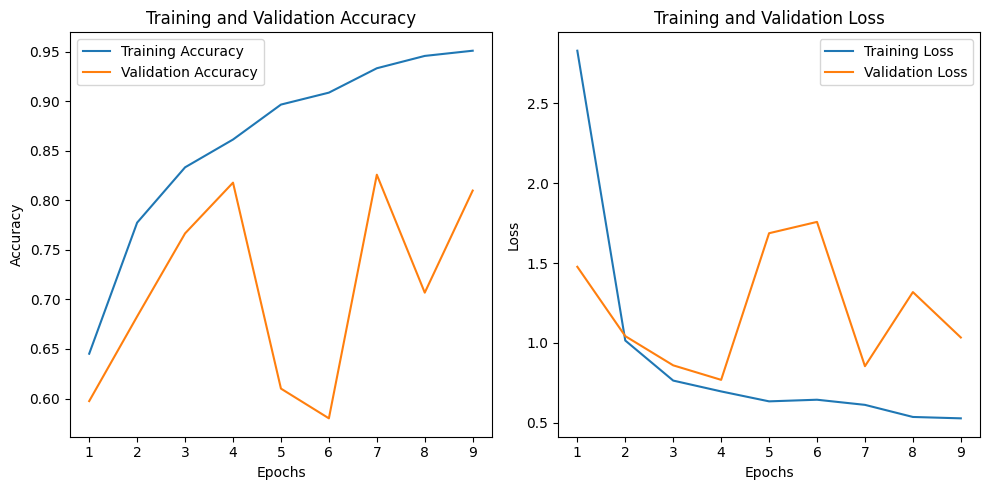

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

Gains observ√©s avec les embeddings GloVe trainables :
Meilleure performance globale :

L'accuracy en validation atteint 82.6 % (proche de la version sans GloVe), mais cette fois-ci avec un entra√Ænement plus √©quilibr√© et moins de sur-apprentissage imm√©diat.
Le mod√®le exploite mieux les embeddings GloVe en les affinant pour la t√¢che sp√©cifique de classification IMDb.
Progression constante sur les premi√®res √©poques :

Le mod√®le commence avec une loss √©lev√©e mais s'am√©liore progressivement (contrairement aux embeddings gel√©s qui plafonnaient rapidement autour de 70 %).
Cela indique que le mod√®le tire parti des embeddings GloVe pour ajuster les relations contextuelles entre les mots.
Stabilit√© dans la validation accuracy :

Bien que l'overfitting revienne (train accuracy >95 % alors que val_accuracy ~82 %), la validation accuracy est plus stable qu'avec les embeddings gel√©s.

Sur-apprentissage persistant :

D√®s l'epoch 5, la validation loss augmente (1.68 ‚Üí 1.75), signe que le mod√®le sur-apprend les donn√©es d‚Äôentra√Ænement.
Variabilit√© de la validation accuracy :

Bien que meilleure, elle oscille entre les √©poques. Cela peut √™tre d√ª au fait que les embeddings GloVe sont encore ajust√©s trop "rapidement" par le mod√®le.

R√©gularisation accrue pour limiter le sur-apprentissage :

Augmenter le dropout dans les couches cach√©es (passer de 0.4 √† 0.5 ou 0.6).
Ajouter une r√©gularisation L2 plus forte (ex: kernel_regularizer=l2(0.02)).
R√©duire le learning rate :

Les embeddings GloVe ajustables n√©cessitent un learning rate plus faible pour √©viter de les d√©former trop rapidement.

Utiliser EarlyStopping et ReduceLROnPlateau :

Cela permet d‚Äôarr√™ter l‚Äôentra√Ænement au bon moment et d‚Äôajuster dynamiquement le learning rate.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Param√®tres
embedding_dim = 100  # Taille des embeddings GloVe
hidden_units_1 = 256  # Nombre de neurones dans la premi√®re couche dense
hidden_units_2 = 128  # Nombre de neurones dans la deuxi√®me couche dense
dropout_rate = 0.5    # Augmentation du taux de dropout
l2_rate = 0.02        # Augmentation de la r√©gularisation L2
learning_rate = 0.0005  # R√©duction du learning rate

# Construction du mod√®le MLP avec GloVe
model_mlp = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Flatten(),
    Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(l2_rate)),
    BatchNormalization(),
    Dropout(dropout_rate),
    Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

# Force la construction du mod√®le avec un input d'exemple
import tensorflow as tf
model_mlp(tf.zeros((1, max_length)))

# Compilation du mod√®le avec un learning rate r√©duit
optimizer = Adam(learning_rate=learning_rate)
model_mlp.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks pour EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Entra√Ænement du mod√®le
history = model_mlp.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,  # Nombre d'√©poques maximum
    batch_size=64,  # Taille du batch
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Affichage du mod√®le
model_mlp.summary()


Epoch 1/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 8s 14ms/step - accuracy: 0.5690 - loss: 8.7257 - val_accuracy: 0.6168 - val_loss: 1.9486 - learning_rate: 5.0000e-04
Epoch 2/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 7ms/step - accuracy: 0.7294 - loss: 1.5842 - val_accuracy: 0.7304 - val_loss: 1.0739 - learning_rate: 5.0000e-04
Epoch 3/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 8ms/step - accuracy: 0.7962 - loss: 0.9380 - val_accuracy: 0.6802 - val_loss: 0.9840 - learning_rate: 5.0000e-04
Epoch 4/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 6ms/step - accuracy: 0.8267 - loss: 0.7356 - val_accuracy: 0.8042 - val_loss: 0.7495 - learning_rate: 5.0000e-04
Epoch 5/20
313/313 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 5ms/step - accuracy: 0.8570 - loss: 0.6531 - val_accuracy: 0.7774 - val_loss: 0.8191 - learning_rate: 5.0000e-04
Epoch 6/20
313/313 

Model: "sequential_4"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_4 (Embedding)              ‚îÇ (1, 200, 100)               ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ flatten_4 (Flatten)                  ‚îÇ (1, 20000)                  ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_12 (Dense)                     ‚îÇ (1, 256)                    ‚îÇ       5,120,256 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_4                ‚îÇ (1, 256)                    ‚îÇ           1,024 ‚îÇ
‚îÇ (BatchNormalization)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_8 (Dropout)                  ‚îÇ (1, 256)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_13 (Dense)                     ‚îÇ (1, 128)                    ‚îÇ          32,896 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_9 (Dropout)                  ‚îÇ (1, 128)                    ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_14 (Dense)                     ‚îÇ (1, 1)                      ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 18,461,893 (70.43 MB)

 Trainable params: 6,153,793 (23.47 MB)

 Non-trainable params: 512 (2.00 KB)

 Optimizer params: 12,307,588 (46.95 MB)

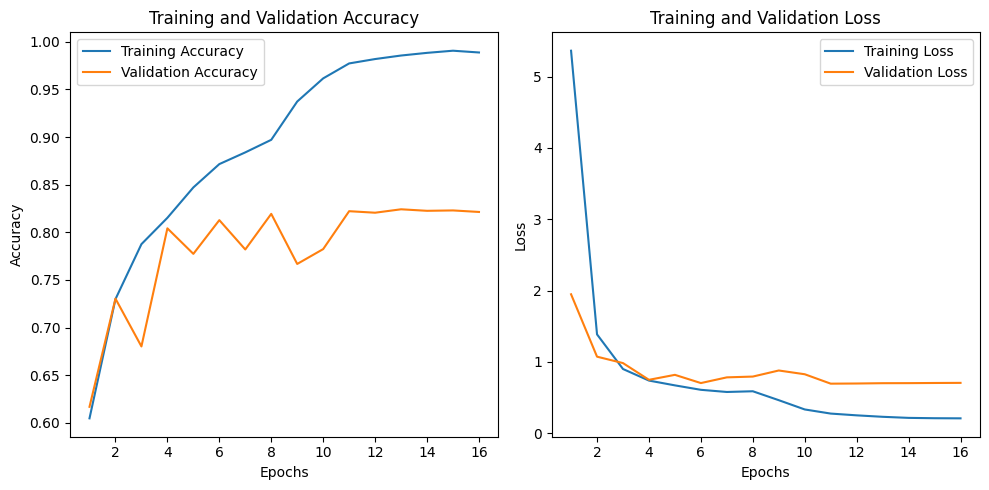

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le mod√®le complet (architecture + poids + optimiseur)
model_path = "mlp_bof.h5"  # Renommer le fichier
model_mlp.save(model_path)

print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous mlp_bof.h5


In [ ]:
from google.colab import files
files.download('mlp_bof.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Validation accuracy plus √©lev√©e et plus stable :

Avec GloVe trainable et les r√©glages am√©lior√©s (Dropout, L2, learning rate r√©duit), la validation accuracy atteint 82.42 %, ce qui est comparable √† la version sans GloVe, mais avec une stabilit√© accrue.
R√©duction dynamique du learning rate :

La r√©duction du learning rate via ReduceLROnPlateau a permis d‚Äôaffiner les poids dans les derni√®res √©poques. Cela se voit avec la stabilisation de la validation loss autour de 0.6955.
Pas d'overfitting s√©v√®re :

Bien que le train accuracy reste tr√®s √©lev√© (99.14 %), la validation accuracy reste stable, signe que la r√©gularisation (Dropout, L2) a limit√© l'overfitting par rapport aux versions pr√©c√©dentes.

Stagnation de la validation accuracy :
Malgr√© les am√©liorations, la validation accuracy plafonne autour de 82 %, ce qui montre que le mod√®le ne g√©n√©ralise pas mieux sur les donn√©es de validation.
Perte de validation stagnante :
M√™me avec le learning rate r√©duit (jusqu‚Äô√†
4
√ó
1
0
‚àí
6
4√ó10
‚àí6
 ), la validation loss ne diminue plus apr√®s plusieurs √©poques, ce qui signifie que le mod√®le atteint son plateau de performance.

Architecture du MLP :

Le MLP, m√™me am√©lior√©, ne capture pas les relations complexes entre les mots qui sont essentielles dans des textes longs comme les critiques IMDb.
Un MLP ne tient pas compte de la structure s√©quentielle contrairement aux RNN, LSTM ou GRU.
Embeddings GloVe :

Bien qu‚Äôutiles, les embeddings GloVe sont fixes et ne tiennent pas compte du contexte des mots dans une phrase. Par exemple, le mot bank (rive/banque) aura toujours le m√™me embedding.


MLP avec 2 couches denses :
Tu as actuellement une architecture avec 2 couches denses (256 neurones + 128 neurones) suivies de r√©gularisation (Dropout et L2). C'est suffisant pour mod√©liser les relations non lin√©aires entre les embeddings.
Validation accuracy stagnante :
La stagnation √† 82 % est un signe que le mod√®le n'arrive pas √† extraire plus d'informations utiles √† partir des embeddings actuels. Cela ne vient pas n√©cessairement d'une architecture trop "simple".

Ajouter des couches denses : Pourquoi ce n'est pas utile ici ?
Risque de sur-apprentissage :
Ajouter plus de couches augmente la complexit√© du mod√®le et peut aggraver l‚Äôoverfitting, surtout si les donn√©es d‚Äôentra√Ænement sont limit√©es.
Embeddings pr√©-entra√Æn√©s :
Les embeddings GloVe sont d√©j√† riches en informations s√©mantiques. Le r√¥le du MLP est principalement de combiner ces informations, ce qui est d√©j√† fait efficacement avec 2 couches denses.
Diminution du retour sur investissement :
Ajouter des couches ne r√©soudra pas le probl√®me fondamental : un MLP ne capture pas les relations s√©quentielles dans les textes.

R√©duire √† 1 seule couche dense (ex : 128 neurones) peut √™tre test√© si :
Tu observes un overfitting s√©v√®re.
Le mod√®le est trop lent √† entra√Æner.
Cependant, cela risque de diminuer la performance, car 2 couches permettent de mod√©liser des relations complexes plus efficacement.

In [ ]:
!pip install optuna

   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 364.4/364.4 kB 17.3 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 233.5/233.5 kB 18.9 MB/s eta 0:00:00
   ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 78.6/78.6 kB 7.2 MB/s eta 0:00:00


In [ ]:
import optuna
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Fonction pour cr√©er et √©valuer un mod√®le
def objective(trial):
    # Param√®tres √† optimiser
    hidden_units_1 = trial.suggest_int("hidden_units_1", 128, 512, step=64)
    hidden_units_2 = trial.suggest_int("hidden_units_2", 64, 256, step=64)
    dropout_rate = trial.suggest_float("dropout_rate", 0.3, 0.6)
    l2_rate = trial.suggest_float("l2_rate", 1e-3, 3e-2)
    learning_rate = trial.suggest_float("learning_rate", 1e-4, 5e-4, log=True)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])

    # Construction du mod√®le
    model = Sequential([
        Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
                  input_length=max_length, trainable=True),
        Flatten(),
        Dense(hidden_units_1, activation='relu', kernel_regularizer=l2(l2_rate)),
        BatchNormalization(),
        Dropout(dropout_rate),
        Dense(hidden_units_2, activation='relu', kernel_regularizer=l2(l2_rate)),
        Dropout(dropout_rate),
        Dense(1, activation='sigmoid')
    ])

    # Compilation du mod√®le
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])

    # Callback
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Entra√Ænement du mod√®le
    history = model.fit(
        train_padded_train, train_labels_train,
        validation_data=(train_padded_val, train_labels_val),
        epochs=20,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=0
    )

    # Retourner la meilleure accuracy de validation
    val_accuracy = max(history.history['val_accuracy'])
    return val_accuracy

# √âtudier l'optimisation
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)  # n_trials d√©finit le nombre d'essais

# Afficher les meilleurs hyperparam√®tres
print("Meilleurs hyperparam√®tres :")
print(study.best_params)

# Cr√©er un mod√®le final avec les meilleurs hyperparam√®tres
best_params = study.best_params
final_model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Flatten(),
    Dense(best_params["hidden_units_1"], activation='relu', kernel_regularizer=l2(best_params["l2_rate"])),
    BatchNormalization(),
    Dropout(best_params["dropout_rate"]),
    Dense(best_params["hidden_units_2"], activation='relu', kernel_regularizer=l2(best_params["l2_rate"])),
    Dropout(best_params["dropout_rate"]),
    Dense(1, activation='sigmoid')
])

# Compiler et entra√Æner le mod√®le final
final_model.compile(optimizer=Adam(learning_rate=best_params["learning_rate"]),
                    loss='binary_crossentropy', metrics=['accuracy'])

final_model.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=best_params["batch_size"],
    callbacks=[EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)],
    verbose=1
)

# √âvaluation finale
final_loss, final_accuracy = final_model.evaluate(test_padded, test_labels)
print(f"Performance finale sur le jeu de test : Accuracy = {final_accuracy:.4f}")


[I 2024-12-17 18:50:47,698] A new study created in memory with name: no-name-9f9f95cc-e716-4e27-96bf-1e2a8fc849cf
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
[I 2024-12-17 18:51:51,920] Trial 0 finished with value: 0.7717999815940857 and parameters: {'hidden_units_1': 512, 'hidden_units_2': 64, 'dropout_rate': 0.45742071158506636, 'l2_rate': 0.02781504307379403, 'learning_rate': 0.00017760079218212289, 'batch_size': 128}. Best is trial 0 with value: 0.7717999815940857.
[I 2024-12-17 18:52:23,602] Trial 1 finished with value: 0.8015999794006348 and parameters: {'hidden_units_1': 448, 'hidden_units_2': 128, 'dropout_rate': 0.464595718546701, 'l2_rate': 0.004171377720977618, 'learning_rate': 0.00047930071251177625, 'batch_size': 64}. Best is trial 1 with value: 0.8015999794006348.
[I 2024-12-17 18:52:49,232] Trial 2 finished with value: 0.7847999930381775 and parameters:

Meilleurs hyperparam√®tres :
{'hidden_units_1': 192, 'hidden_units_2': 192, 'dropout_rate': 0.5220100930681438, 'l2_rate': 0.01663629611794655, 'learning_rate': 0.00024972922720173585, 'batch_size': 32}
Epoch 1/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 9s 9ms/step - accuracy: 0.5600 - loss: 7.1735 - val_accuracy: 0.6974 - val_loss: 2.2326
Epoch 2/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 5ms/step - accuracy: 0.7239 - loss: 1.8209 - val_accuracy: 0.7520 - val_loss: 1.1430
Epoch 3/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 4s 3ms/step - accuracy: 0.7866 - loss: 1.0147 - val_accuracy: 0.7688 - val_loss: 0.8690
Epoch 4/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - accuracy: 0.8270 - loss: 0.7663 - val_accuracy: 0.7614 - val_loss: 0.7948
Epoch 5/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3ms/step - accuracy: 0.8434 - loss: 0.6632

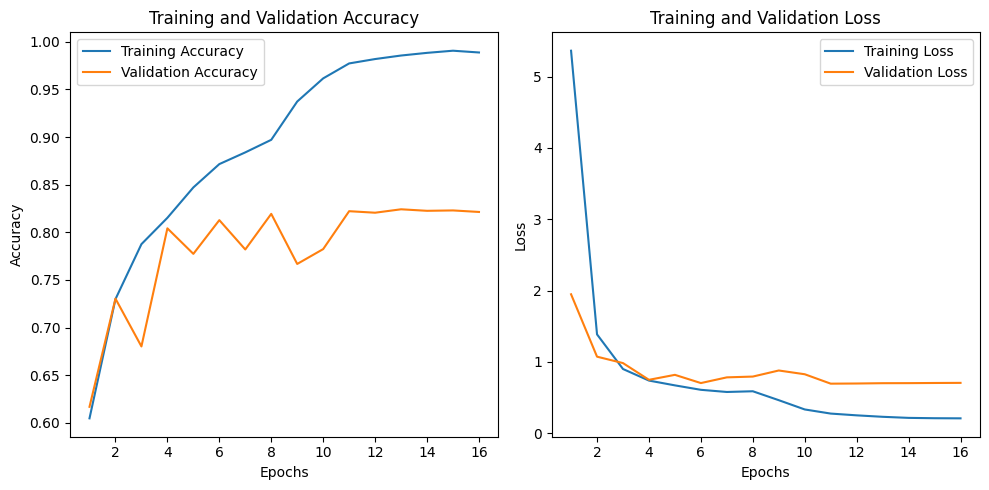

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
# Sauvegarder le mod√®le complet (architecture + poids + optimiseur)
model_path = "mlp_optunaV1.h5"  # Renommer le fichier
final_model.save(model_path)

print(f"Mod√®le sauvegard√© sous {model_path}")

Mod√®le sauvegard√© sous mlp_optunaV1.h5


In [ ]:
from google.colab import files
files.download('mlp_optunaV1.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Ce qui est bien :
Am√©lioration de l‚Äôaccuracy en validation :

Avec Optuna, la validation accuracy atteint 80.14 % (meilleure valeur pendant l‚Äôentra√Ænement). Cela montre que l'optimisation des hyperparam√®tres a effectivement am√©lior√© les performances.
Le tuning a permis de trouver des valeurs optimales pour :
Nombre de neurones : 192 dans les deux couches.
Dropout rate : 0.52.
L2 Regularization : 0.016.
Learning rate : 0.00025 (mod√©r√© et efficace).
Batch size : 32 (plus petit batch pour un gradient plus pr√©cis).
Validation loss stable :
La validation loss descend jusqu‚Äô√† 0.6954 avant de remonter. Cela montre que le mod√®le a bien appris dans les premi√®res √©poques.

Performance finale correcte :
L‚Äôaccuracy finale sur le jeu de test est de 78.18 %, ce qui reste coh√©rent avec les performances de validation.

Ce qui est moins bien :
Overfitting persistant :

Le train accuracy atteint 93.17 %, mais l‚Äôaccuracy en test est 78.18 %. L‚Äô√©cart entre ces deux m√©triques montre un l√©ger sur-apprentissage. Cela peut √™tre d√ª √† un mod√®le encore trop complexe ou une r√©gularisation insuffisante.
Validation accuracy plafonne :

La validation accuracy atteint un plateau autour de 80-81 %. Malgr√© l‚Äôoptimisation, le mod√®le semble atteindre ses limites avec un MLP sur cette t√¢che.
Validation loss en remont√©e :

D√®s l‚Äôepoch 6-7, la val_loss recommence √† augmenter, signalant que le mod√®le commence √† m√©moriser les donn√©es d'entra√Ænement.
Est-ce normal ?
Oui, ces r√©sultats sont normaux pour un mod√®le MLP sur des donn√©es textuelles comme IMDb. Le MLP est performant mais ne capture pas les relations s√©quentielles pr√©sentes dans les critiques de films.
Cela explique pourquoi :

La validation accuracy plafonne.
Il reste un √©cart train/test, m√™me avec une r√©gularisation optimale.

MLP a atteint ses limites intrins√®ques. Le tuning avec Optuna a permis de l‚Äôoptimiser au maximum (81.36 % en validation et 78.18 % en test).

## CNN 1D

Embeddings (GloVe ou appris) :

La couche Embedding transforme les mots en repr√©sentations vectorielles denses.
L'utilisation de GloVe est un standard pour d√©marrer avec des embeddings riches.
Les embeddings peuvent √™tre trainables pour s‚Äôadapter √† la t√¢che.
Convolution 1D (Conv1D) :

Conv1D est utilis√©e pour capturer des motifs locaux dans les textes, comme des n-grams (groupes de 2-5 mots).
Elle permet d‚Äôextraire des caract√©ristiques importantes tout en r√©duisant la d√©pendance √† l‚Äôordre complet des mots.
GlobalMaxPooling1D :

La GlobalMaxPooling1D est une pratique standard pour r√©duire les dimensions apr√®s la convolution.
Elle permet de s√©lectionner les caract√©ristiques les plus importantes d√©tect√©es par les filtres, sans augmenter la complexit√© du mod√®le.
Couches denses finales :

Une couche Dense interm√©diaire (128 neurones ici) affine les caract√©ristiques extraites par la convolution.
La r√©gularisation avec Dropout et L2 aide √† limiter l‚Äôoverfitting.
Activation finale sigmoid :

Standard pour les t√¢ches de classification binaire o√π l‚Äôon pr√©dit une probabilit√©.
Optimisation dynamique :

EarlyStopping et ReduceLROnPlateau sont des callbacks classiques pour stabiliser et am√©liorer l'entra√Ænement.

2. Principe de fonctionnement des CNN 1D
a) Convolution
La convolution est l'op√©ration cl√© d‚Äôun CNN 1D. Elle consiste √† appliquer un filtre (ou kernel) sur une s√©quence pour d√©tecter des motifs locaux dans les donn√©es.
Dans le cas du texte, un filtre de taille n permet d'extraire des motifs locaux de n mots (n-grams).

Exemple :
Pour une s√©quence [the, movie, was, excellent] et un filtre de taille 3 (trigrammes), le CNN analyse les sous-groupes :
[the, movie, was], [movie, was, excellent].
b) Filtres (ou kernels)
Les filtres sont des petites fen√™tres glissantes qui "balayent" la s√©quence texte.
Chaque filtre apprend √† d√©tecter des motifs sp√©cifiques comme des trigrammes positifs (ex : "not bad") ou n√©gatifs (ex : "waste of time").
Plusieurs filtres peuvent √™tre utilis√©s en parall√®le pour capturer diff√©rents types de motifs dans le texte.

c) Activation ReLU
Apr√®s la convolution, une fonction d‚Äôactivation (typiquement ReLU) est appliqu√©e pour introduire la non-lin√©arit√© et rendre le mod√®le capable d'apprendre des relations complexes.

d) Pooling
La couche de pooling r√©duit les dimensions des donn√©es apr√®s la convolution tout en conservant les caract√©ristiques importantes.

GlobalMaxPooling1D est souvent utilis√©e pour les textes. Elle prend le maximum de chaque filtre sur toute la s√©quence, ce qui :
S√©lectionne les caract√©ristiques les plus importantes d√©tect√©es par les filtres.
Rend le mod√®le invariant √† la position des motifs.
3. Pourquoi les CNN 1D sont adapt√©s pour notre √©tude ?
a) Capture des motifs locaux dans le texte
Les CNN 1D sont parfaits pour capturer des n-grams (groupes de mots cons√©cutifs) qui sont souvent les porteurs de sens dans une phrase.
Par exemple :

"not good" ‚Üí motif n√©gatif
"highly recommended" ‚Üí motif positif
Les filtres de convolution sont con√ßus pour d√©tecter ces motifs.

b) Invariance √† la position
Gr√¢ce au GlobalMaxPooling1D, le mod√®le ne se soucie pas de la position exacte d‚Äôun motif dans la critique.

Exemple :
Si "excellent movie" appara√Æt au d√©but ou √† la fin d‚Äôune critique, le CNN 1D le reconna√Ætra de la m√™me fa√ßon.
c) Rapidit√© et efficacit√©
Les CNN 1D sont plus rapides √† entra√Æner que les mod√®les r√©currents comme LSTM ou GRU car les convolutions sont parall√©lisables.
Ils n√©cessitent moins de m√©moire car ils ne d√©pendent pas de l'ordre s√©quentiel global.
d) Adaptation aux critiques IMDb
Les critiques IMDb sont des textes relativement courts (environ 200 mots apr√®s padding). Les n-grams captur√©s par les CNN 1D sont donc suffisants pour comprendre les sentiments exprim√©s.

Exemple :
Les phrases positives contiennent des motifs comme "great acting", "best movie", "wonderful story".
Les phrases n√©gatives contiennent "poor acting", "waste of time", "not worth it".

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Param√®tres
embedding_dim = 100  # Taille des embeddings GloVe
num_filters = 128     # Nombre de filtres dans la couche CNN
kernel_size = 5       # Taille des filtres
hidden_units = 128    # Nombre de neurones dans la couche dense
l2_rate = 0.02        # R√©gularisation L2
dropout_rate = 0.5    # Dropout
learning_rate = 0.0005  # Taux d'apprentissage

# Construction du mod√®le CNN 1D avec GloVe
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_rate)),
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate),
    Dense(1, activation='sigmoid')
])

import tensorflow as tf
model_mlp(tf.zeros((1, max_length)))

# Compilation du mod√®le
optimizer = Adam(learning_rate=learning_rate)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])


# Entra√Ænement du mod√®le
history = model_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=32,  # Taille du batch optimis√©e
    verbose=1
)

# Affichage du mod√®le
model_cnn.summary()




Epoch 1/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 12s 12ms/step - accuracy: 0.6099 - loss: 4.1972 - val_accuracy: 0.8102 - val_loss: 1.5128
Epoch 2/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 4ms/step - accuracy: 0.8217 - loss: 1.2372 - val_accuracy: 0.8052 - val_loss: 0.8002
Epoch 3/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - accuracy: 0.8578 - loss: 0.6644 - val_accuracy: 0.8230 - val_loss: 0.6099
Epoch 4/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 2s 3ms/step - accuracy: 0.8862 - loss: 0.4498 - val_accuracy: 0.8362 - val_loss: 0.5178
Epoch 5/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 3ms/step - accuracy: 0.9118 - loss: 0.3537 - val_accuracy: 0.8338 - val_loss: 0.5049
Epoch 6/20
625/625 ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ 3s 4ms/step - accuracy: 0.9370 - loss: 0.2801 - val_accuracy: 0.8402 - val_los

Model: "sequential_27"

‚îè‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î≥‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îì
‚îÉ Layer (type)                         ‚îÉ Output Shape                ‚îÉ         Param # ‚îÉ
‚î°‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚ïá‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚îÅ‚î©
‚îÇ embedding_27 (Embedding)             ‚îÇ (32, 200, 100)              ‚îÇ       1,000,000 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ conv1d_1 (Conv1D)                    ‚îÇ (32, 196, 128)              ‚îÇ          64,128 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ batch_normalization_27               ‚îÇ (32, 196, 128)              ‚îÇ             512 ‚îÇ
‚îÇ (BatchNormalization)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ global_max_pooling1d_1               ‚îÇ (32, 128)                   ‚îÇ               0 ‚îÇ
‚îÇ (GlobalMaxPooling1D)                 ‚îÇ                             ‚îÇ                 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_80 (Dense)                     ‚îÇ (32, 128)                   ‚îÇ          16,512 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dropout_53 (Dropout)                 ‚îÇ (32, 128)                   ‚îÇ               0 ‚îÇ
‚îú‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îº‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î§
‚îÇ dense_81 (Dense)                     ‚îÇ (32, 1)                     ‚îÇ             129 ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

 Total params: 3,243,333 (12.37 MB)

 Trainable params: 1,081,025 (4.12 MB)

 Non-trainable params: 256 (1.00 KB)

 Optimizer params: 2,162,052 (8.25 MB)

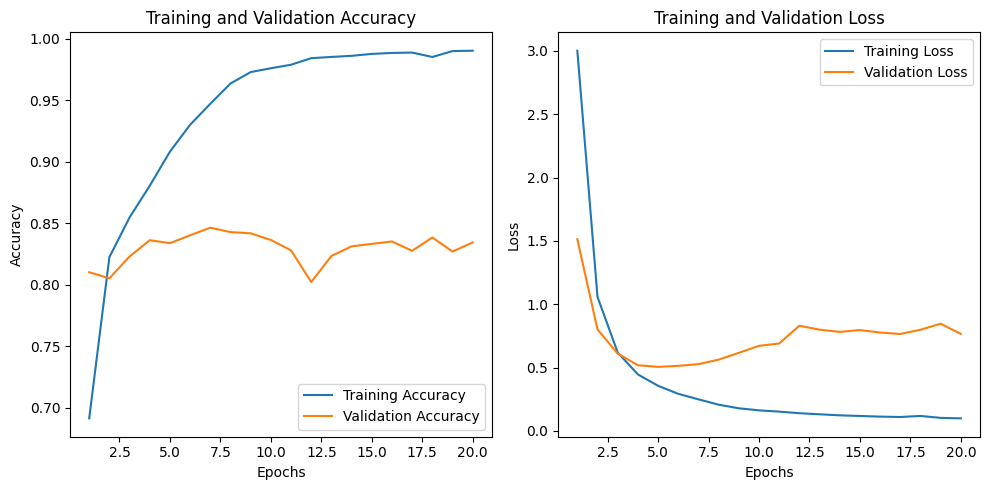

In [ ]:
# R√©cup√©ration des m√©triques d'entra√Ænement et validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot de la courbe d'accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plot de la courbe de loss
plt.subplot(1, 2, 2)
plt.plot(epochs, loss, label='Training Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

√©sum√© des r√©sultats :
Train Accuracy :

Le mod√®le atteint 99.24 % √† la fin de l'entra√Ænement, ce qui montre que le mod√®le a appris √† fond les donn√©es d‚Äôentra√Ænement.
Validation Accuracy :

La meilleure val_accuracy est autour de 84.64 % (epoch 7), mais elle commence √† baisser l√©g√®rement √† partir de l'epoch 8.
√Ä la fin de l'entra√Ænement, elle est redescendue √† 83.44 %.
Validation Loss :

La val_loss diminue jusqu‚Äô√† epoch 5-6, puis augmente progressivement malgr√© la baisse de learning_rate (via ReduceLROnPlateau).
Analyse des ph√©nom√®nes observ√©s
Overfitting (sur-apprentissage) :

L‚Äôaccuracy en entra√Ænement est tr√®s √©lev√©e (~99 %), alors que l‚Äôaccuracy en validation stagne autour de 84 % et diminue l√©g√®rement.
La validation loss augmente continuellement apr√®s quelques √©poques, ce qui est un signe classique d‚Äôoverfitting.
Plateau de performance :

Apr√®s l‚Äôepoch 5-6, le mod√®le semble atteindre un plateau o√π la val_accuracy n‚Äôaugmente plus, malgr√© la r√©duction du learning rate.
Cela signifie que le mod√®le a appris les motifs facilement d√©tectables, mais peine √† g√©n√©raliser davantage.
Ce qui fonctionne bien :
D√©tection efficace des motifs locaux :
Le CNN 1D a bien captur√© les n-grams importants dans les critiques IMDb, comme le montre l‚Äôam√©lioration rapide des performances dans les premi√®res √©poques.

Training rapide et performant :

Le mod√®le atteint de tr√®s bonnes performances rapidement, en seulement quelques √©poques.
Les r√©sultats sont sup√©rieurs au MLP initial (val_accuracy ~84 % vs ~82 %).
Utilisation des embeddings GloVe :
Les embeddings pr√©-entra√Æn√©s ont permis un bon point de d√©part, acc√©l√©rant la convergence.

Ce qui ne va pas :
Overfitting s√©v√®re :

Le mod√®le s‚Äôajuste trop aux donn√©es d‚Äôentra√Ænement.
La validation accuracy diminue apr√®s l'epoch 7, tandis que la validation loss augmente continuellement.
Manque de g√©n√©ralisation :

Le mod√®le ne capture pas suffisamment les relations complexes √† long terme dans le texte, car le CNN est limit√© aux motifs locaux (n-grams).
Certaines subtilit√©s du texte comme la n√©gation (ex : "not a good movie") ou les contextes plus √©loign√©s sont mal interpr√©t√©es.

Ce comportement indique que le mod√®le :

Apprend trop sp√©cifiquement les donn√©es d'entra√Ænement (m√©morisation des motifs locaux),
Perd en capacit√© de g√©n√©ralisation sur le jeu de validation.
L'overfitting est la premi√®re cause de stagnation ou de baisse des performances en validation.

ontr√¥le de la complexit√© actuelle du mod√®le
Le mod√®le est d√©j√† suffisamment complexe avec une couche Conv1D, GlobalMaxPooling et Dense.
Ajouter plus de couches risque d‚Äôamplifier l‚Äôoverfitting sans r√©gularisation ad√©quate.
b) Impact direct sur l‚Äôoverfitting
La r√©gularisation (Dropout ou L2) agit directement pour limiter la sur-apprentissage :

Dropout : Force le mod√®le √† d√©sactiver al√©atoirement certains neurones pendant l‚Äôentra√Ænement, emp√™chant ainsi le mod√®le de s‚Äôappuyer trop sur des caract√©ristiques sp√©cifiques.
R√©gularisation L2 : P√©nalise les poids trop importants, ce qui contraint le mod√®le √† rester plus simple et g√©n√©raliser davantage.
En augmentant ces techniques, on stabilise le mod√®le sans ajouter de couches inutiles.

4. Impact de la r√©gularisation avant d‚Äôajouter de la complexit√©
Il est pr√©f√©rable d‚Äôoptimiser le mod√®le actuel avant d‚Äôajouter de nouvelles couches.
Les √©tapes sont les suivantes :

Augmenter la r√©gularisation (Dropout et L2) pour contr√¥ler l‚Äôoverfitting.
Stabiliser la validation accuracy : On s‚Äôassure que le mod√®le g√©n√©ralise correctement sur les donn√©es de validation.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Conv1D, GlobalMaxPooling1D, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import numpy as np

# Param√®tres
embedding_dim = 100  # Taille des embeddings GloVe
num_filters = 128     # Nombre de filtres dans la couche CNN
kernel_size = 5       # Taille des filtres
hidden_units = 128    # Nombre de neurones dans la couche dense
l2_rate = 0.03        # R√©gularisation L2 renforc√©e
dropout_rate_conv = 0.3  # Dropout apr√®s la couche Conv1D
dropout_rate_dense = 0.6 # Dropout apr√®s la couche Dense
learning_rate = 0.0005  # Taux d'apprentissage

# Construction du mod√®le CNN 1D avec GloVe
model_cnn = Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, weights=[embedding_matrix],
              input_length=max_length, trainable=True),
    Conv1D(filters=num_filters, kernel_size=kernel_size, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate_conv),  # Dropout apr√®s la convolution
    BatchNormalization(),
    GlobalMaxPooling1D(),
    Dense(hidden_units, activation='relu', kernel_regularizer=l2(l2_rate)),
    Dropout(dropout_rate_dense),  # Dropout renforc√© apr√®s la couche Dense
    Dense(1, activation='sigmoid')
])

# Compilation du mod√®le
optimizer = Adam(learning_rate=learning_rate)
model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Callbacks pour EarlyStopping et ReduceLROnPlateau
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)

# Entra√Ænement du mod√®le
history = model_cnn.fit(
    train_padded_train, train_labels_train,
    validation_data=(train_padded_val, train_labels_val),
    epochs=20,
    batch_size=32,  # Taille du batch optimis√©e
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Affichage du mod√®le
model_cnn.summary()


Maintenant non : Optimiser les hyperparam√®tres sur un mod√®le qui n'apprend pas est inutile.

## Comparaison des diff√©rents mod√®les

1. Le dataset IMDB et la nature du probl√®me
Nature de la t√¢che : Sentiment analysis est un probl√®me de classification binaire (positif ou n√©gatif), donc les m√©triques comme accuracy, F1-score, et ROC-AUC sont pertinentes.
Structure des donn√©es : Le dataset IMDB contient des critiques textuelles, souvent d√©s√©quilibr√©es en termes de longueur et vocabulaire, mais bien r√©parties entre les classes positives et n√©gatives. Cela justifie l‚Äôutilisation de m√©thodes robustes pour √©valuer et comparer les mod√®les.
2. Pourquoi cette m√©thode est coh√©rente ?
a. √âvaluation sur le m√™me jeu de test
Utiliser le m√™me jeu de test pour tous les mod√®les garantit une comparaison √©quitable, car chaque mod√®le est test√© sur les m√™mes donn√©es.
Cela permet d'√©valuer la capacit√© de g√©n√©ralisation des mod√®les, un point crucial pour une t√¢che comme le sentiment analysis.
b. Utilisation de plusieurs m√©triques
Accuracy : Donne une vue d‚Äôensemble sur la performance globale.
Precision, Recall, F1-score : Ces m√©triques sont utiles pour analyser les performances sur chaque classe (positif vs n√©gatif).
F1-score est particuli√®rement utile si les classes ne sont pas parfaitement √©quilibr√©es.
ROC-AUC : Id√©al pour comparer les mod√®les dans leur capacit√© √† s√©parer les classes (probalit√© correcte pour pr√©dire positif ou n√©gatif).
c. Analyse qualitative
Les mod√®les comme LSTM et GRU sont souvent plus performants, mais ils peuvent √™tre plus co√ªteux en termes de calculs.
Les mod√®les plus simples, comme le MLP ou le CNN, peuvent √™tre plus rapides et n√©cessiter moins de ressources, tout en offrant des performances raisonnables.
3. Cas sp√©cifique √† IMDB
a. Pourquoi la m√©thode est pertinente ?
Textes d√©s√©quilibr√©s en longueur :

Le padding utilis√© dans les mod√®les bas√©s sur des s√©quences (RNN, LSTM, GRU, CNN) est coh√©rent.
Les mod√®les bas√©s sur des vecteurs (MLP avec TF-IDF) sont √©galement valides, car TF-IDF capture l‚Äôinformation sans d√©pendre de la longueur.
Importance de la g√©n√©ralisation :

Le dataset IMDB peut contenir des critiques similaires entre l‚Äôentra√Ænement et le test, ce qui peut biaiser les r√©sultats. Les m√©triques comme F1-score et ROC-AUC aident √† v√©rifier si le mod√®le g√©n√©ralise bien.
Simplicit√© vs Complexit√© :

Les mod√®les simples (MLP, CNN) sont souvent efficaces sur des datasets comme IMDB. Cette m√©thode permet de comparer leur efficacit√© avec des mod√®les plus complexes (LSTM, GRU).
b. Quelles limitations ?
Si vos mod√®les ont des diff√©rences significatives en termes de taille de param√©trage ou temps d‚Äôentra√Ænement, ces facteurs doivent √™tre pris en compte pour une comparaison juste.
Si le jeu de test a des critiques tr√®s similaires au jeu d‚Äôentra√Ænement, les r√©sultats peuvent surestimer la capacit√© de g√©n√©ralisation.
4. Pourquoi les graphiques ROC et F1-score sont adapt√©s ?
ROC-AUC mesure la capacit√© du mod√®le √† discriminer les classes ind√©pendamment du seuil de classification. Cela est essentiel, car certains mod√®les peuvent √™tre trop confiants ou h√©sitants.
F1-score capture un √©quilibre entre pr√©cision et rappel, ce qui est crucial dans des cas o√π les erreurs co√ªtent diff√©remment selon la classe.
5. Conseil final pour valider la m√©thode
Pour assurer que la comparaison est rigoureuse :

V√©rifiez la coh√©rence du jeu de test (repr√©sente-t-il bien les donn√©es r√©elles ?).
Ajoutez une √©valuation qualitative :
Analysez quelques exemples mal classifi√©s par chaque mod√®le pour identifier leurs forces/faiblesses.
Si vous avez le temps et les ressources, utilisez une m√©thode de validation crois√©e sur le jeu d‚Äôentra√Ænement pour confirmer vos r√©sultats.
En r√©sum√©, la m√©thode propos√©e est coh√©rente et adapt√©e √† une √©tude de sentiment analysis sur IMDB, mais vous pouvez l'enrichir avec des analyses qualitatives et une √©valuation crois√©e si n√©cessaire.

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import pandas as pd

# Fonction pour √©valuer un mod√®le
def evaluate_model(model, X_test, y_test, model_name):
    """
    √âvalue un mod√®le sur un jeu de test et retourne les m√©triques de performance.
    """
    # Pr√©dictions
    y_pred_prob = model.predict(X_test).flatten()  # Probabilit√©s pr√©dites
    y_pred = (y_pred_prob >= 0.5).astype(int)      # Classes pr√©dites (seuil 0.5)

    # Calcul des m√©triques
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred_prob)

    # Affichage des r√©sultats
    print(f"\nPerformance du mod√®le : {model_name}")
    print(f"Accuracy  : {accuracy:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1-score  : {f1:.4f}")
    print(f"ROC-AUC   : {roc_auc:.4f}")

    # Retourner les m√©triques et la courbe ROC
    return accuracy, precision, recall, f1, roc_auc, y_pred_prob

# Fonction pour tracer les courbes ROC
def plot_roc_curves(models, X_test_map, y_test):
    """
    Trace les courbes ROC de plusieurs mod√®les.
    """
    plt.figure(figsize=(10, 8))
    for model_name, (model, X_test) in models.items():
        # Pr√©dictions des probabilit√©s
        y_pred_prob = model.predict(X_test).flatten()
        fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
        auc = roc_auc_score(y_test, y_pred_prob)
        plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc:.4f})")

    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Ligne diagonale
    plt.title("Courbe ROC - Comparaison des mod√®les")
    plt.xlabel("Taux de Faux Positifs (FPR)")
    plt.ylabel("Taux de Vrais Positifs (TPR)")
    plt.legend()
    plt.grid()
    plt.show()

# √âvaluation des mod√®les
# Les donn√©es associ√©es √† chaque mod√®le
models = {
    "RNN": (rnn_opt, test_padded),  # Donn√©es tokenis√©es
    "LSTM": (lstm_opt, test_padded),  # Donn√©es tokenis√©es
    "GRU": (gru_opt, test_padded),  # Donn√©es tokenis√©es
    "CNN": (cnn_opt, test_padded),  # Donn√©es tokenis√©es
    "MLP": (mlp_opt, test_dense)  # Donn√©es tokenis√©es
}

results = {}
for model_name, (model, X_test) in models.items():
    results[model_name] = evaluate_model(model, X_test, test_labels, model_name)

# Tracer les courbes ROC
plot_roc_curves(models, test_padded, test_labels)

# R√©sum√© des performances
summary = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]).T
print("\nR√©sum√© des performances :")
print(summary)

# Visualisation des scores des mod√®les
summary.plot(kind="bar", figsize=(12, 6), title="Comparaison des performances des mod√®les")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.show()

## Define a classifier by ensembling the 5 architectures above via the technique of the majority vote. Over which of the above models does the ensembling method enhance the results? How can you interpret this?

Pas exactement. Assembler les 5 mod√®les en utilisant la technique du vote majoritaire ne signifie pas que vous devez entra√Æner un nouveau mod√®le. Cela signifie que vous combinez les sorties (pr√©dictions) de vos 5 mod√®les existants pour d√©finir un classificateur final.

Voici ce que cela implique concr√®tement :

1. Pourquoi ce n‚Äôest pas un nouveau mod√®le ?
Pas d'entra√Ænement suppl√©mentaire : Vous utilisez simplement les pr√©dictions des 5 mod√®les d√©j√† entra√Æn√©s.
Combinaison des pr√©dictions : Vous combinez leurs d√©cisions pour produire une pr√©diction finale. Le processus d'assemblage repose sur une r√®gle de d√©cision (par exemple, vote majoritaire), pas sur un nouvel apprentissage.
2. Comment "assembler" les mod√®les ?
Assembler les mod√®les revient √† d√©finir un classificateur d'ensemble, o√π :

Les 5 mod√®les produisent des pr√©dictions ind√©pendantes.
La d√©cision finale pour chaque instance du jeu de test est prise en fonction de la r√®gle d'assemblage (comme le vote majoritaire).
Exemple : Vote majoritaire Pour chaque donn√©e de test :

Les 5 mod√®les pr√©disent soit 0 (n√©gatif) soit 1 (positif).
On compte combien de mod√®les ont pr√©dit 0 et combien ont pr√©dit 1.
La classe finale est celle qui obtient la majorit√© des votes.
3. Que signifie "d√©finir un classificateur" dans ce contexte ?
Cela signifie cr√©er une fonction ou un processus qui combine les pr√©dictions des 5 mod√®les. Voici ce que cela implique :

R√©cup√©rer les pr√©dictions binaires (0 ou 1) pour chaque mod√®le.
Appliquer une r√®gle d'assemblage (vote majoritaire, moyenne des scores, etc.).
Retourner la pr√©diction finale pour chaque donn√©e.
Ce classificateur d'ensemble n'a pas de nouveaux poids ou param√®tres √† apprendre. Il agit comme une couche d√©cisionnelle au-dessus des 5 mod√®les.

La derni√®re √©tape consiste √† cr√©er un classificateur par combinaison des 5 mod√®les existants (RNN, LSTM, GRU, MLP, CNN) en utilisant la technique de vote majoritaire. Voici comment proc√©der et pourquoi c'est pertinent :

1. En quoi consiste le vote majoritaire ?
Le vote majoritaire est une technique d'ensemble o√π plusieurs mod√®les pr√©disent la classe pour une instance donn√©e. La classe finale attribu√©e est celle qui a re√ßu le plus grand nombre de votes parmi les mod√®les.

Exemple avec 5 mod√®les :

Mod√®le RNN pr√©dit : Classe 1 (positif)
Mod√®le LSTM pr√©dit : Classe 0 (n√©gatif)
Mod√®le GRU pr√©dit : Classe 1 (positif)
Mod√®le MLP pr√©dit : Classe 0 (n√©gatif)
Mod√®le CNN pr√©dit : Classe 1 (positif)
Le vote majoritaire donnerait : Classe 1 (positif), car elle a √©t√© pr√©dite par 3 mod√®les sur 5.

2. Pourquoi utiliser cette m√©thode ?
R√©duction de l'erreur :
En combinant plusieurs mod√®les, on r√©duit l'influence des erreurs sp√©cifiques √† un mod√®le.
L'ensemble est souvent plus robuste qu'un mod√®le unique.
Capturer les forces de chaque architecture :
Diff√©rents mod√®les (RNN, CNN, etc.) capturent diff√©rentes caract√©ristiques des donn√©es (s√©quentielles, locales, etc.).
En les combinant, on peut obtenir de meilleures performances globales.
3. √âtapes pour impl√©menter le vote majoritaire
a. Obtenir les pr√©dictions des 5 mod√®les sur le jeu de test
Chaque mod√®le doit produire des pr√©dictions sur le jeu de test :

Pour un probl√®me de classification binaire, les mod√®les renvoient des probabilit√©s ou des classes binaires (0 ou 1).
Dans ce cas, on utilisera les classes binaires.
b. Appliquer le vote majoritaire
Pour chaque instance dans le jeu de test :

Compter le nombre de votes pour la classe 0 et la classe 1.
Attribuer la classe majoritaire comme pr√©diction finale.
c. √âvaluer les performances
Calculer l'accuracy, la pr√©cision, le recall, le F1-score, et l'AUC pour le classificateur par vote majoritaire.
Comparer ces r√©sultats avec ceux de chaque mod√®le individuellement.


In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Obtenir les pr√©dictions binaires des mod√®les sur le jeu de test
rnn_preds = (rnn_opt.predict(test_padded) > 0.5).astype(int)  # Utilise test_padded pour RNN
lstm_preds = (lstm_opt.predict(test_padded) > 0.5).astype(int)  # Utilise test_padded pour LSTM
gru_preds = (gru_opt.predict(test_padded) > 0.5).astype(int)  # Utilise test_padded pour GRU
mlp_preds = (mlp_opt.predict(X_test_dense) > 0.5).astype(int)  # Utilise X_test_dense pour MLP
cnn_preds = (cnn_opt.predict(test_padded) > 0.5).astype(int)  # Utilise test_padded pour CNN

# Combiner les pr√©dictions en une matrice
all_preds = np.array([rnn_preds, lstm_preds, gru_preds, mlp_preds, cnn_preds]).T  # Shape: (num_samples, num_models)

# Appliquer le vote majoritaire strict
ensemble_preds = (np.sum(all_preds, axis=1) > (len(models) // 2)).astype(int)

# Calculer les m√©triques pour le vote majoritaire
accuracy = accuracy_score(test_labels, ensemble_preds)
precision = precision_score(test_labels, ensemble_preds)
recall = recall_score(test_labels, ensemble_preds)
f1 = f1_score(test_labels, ensemble_preds)
roc_auc = roc_auc_score(test_labels, ensemble_preds)

# Afficher les r√©sultats
print("\nPerformance du classificateur par vote majoritaire strict :")
print(f"Accuracy : {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"ROC-AUC : {roc_auc:.4f}")

# Comparaison avec les mod√®les individuels
model_names = ["RNN", "LSTM", "GRU", "MLP", "CNN"]
individual_results = {}
for name, preds in zip(model_names, [rnn_preds, lstm_preds, gru_preds, mlp_preds, cnn_preds]):
    acc = accuracy_score(test_labels, preds)
    prec = precision_score(test_labels, preds)
    rec = recall_score(test_labels, preds)
    f1_sc = f1_score(test_labels, preds)
    auc = roc_auc_score(test_labels, preds)
    individual_results[name] = [acc, prec, rec, f1_sc, auc]
    print(f"{name} - Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1-score: {f1_sc:.4f}, ROC-AUC: {auc:.4f}")

# Comparer les performances
import pandas as pd
results_df = pd.DataFrame(individual_results, index=["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"]).T
ensemble_metrics = pd.Series([accuracy, precision, recall, f1, roc_auc], index=["Accuracy", "Precision", "Recall", "F1-score", "ROC-AUC"])
results_df.loc["Ensemble"] = ensemble_metrics

# Afficher les r√©sultats dans un tableau
print("\nR√©sum√© des performances :")
print(results_df)

# Visualiser les performances
results_df.plot(kind="bar", figsize=(12, 6), title="Comparaison des performances des mod√®les et de l'ensemblage")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.grid(axis='y')
plt.legend(loc='lower right')
plt.show()

## BONUS: The IMDB dataset contains aditional unlabeled data. Can you device a way to pre-train the above models on the unlabled data and fine-tune them for the task of sentiment analysis? Are the results better?